In [1]:
%load_ext pycodestyle_magic
%flake8_on
# la convention PEP8 est ainsi testée

Rédigé par Etienne Lardeur
2020, Projet 5 parcours Data Scientist - OpenClassrooms

# 1. Objectifs du projet

Nous cherchons à exploiter pour le compte d'Olist (solution de ventre sur les marketplaces en ligne), un historique de commande, afin de fournir aux équipes marketing une proposition de segmentation client. <br/>
<br/>
Le but est de :
- fournir une description de cette segmentation client dont l'équipe marketing pourra déduire des actions, 
- expliciter la logique sous-jacente, 
- vérifier les conditions de stabilité dans le temps des segments proposés et proposition de contrat de maintenance. <br/>
<br/>
Le présent notebook détaille l'ensemble des étapes d'analyse des données et de construction (en créant des features dérivés), d'un dataset centré clients assortis de découpages temporels, en vue de réaliser des segmentations et tester leur stabilité.

# 2. Structure des données

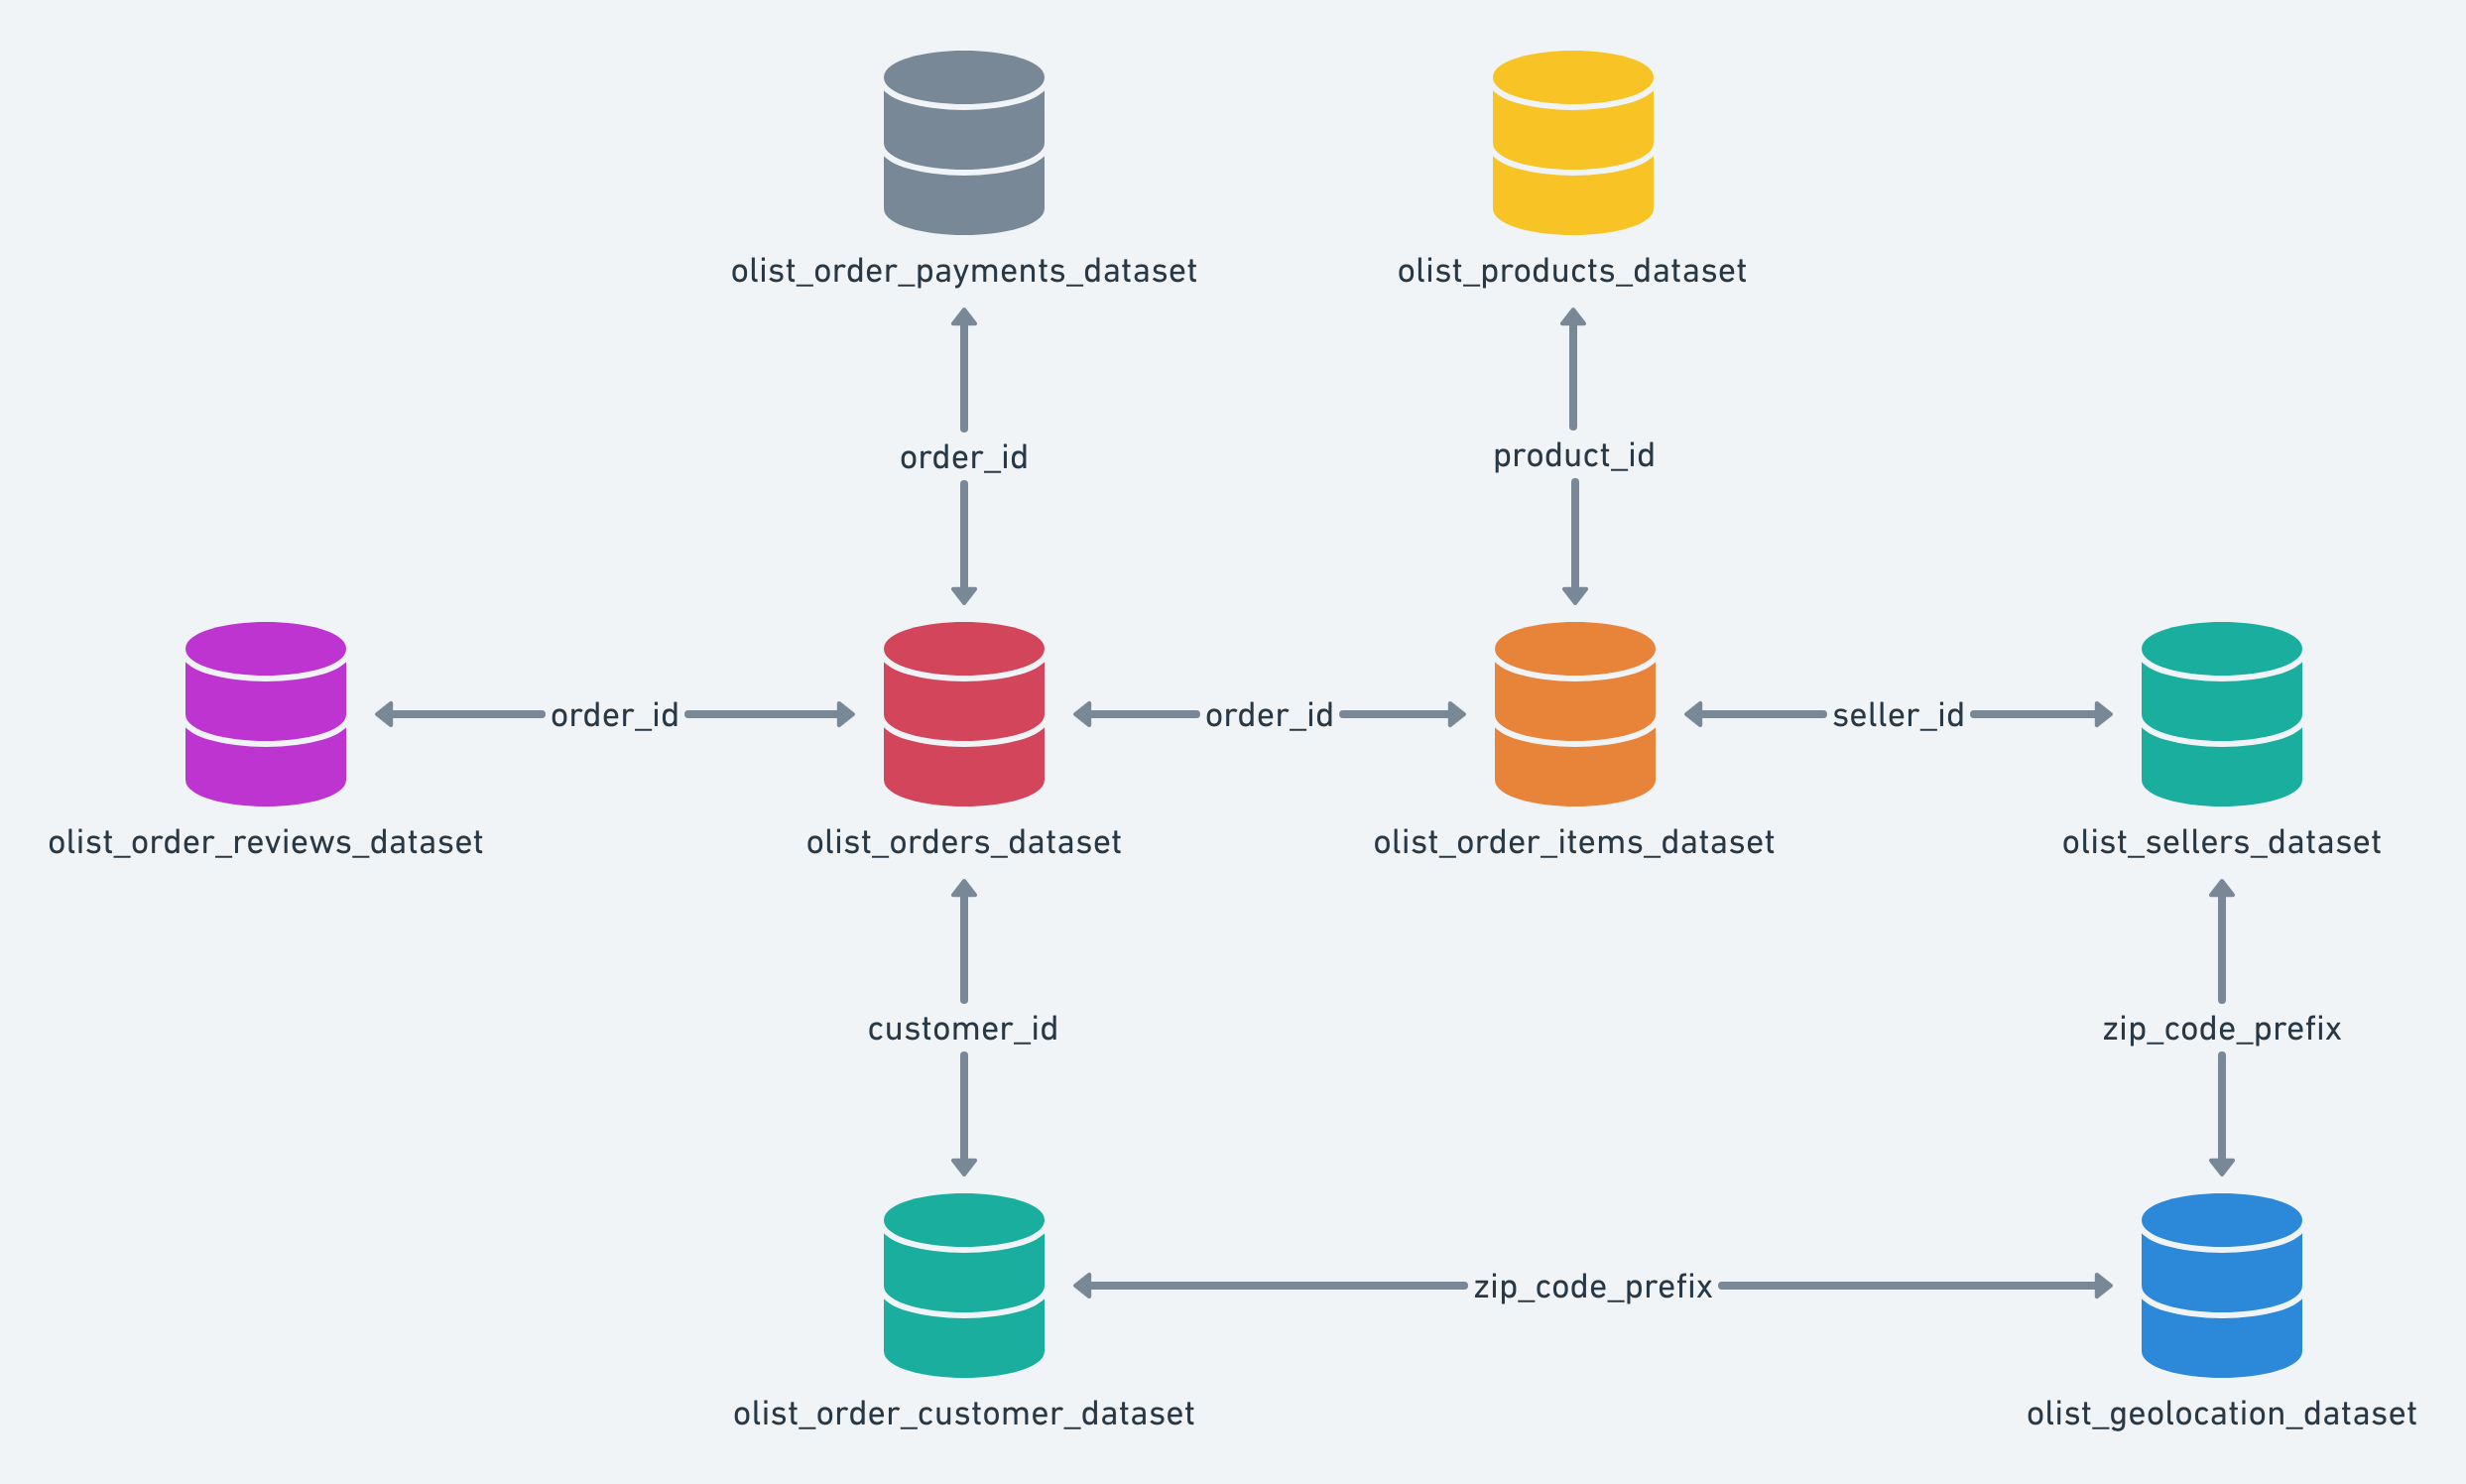

source {fig, datasets} : https://www.kaggle.com/olistbr/brazilian-ecommerce

Olist a mis a disposition les données sur Kaggle : y sont décrits les 8 datasets ainsi qu'un fichier product_category_name_translation. <br/>
Le schéma ci-dessus présente les datasets reliés par les clés indiquées.<br/>

En termes de cardinalités :
- les datasets sont fusionnables simplement avec une cardinalité 1:1 : cas de l'order_id depuis l'orders_dataset, mais également : customer_id, seller_id et product_id,
- un order est composé d'une liste de produits (1:n) via la notion d'items dans le datasets identifiant aussi le seller (1:1).
- un customerunique_id regroupe tous les customer_id associés en 1:1 à un order_id,
- le geolocation_dataset est associé via un zip_code_prefix, soit à un customer, soit à un seller. <br/>

Hors schéma, il reste une association simple des product_category_name en anglais qu'on exploitera pour une meilleure lisibilité.

In [2]:
%matplotlib inline
# importer les packages
# common
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.decomposition import PCA
# specific
from datetime import datetime
import time
# home made
import functions
from functions import distribution, charm_price, haversine
# paramètres
sns.set(style="ticks")
sns.set_style('whitegrid')

In [3]:
# Pour afficher toutes les colonnes
pd.options.display.max_columns = 100

In [4]:
# créer les dataframes correspondants aux données
df_customers = pd.read_csv('Data/olist_customers_dataset.csv')
df_orders = pd.read_csv('Data/olist_orders_dataset.csv')
df_items = pd.read_csv('Data/olist_order_items_dataset.csv')
df_products = pd.read_csv('Data/olist_products_dataset.csv')
df_payments = pd.read_csv('Data/olist_order_payments_dataset.csv')
df_sellers = pd.read_csv('Data/olist_sellers_dataset.csv')
df_reviews = pd.read_csv('Data/olist_order_reviews_dataset.csv')
df_geolocation = pd.read_csv('Data/olist_geolocation_dataset.csv')
df_translation = pd.read_csv('Data/product_category_name_translation.csv')

In [5]:
# créer le dict des datasets
datasets = {
    'Orders': df_orders,
    'Items': df_items,
    'Customers': df_customers,
    'Payments': df_payments,
    'Products': df_products,
    'Sellers': df_sellers,
    'Reviews': df_reviews,
    'Geolocation': df_geolocation,
    'Translation': df_translation,
}

In [6]:
# observer les tailles des datasets
for x, y in datasets.items():
    print(f'{x} shape is : ' f'{list(y.shape)}')

Orders shape is : [99441, 8]
Items shape is : [112650, 7]
Customers shape is : [99441, 5]
Payments shape is : [103886, 5]
Products shape is : [32951, 9]
Sellers shape is : [3095, 4]
Reviews shape is : [100000, 7]
Geolocation shape is : [1000163, 5]
Translation shape is : [71, 2]


Les données de 100 000 Commandes environ ont été mises à disposition.

In [7]:
ref = df_orders.shape[0]

# 3. Pertinence du recentrage sur le Client
Au vu du but recherché le principe est de construire des features caractérisant le Client, i.e. d'aggréger des données synthétiques au Customer_unique_id.<br/>
Dans cette logique, il faut opérer la sélection et le traitement des informations à "remonter" vers le Client au fil des liens d'association et cardinalité successifs.<br/>
Nous allons d'abord observer le triptyque Commande - Article - Client et son "recentrage" sur le Client.

## 3.1. Aperçu des données Clients

In [8]:
# aperçu des données customers
df_customers.sample(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
74110,f61cbaa6f1e966dc68180d028dfc6340,82bb804b1ce4844e9fcb9be805767b97,6693,itapevi,SP
28124,735407923bd7e1c88fd2994ae3a5d83b,457c16a2301237e613a1299777585d80,8574,itaquaquecetuba,SP
84485,607c5e234f26e35e0e8e32a6eb47670f,49d2fac3209b6f052367bb54444b3749,78050,cuiaba,MT


In [9]:
# compter le nombre de clients
df_customers['customer_unique_id'].unique().size

96096

Les données sont anonymisées et sommaires : la localisation {ville, état} reliée à une {lat, lng} via un code, ainsi que le customer_unique_id qui  regroupe tous les customer_id eux-mêmes reliés aux order_id. 

In [10]:
# compter le nb d'achat par client
df_customers_purchase = df_customers.groupby(
    'customer_unique_id',
    as_index=False).agg({'customer_id': ['count']})
df_customers_purchase.columns = ['customer_unique_id',
                                 'order_count']

In [11]:
# afficher les 10 clients ayant effectué le plus de commandes
df_customers_purchase = df_customers_purchase.sort_values(by='order_count',
                                                          ascending=False)
df_customers_purchase[:10]

,customer_unique_id,order_count
52973,8d50f5eadf50201ccdcedfb9e2ac8455,17
23472,3e43e6105506432c953e165fb2acf44c,9
37797,6469f99c1f9dfae7733b25662e7f1782,7
76082,ca77025e7201e3b30c44b472ff346268,7
10354,1b6c7548a2a1f9037c1fd3ddfed95f33,7
7175,12f5d6e1cbf93dafd9dcc19095df0b3d,6
83540,de34b16117594161a6a89c50b289d35a,6
37585,63cfc61cee11cbe306bff5857d00bfe4,6
90451,f0e310a6839dce9de1638e0fe5ab282a,6
27043,47c1a3033b8b77b3ab6e109eb4d5fdf3,6


In [12]:
# moyenne des commandes par client
df_customers_purchase['order_count'].mean()

1.0348089410589412

In [13]:
# nombre de clients pour lesquels on détient l'information de 2 achats ou plus
df_customers_purchase[df_customers_purchase['order_count'] > 1].shape

(2997, 2)

In [14]:
# pourcentage des clients multi-acheteurs
print(round(100 *
            df_customers_purchase[df_customers_purchase['order_count'] >
                                  1].shape[0] /
            df_customers_purchase.shape[0], 2)) 

3.12


In [15]:
# aggréger le nb d'achats effectués pour chaque client unique
df_customers = df_customers.merge(
    df_customers_purchase,
    how='left',
    left_on=['customer_unique_id'],
    right_on=['customer_unique_id'])

In [16]:
# observer le résultat
df_customers.sample(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_count
50718,62f5d0403db9849066c753aec113e20c,dbbca9fca7c5df38b618d6e8fce9a0c2,55590,ipojuca,PE,1
59298,54d964b83ac779bf3ab0fdb1877a51bc,26021fbea24c3916e675f0dceb0951d9,55340,aguas belas,PE,1
11720,7a6f04bd77baa1ca5f68a99cb29f6f2c,6d6c7bcba410b2206fb3cb9c33c3707f,1226,sao paulo,SP,1


## 3.2. Limitation des données
Nous constatons seulement 3 % d'acheteurs récurrents dans les données mises à disposition. <br/>
L'application de la méthode de segmentation RFM (Récence, Fréquence, Montant) est très largement compromise par cette troncature des données. 
En effet, en termes de segmentation, si des commandes ont été retirées pour la majorité des clients on retrouvera logiquement un groupe de clients étant fictivement les seuls à avoir réalisé plusieurs achats (Fréquence). <br/>
Par ailleurs, l'analyse de l'intervalle entre 2 achats risque de ne pas être représentative au moins quantitativement (Fréquence). <br/>
Enfin, le découpage dans le temps sans données longitudinales rend caduque la notion d'ancienneté client (Récence). <br/>

## 3.3. Aggrégation sur la Commande
Nous nous efforcerons donc de produire pour le marketing une caractéristation "directe" d'un nouveau client, en limitant autant que possible le biais d'une nouvelle troncature de donnée, selon la façon de retenir une commande unique par client (ex. la dernière commande effectuée, le produit le plus cher, etc.). <br/>

In [17]:
# contrôler les données manquantes
df_customers.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
order_count                 0
dtype: int64

# 4. La Commande au centre des données

In [18]:
# aperçu des données orders
df_orders.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00


La Commande est bien le centre initial et privilégié des données : elle permet de remonter aux Produits et aux Vendeurs via la notion d'Article (Item, qui représente le panier acheté). Elle est reliée directement aux Clients, aux Paiements et aux Avis. <br/>
Le processus pour chaque commande est détaillé (order_status et dates associées), à commencer par la date et l'heure d'achat. <br/>
Ces données temporelles permettent d'appréhender la période couverte et d'étudier la stabilité de la segmentation. <br/>
Nous passons en revue les éléments de la commande et des données reliées, susceptibles de caractériser le Client.

## 4.1. Order Status : filtrer les Commandes échues

In [19]:
# lister les valeurs possibles de l'order_status
df_orders['order_status'].unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

Text(0.5, 1.02, 'Order Status')

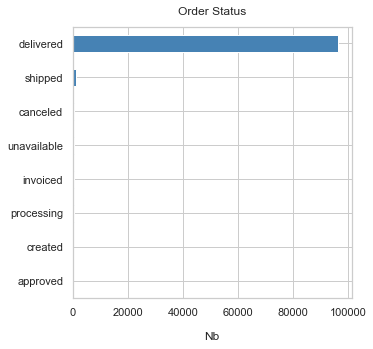

In [20]:
# observer la répartition des commandes par status
df_orders['order_status'].value_counts().plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Nb', labelpad=14)
plt.title('Order Status', y=1.02)

On choisit de retirer les commandes "en cours" et retirer les commandes non disponibles ou annulées (qui peuvent faire l'objet d'une attention client spécifique).

In [21]:
# retirer les commandes en cours
df_orders = df_orders[df_orders['order_status'] == 'delivered']
print(df_orders.shape)

(96478, 8)


In [22]:
# détecter les valeurs manquantes
df_orders.isna().sum()

order_id                          0
customer_id                       0
order_status                      0
order_purchase_timestamp          0
order_approved_at                14
order_delivered_carrier_date      2
order_delivered_customer_date     8
order_estimated_delivery_date     0
dtype: int64

In [23]:
# retirer les valeurs manquantes et controler la taille résultante
df_orders = df_orders.dropna().copy()
print(df_orders.shape)

(96455, 8)


In [24]:
print(ref-df_orders.shape[0])

2986


## 4.2. Order process : exploiter les dates de Commande
Le processus de commande va permettre d'observer les volumes de commandes sur la période mise à disposition.

In [25]:
# s'assurer du format des informations dates
for col in ['order_purchase_timestamp',
            'order_approved_at',
            'order_delivered_carrier_date',
            'order_delivered_customer_date',
            'order_estimated_delivery_date']:
    df_orders[col] = pd.to_datetime(df_orders[col],
                                    format='%Y-%m-%d %H:%M:%S')

In [26]:
# décomposer la date d'achat en donnée année, mois, jour, heure
df_orders['order_purchase_year'] =\
    df_orders.order_purchase_timestamp.apply(lambda x: x.year)
df_orders['order_purchase_month'] =\
    df_orders.order_purchase_timestamp.apply(lambda x: x.month)
df_orders['order_purchase_day'] =\
    df_orders.order_purchase_timestamp.apply(lambda x: x.day)
df_orders['order_purchase_dayofweek'] =\
    df_orders.order_purchase_timestamp.apply(lambda x: x.dayofweek)
df_orders['order_purchase_hour'] =\
    df_orders.order_purchase_timestamp.apply(lambda x: x.hour)
# identifier par son libellé, le moi et le jour de la semaine
df_orders['order_purchase_month_label'] =\
    df_orders.order_purchase_month.map({1: 'Jan',
                                        2: 'Feb',
                                        3: 'Mar',
                                        4: 'Apr',
                                        5: 'May',
                                        6: 'Jun',
                                        7: 'Jul',
                                        8: 'Aug',
                                        9: 'Sep',
                                        10: 'Oct',
                                        11: 'Nov',
                                        12: 'Dec'})
df_orders['order_purchase_dayofweek_label'] =\
    df_orders.order_purchase_dayofweek.map({0: 'Mon',
                                            1: 'Tue',
                                            2: 'Wed',
                                            3: 'Thu',
                                            4: 'Fri',
                                            5: 'Sat',
                                            6: 'Sun'})

### 4.2.1. Commandes mensuelles au cours du temps

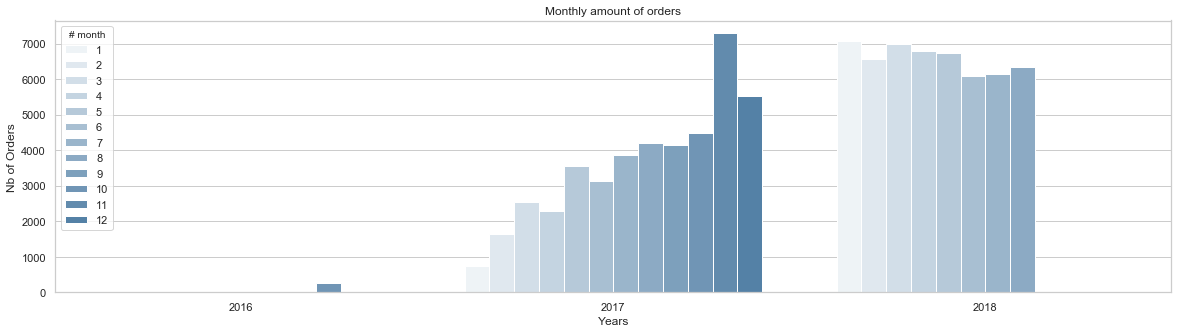

In [27]:
# afficher l'évolution des commandes
plt.figure(figsize=(20, 5))
ax = sns.countplot(x='order_purchase_year',
                   hue='order_purchase_month',
                   data=df_orders,
                   color='Steelblue')
ax.set(xlabel='Years',
       ylabel='Nb of Orders',
       title='Monthly amount of orders')
plt.legend(title='# month', loc='upper left')
plt.show()

Nous disposons à compter de Janvier 2018, d'une quantité de commande stable jusqu'au mois d'Aout 2018. Les 13 mois qui précèdent montrent une augmentation monotone à l'exception d'un probable surnombre de commandes en Novembre 2017. <br/>
Nous pouvons envisager de construire une segmentation sur la période 2017 et tester sa stabilité en injectant un par un les 8 mois suivants. <br/>

In [28]:
df_orders.sample(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_dayofweek,order_purchase_hour,order_purchase_month_label,order_purchase_dayofweek_label
12634,57dd83bf1021dc5613a4e19544a99915,953685e0b65f9e97278a0c2caea55e1c,delivered,2018-04-16 21:18:45,2018-04-17 21:10:19,2018-04-19 21:28:40,2018-05-14 14:52:38,2018-05-15,2018,4,16,0,21,Apr,Mon
81400,92ffa55d1d1e77f655127aac213c1e38,ea900ee2e9dd8860b8423bdc3d397643,delivered,2018-07-27 11:45:06,2018-07-28 03:35:13,2018-07-30 15:39:00,2018-08-06 19:56:27,2018-08-17,2018,7,27,4,11,Jul,Fri
4932,a1238d801729f0d9e4e905696a213eb8,0098400373e087d3c231fb5d37834fde,delivered,2017-03-23 18:28:32,2017-03-23 18:42:50,2017-03-24 09:51:08,2017-04-05 10:14:16,2017-04-20,2017,3,23,3,18,Mar,Thu


In [29]:
# créer / actualiser les commandes réparties par année
orders_2017 = df_orders[(df_orders['order_purchase_year'] == 2017) |
                        (df_orders['order_purchase_year'] == 2016)]
orders_2018 = df_orders[(df_orders['order_purchase_year'] == 2018)]

On observe donc deux périodes : la période transitoire "2017" qui correspond à une montée en charge, et la période stabilisée "2018".
Du fait de la troncature manifestement opérée sur les données, la transition ou la stabilité peuvent être mises en doute.

### 4.2.2. Moment d'achat

Nous allons observer les commandes au fil des jours du mois et au fil de la semaine :<br/>
Le Client pouvant être caractérisé par le moment privilégié de la journée, de la semaine ou du mois où il effectue ses achats.<br/>

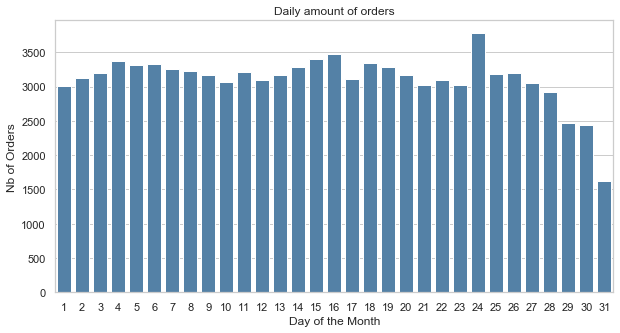

In [30]:
# afficher l'évolution des commandes selon les jours du mois (en cumul)
plt.figure(figsize=(10, 5))
ax = sns.countplot(x='order_purchase_day',
                   data=df_orders,
                   color='Steelblue')
ax.set(xlabel='Day of the Month',
       ylabel='Nb of Orders',
       title='Daily amount of orders')
plt.show()

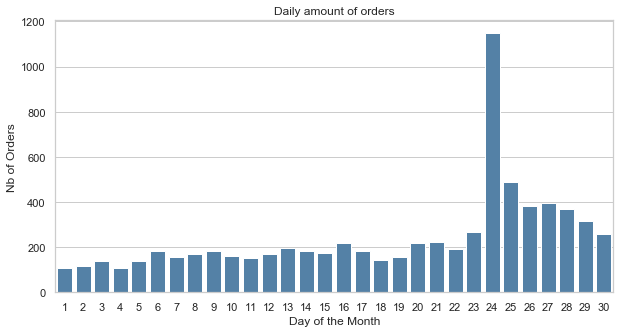

In [31]:
# confirmer le pic de commandes 11/2017
plt.figure(figsize=(10, 5))
ax = sns.countplot(x='order_purchase_day',
                   data=df_orders[(df_orders['order_purchase_year'] == 2017) &
                                  (df_orders['order_purchase_month'] == 11)],
                   color='Steelblue')
ax.set(xlabel='Day of the Month',
       ylabel='Nb of Orders',
       title='Daily amount of orders')
plt.show()

Excepté le 24 novembre 2017, nous ne constatons pas de grande variation et le plus faible nombre de commandes constatées un 31ème jour du mois est trivial.

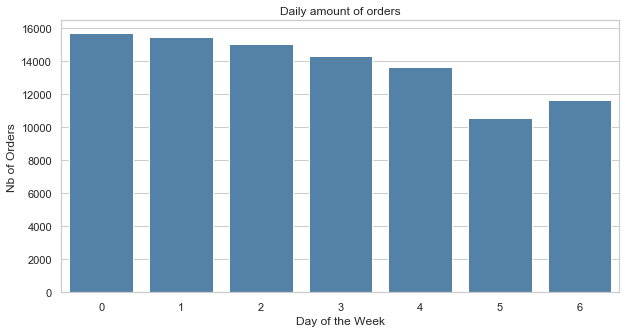

In [32]:
# afficher l'évolution des commandes selon les jours de la semaine
plt.figure(figsize=(10, 5))
ax = sns.countplot(x='order_purchase_dayofweek',
                   data=df_orders,
                   color='Steelblue')
ax.set(xlabel='Day of the Week',
       ylabel='Nb of Orders',
       title='Daily amount of orders')
plt.show()

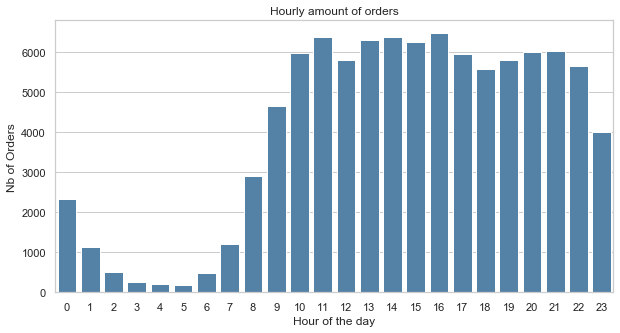

In [33]:
# afficher l'évolution des commandes selon les heures de la journée
plt.figure(figsize=(10, 5))
ax = sns.countplot(x='order_purchase_hour',
                   data=df_orders,
                   color='Steelblue')
ax.set(xlabel='Hour of the day',
       ylabel='Nb of Orders',
       title='Hourly amount of orders')
plt.show()

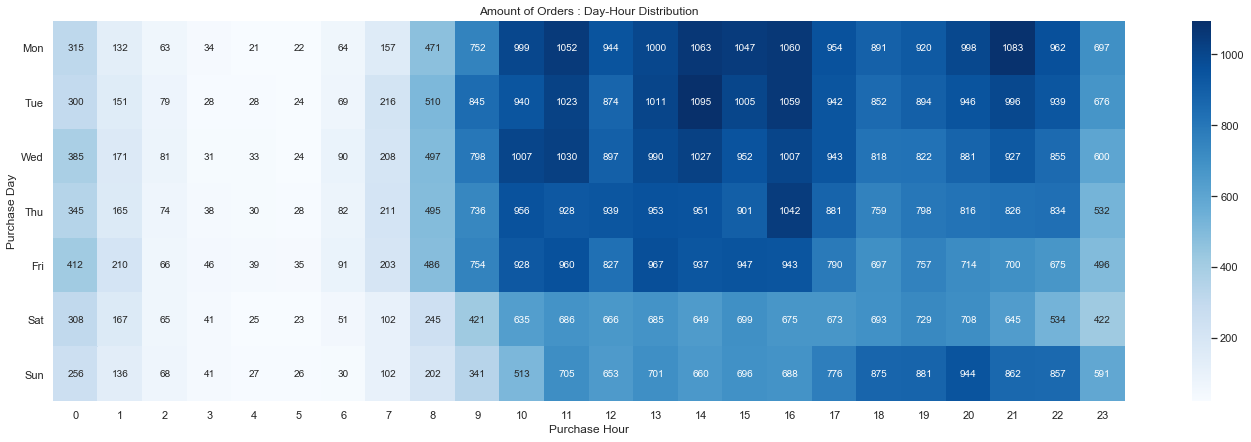

In [34]:
# afficher la répartition des commandes par heure et jour d'achat
order_count = df_orders.groupby(['order_purchase_dayofweek',
                                 'order_purchase_hour'])\
    .count()['order_id'].unstack()
plt.figure(figsize=(24, 7))
ax = sns.heatmap(order_count, cmap='Blues', annot=True, fmt='d')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set(xlabel='Purchase Hour',
       ylabel='Purchase Day',
       yticklabels=(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']),
       title='Amount of Orders : Day-Hour Distribution')
for item in ax.get_yticklabels():
    item.set_rotation(0)
plt.show()

Nous obtenons des périodes d'une heure pour lesquelles la quantité de commande peut varier de quelques unités à plus d'un millier (en cumul sur près de 2 ans) : nous dégageons des zones temporelles.

### 4.2.3. Découpage du moment d'achat en zone temporelles

Pour effectuer ce découpage, nous nous appuyons sur la visualisation des décomptes par heure - jour qu'offre une clustermap, c'est à dire une heatmap dont les données sont organisées à partir d'un clustering hiérarchique.
Après test les différentes méthodes de clustering et métriques de calcul des distances (lorsqu'elles sont viables) présentent des résultats similaires.

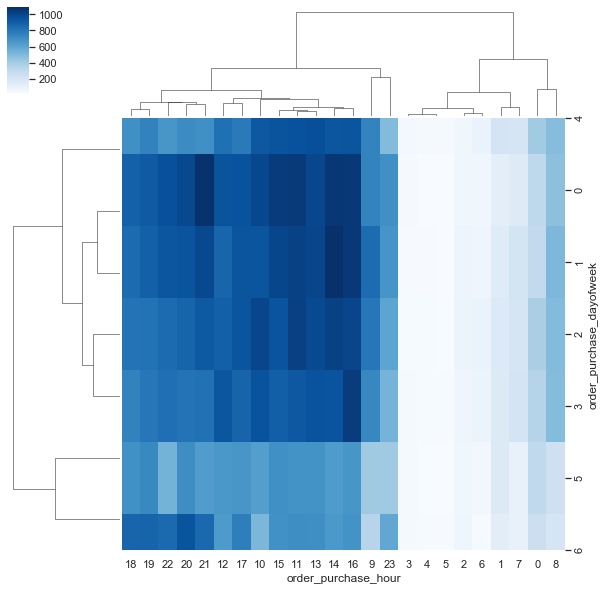

In [35]:
# afficher une clustermap pour définir les zones temporelles
sns.clustermap(order_count, cmap='Blues', method='median', metric='euclidean')
plt.show()

Le clustering fait apparaitre très clairement le découpage Working-Day / Week-End, ainsi que Day - Night. <br/>
On observe une distinctionpour 9h et 23h, mais qui ont moins de sens à être dissociés que l'usuelle distinction Day-Evening qui apparait juste après. <br/>

Il y a deux niveaux de compromis possibles, selon qu'on aménage ou non une distinction AM - PM qui a l'avantage de répartir les effectifs de commandes de manière plus équitable et d'être facilement actionnable / interprétable pour des visées marketing.

On retient dans ce cas 4 à 5 time zones :
- "Night", creuse quelque soit le jour de la semaine, couvrant la période [0h-8h],
- "WE", week-end,
- "Day" [9h-17h] et "Evening-WD" [18h-23h],
- en coupant "Day" par la distinction usuelle "AM" [9h-12h] et "PM" [13h-17h].


In [36]:
# distinguer nuit, am, pm, evening
df_orders['time_zone_hour'] =\
    df_orders.order_purchase_hour.map({0: 'Night',
                                       1: 'Night',
                                       2: 'Night',
                                       3: 'Night',
                                       4: 'Night',
                                       5: 'Night',
                                       6: 'Night',
                                       7: 'Night',
                                       8: 'AM',
                                       9: 'AM',
                                       10: 'AM',
                                       11: 'AM',
                                       12: 'AM',
                                       13: 'PM',
                                       14: 'PM',
                                       15: 'PM',
                                       16: 'PM',
                                       17: 'PM',
                                       18: 'Evening',
                                       19: 'Evening',
                                       20: 'Evening',
                                       21: 'Evening',
                                       22: 'Evening',
                                       23: 'Evening'})

In [37]:
# distinguer week et week-end
df_orders['time_zone_day'] =\
    df_orders.order_purchase_dayofweek.map({0: 'WD',
                                            1: 'WD',
                                            2: 'WD',
                                            3: 'WD',
                                            4: 'WD',
                                            5: 'WE',
                                            6: 'WE'})

In [38]:
# construire les 3 zones WD : AM, PM et Evening
df_orders['purchase_time_zone_cat'] = df_orders['time_zone_hour'] + '-' + df_orders['time_zone_day']

In [39]:
# construire la time zone WE
df_orders['purchase_time_zone_cat'][df_orders['time_zone_day'] == 'WE'] = 'WE'

C:\Users\etien\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [40]:
# construire la time zone Night
df_orders['purchase_time_zone_cat'][df_orders['time_zone_hour'] == 'Night'] = 'Night'

C:\Users\etien\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [41]:
# contrôler la liste de time zone construites
df_orders['purchase_time_zone_cat'].unique()

array(['AM-WD', 'Evening-WD', 'WE', 'PM-WD', 'Night'], dtype=object)

Text(0.5, 1.02, 'Purchase Time Zones')

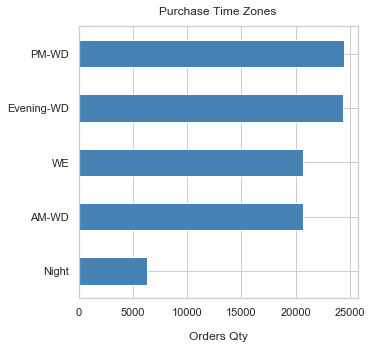

In [42]:
# observer la répartition des commandes par purchase_time_zone
df_orders['purchase_time_zone_cat'].value_counts().plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Orders Qty', labelpad=14)
plt.title('Purchase Time Zones', y=1.02)

In [43]:
df_orders.sample(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_dayofweek,order_purchase_hour,order_purchase_month_label,order_purchase_dayofweek_label,time_zone_hour,time_zone_day,purchase_time_zone_cat
83494,980044cb2540e5978dc610bcc47bb9e7,5c5539a9bb527a0c669e8addeff05e07,delivered,2018-08-01 01:11:52,2018-08-02 03:05:21,2018-08-02 14:20:00,2018-08-09 14:58:37,2018-08-27,2018,8,1,2,1,Aug,Wed,Night,WD,Night
44210,b316c449e8b0f35e4766fcb0583fcb20,5f2c12cf37ffc577d7e7a30b93d160d9,delivered,2018-03-31 14:53:08,2018-04-02 15:32:47,2018-04-03 18:33:24,2018-04-16 18:48:24,2018-04-23,2018,3,31,5,14,Mar,Sat,PM,WE,WE
20813,cee2b107d70b04f20a6b74b7a086c8cf,d156adf822c2f7cf64cf09297bcbd0dc,delivered,2018-02-18 18:55:45,2018-02-20 07:40:22,2018-02-20 18:18:52,2018-03-05 21:26:02,2018-03-13,2018,2,18,6,18,Feb,Sun,Evening,WE,WE


### 4.2.4. Délais de livraison et retard

Le comportement futur du client, et plus directement le review score qu'il donnera à réception de l'article, peut être affecté par l'écart de date de livraison effective / estimée et dans une moindre mesure par le délai d'approbation de sa commande (ce dernier est réduit et standard et ne sera donc pas considéré à ce stade).<br/>

In [44]:
# calculer le délai de livraison annoncé
df_orders['estimated_delivery_time'] =\
    (df_orders['order_estimated_delivery_date'] -
     df_orders['order_purchase_timestamp']).dt.days

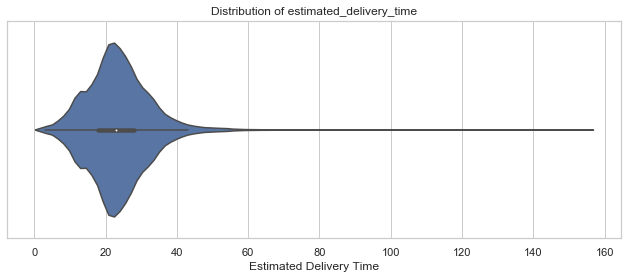

Délai moyen de livraison annoncé en jours : 23


In [45]:
# afficher la distribution de délais de livraison estimé / annoncé
distribution(df_orders,
             'estimated_delivery_time',
             'Estimated Delivery Time',
             'violin')
print('Délai moyen de livraison annoncé en jours : ' +
      str(round(df_orders['estimated_delivery_time'].mean())))

On observe des délais annoncés extrêmes. Le processus de commande n'est plus nominal, comme c'est le cas par exemple pour des articles en rupture de stock, où le délai estimé est forcément erroné si les délais de fabrication ne sont pas maîtrisés.

In [46]:
# calculer le délai de livraison effectif
df_orders['effective_delivery_time'] =\
    (df_orders['order_delivered_customer_date'] -
     df_orders['order_purchase_timestamp']).dt.days

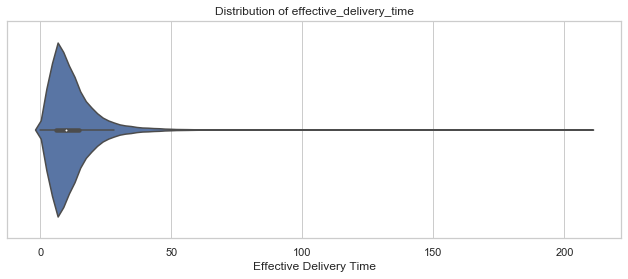

Délai moyen effectif de livraison en jours : 12


In [47]:
# afficher la distribution des délais de livraison effectif
distribution(df_orders,
             'effective_delivery_time',
             'Effective Delivery Time',
             'violin')
print('Délai moyen effectif de livraison en jours : ' +
      str(round(df_orders['effective_delivery_time'].mean())))

In [48]:
# nombre de livraison sous 24h
df_orders[df_orders['effective_delivery_time'] == 0].shape

(13, 20)

In [49]:
# calculer l'écart entre la livraison réelle et prévue (en jours d'avance)
df_orders['delivery_vs_estimated'] =\
    (df_orders['order_estimated_delivery_date'] -
     df_orders['order_delivered_customer_date']).dt.days

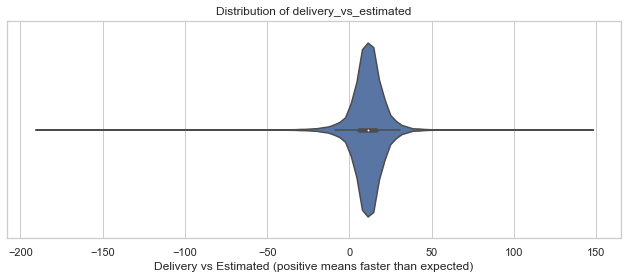

Ecart moyen entre le délai de livraison effective et estimé : 11


In [50]:
# afficher la distribution de l'écart de délai de livraison
distribution(df_orders,
             'delivery_vs_estimated',
             'Delivery vs Estimated (positive means faster than expected)',
             'violin')
print('Ecart moyen entre le délai de livraison effective et estimé : ' +
      str(round(df_orders['delivery_vs_estimated'].mean())))

Les clients reçoivent en général leur commande 11 jours avant la date estimée, qui est de fait estimée au delà des délais nominaux de préparation - expédition - transport - livraison. 

Bien que le client ne le "sache" pas, le délai qui lui est annoncé est régulièrement honoré à la moitié ou presque, ou à l'inverse, on lui annonce en moyenne le double du délai que prendrait réellement la livraison en moyenne. <br/>
Cela implique de construire une indication corrigée de l'écart de délai de livraison, et par exemple considérer l'écart de livraison par rapport à la valeur moyenne. <br/>

In [51]:
# créer / actualiser les commandes répartes par année
orders_2017 = df_orders[(df_orders['order_purchase_year'] == 2017) |
                        (df_orders['order_purchase_year'] == 2016)]
orders_2018 = df_orders[(df_orders['order_purchase_year'] == 2018)]

In [52]:
# observer la variation éventuelle entre 2017 et 2018
print('Variation delivery_vs_estimated entre 2017 (ref) et 2018 : ' +
      str(round(orders_2017['delivery_vs_estimated'].mean() - orders_2018['delivery_vs_estimated'].mean())))

Variation delivery_vs_estimated entre 2017 (ref) et 2018 : 1


Les cas extrêmes observés produise des situations incohérentent qui remettent en cause la fiabilité de la date annoncé. <br/>
Ils portent sur une faible quantité de commandes. <br/>
On décide de filtrer sur la base du délai estimé, en vertu du principe qu'il n'est pas maîtrisé dans ce cas (délai de fabrication) et qu'il fera l'objet d'un suivi spécifique.

In [53]:
# calcul du 99ème percentile pour le délai estimé
np.percentile(df_orders['estimated_delivery_time'], 99)

50.0

In [54]:
# contrôler la quantité d'outliers considérés
df_orders[df_orders['estimated_delivery_time'] >= 50].shape

(1001, 21)

In [55]:
# calcul du 99ème percentile pour le délai effectif
np.percentile(df_orders['effective_delivery_time'], 99)

46.0

In [56]:
# contrôler la quantité d'outliers considérés
df_orders[df_orders['effective_delivery_time'] >= 45].shape

(1091, 21)

In [57]:
# retirer les outliers
df_orders = df_orders[df_orders['estimated_delivery_time'] < 50]
df_orders = df_orders[df_orders['effective_delivery_time'] < 45]

In [58]:
# contrôler le nb de commandes
df_orders.shape

(94422, 21)

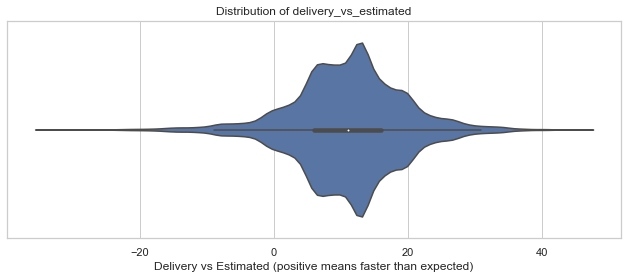

Ecart moyen entre le délai de livraison effective et estimé : 11


In [59]:
# afficher la distribution de l'écart de délai de livraison
distribution(df_orders,
             'delivery_vs_estimated',
             'Delivery vs Estimated (positive means faster than expected)',
             'violin')
print('Ecart moyen entre le délai de livraison effective et estimé : ' +
      str(round(df_orders['delivery_vs_estimated'].mean())))

Au vu de cette répartition, on opte pour une séparation en 3 : nominal, sooner and later.

In [60]:
df_orders['delivery_vs_estimated_lvl'] = pd.qcut(
    df_orders['delivery_vs_estimated'],
    3,
    labels=['Later_Delivery',
            'Nominal_Delivery',
            'Sooner_Delivery'])

Text(0.5, 1.02, 'Delivery Delay Levels')

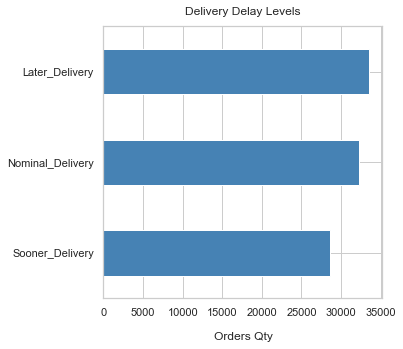

In [61]:
# observer la répartition des retard ou avance de livraison
df_orders['delivery_vs_estimated_lvl'].value_counts().plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Orders Qty', labelpad=14)
plt.title('Delivery Delay Levels', y=1.02)

In [62]:
# retirer les valeurs manquantes et controler la taille résultante
df_orders = df_orders.dropna().copy()
print(df_orders.shape)

(94422, 22)


In [63]:
# retirer les colonnes obsolètes
df_orders = df_orders.drop(
    columns=['order_status',
             'order_approved_at',
             'order_delivered_carrier_date',
             'order_delivered_customer_date',
             'order_estimated_delivery_date'])

In [64]:
# aperçu des données orders
df_orders.head(3)

,order_id,customer_id,order_purchase_timestamp,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_dayofweek,order_purchase_hour,order_purchase_month_label,order_purchase_dayofweek_label,time_zone_hour,time_zone_day,purchase_time_zone_cat,estimated_delivery_time,effective_delivery_time,delivery_vs_estimated,delivery_vs_estimated_lvl
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017,10,2,0,10,Oct,Mon,AM,WD,AM-WD,15,8,7,Later_Delivery
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,2018,7,24,1,20,Jul,Tue,Evening,WD,Evening-WD,19,13,5,Later_Delivery
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,2018,8,8,2,8,Aug,Wed,AM,WD,AM-WD,26,9,17,Sooner_Delivery


# 5. Les articles (Items & Products)

Le dataset items relie la commande (order) aux produits (products) : il détaille le "panier" d'articles commandés, et pour lesquels sont définis le vendeur, le prix, le coût de livraison, une éventuelle date limite d'envoi.<br/>
Tandis que le dataset Products définis les caractéristiques unitaires de catégorie, taille, poids et description de l'article. <br/>
On retrouve la quantité achetée car les produits sont listés unitairement.

## 5.1. Items (articles d'un panier)

In [65]:
# aperçu des données Items
df_items.sample(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
58783,85d7c5b41a94729aa45792bc7b344b79,1,c857b96593773e940454e76efa8eabb3,cca3071e3e9bb7d12640c9fbe2301306,2017-07-31 14:50:14,51.92,12.70
23659,35edfe0ed82ffa12bb88c0395209e513,5,51f876eb62be778c757503cf7f8a3b74,f84a00e60c73a49e7e851c9bdca3a5bb,2017-12-27 00:31:50,9.80,7.94
98994,e09dd765041e9934d762d51ccb26adee,1,7c68e7297c7df2535c9f0dcd61007f64,bb135baca94c82fcb731335ad5b04a03,2017-01-25 06:58:31,9.90,9.62


La date limite d'envoi est une information attachée au panier complétant les délais renseignés, le délai d'envoi varie peu et sera ignoré.

In [66]:
# ordonner les articles par prix décroissants
df_items = df_items.sort_values(by=['order_id', 'price'],
                                ascending=False)

In [67]:
# compter le nb d'articles par commande
df_items_count = df_items.groupby(
    'order_id',
    as_index=False).agg({'order_item_id': ['max'],
                         'product_id': ['nunique']})
df_items_count.columns = ['order_id',
                          'items_qty',
                          'products_qty']

In [68]:
# nombre de commandes uniques
df_items_count.shape

(98666, 3)

In [69]:
# afficher les 3 commandes avec le plus d'articles
df_items_count = df_items_count.sort_values(by='items_qty',
                                            ascending=False)
df_items_count[:3]

,order_id,items_qty,products_qty
50137,8272b63d03f5f79c56e9e4120aec44ef,21,3
10459,1b15974a0141d54e36626dca3fdc731a,20,1
65715,ab14fdcfbe524636d65ee38360e22ce8,20,1


In [70]:
#  quantités d'articles et nb d'articles différents et pourcentages
print('nb articles en moyenne par commande  : ' +
      str(round(df_items_count['items_qty'].mean(), 2)))
print('nb articles différents en moyenne par commande  : ' +
      str(round(df_items_count['products_qty'].mean(), 2)))
print('pourcentage de commandes avec 2 articles ou plus  : ' +
      str(round(100 *
                df_items_count[df_items_count['items_qty'] > 1].shape[0] /
                df_items_count.shape[0], 2)))
print('pourcentage de commandes avec 2 produits différents ou plus  : ' +
      str(round(100 *
                df_items_count[df_items_count['products_qty'] > 1].shape[0] /
                df_items_count.shape[0], 2)))

nb articles en moyenne par commande  : 1.14
nb articles différents en moyenne par commande  : 1.04
pourcentage de commandes avec 2 articles ou plus  : 9.94
pourcentage de commandes avec 2 produits différents ou plus  : 3.28


In [71]:
# scruter les commandes avec les plus grandes quantité d'articles
df_items[df_items['order_id'] == '8272b63d03f5f79c56e9e4120aec44ef']

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
57317,8272b63d03f5f79c56e9e4120aec44ef,21,79ce45dbc2ea29b22b5a261bbb7b7ee7,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,7.8,6.57
57297,8272b63d03f5f79c56e9e4120aec44ef,1,270516a3f41dc035aa87d220228f844c,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57298,8272b63d03f5f79c56e9e4120aec44ef,2,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57299,8272b63d03f5f79c56e9e4120aec44ef,3,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57300,8272b63d03f5f79c56e9e4120aec44ef,4,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57301,8272b63d03f5f79c56e9e4120aec44ef,5,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57302,8272b63d03f5f79c56e9e4120aec44ef,6,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57303,8272b63d03f5f79c56e9e4120aec44ef,7,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57304,8272b63d03f5f79c56e9e4120aec44ef,8,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57305,8272b63d03f5f79c56e9e4120aec44ef,9,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89


In [72]:
df_items[df_items['order_id'] == '00143d0f86d6fbd9f9b38ab440ac16f5']

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
32,00143d0f86d6fbd9f9b38ab440ac16f5,1,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1
33,00143d0f86d6fbd9f9b38ab440ac16f5,2,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1
34,00143d0f86d6fbd9f9b38ab440ac16f5,3,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1


Il s'agit de quantités élevées d'un nombre réduit d'articles différent, ce qui tend à indiquer que c'est la nature du produit qui implique d'en commander une plus grande quantité, au contraire d'une diversité d'articles dans le panier de commande. <br/>
C'est un effet probable de la troncature des données.

On observe que le coût de livraison semble s'ajouter pour chaque produit contrairement à ce qu'on imagine dans la réalité. <br/>
C'est lié à la répartition d'un coût de livraison calculé (f(taille, poids)) et réparti sur les items de la commande.

In [73]:
# nombre de commandes pour lesquelles il y 2 articles différents ou plus
df_items_count[df_items_count['products_qty'] > 1].shape

(3236, 3)

In [74]:
# dériver en un feature catégoriel les single_product ou multi_product (2 et +)
df_items_count['products_qty'] =\
    df_items_count['products_qty'].map(
    lambda x: 'multi_products' if x >= 2 else 'single_product')
# dériver en un feature catégoriel les single_item ou multi_item (2 et +)
df_items_count['items_qty'] =\
    df_items_count['items_qty'].map(
    lambda x: 'multi_items' if x >= 2 else 'single_item')

Text(0.5, 1.02, 'Single vs multi-products balance')

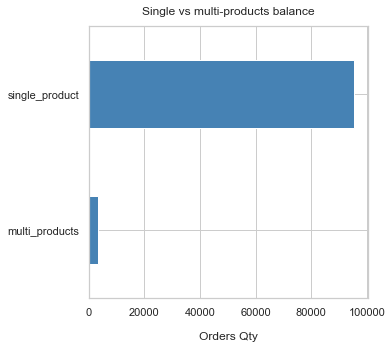

In [75]:
# observer la répartition des single et multi_product
df_items_count['products_qty'].value_counts().plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Orders Qty', labelpad=14)
plt.title('Single vs multi-products balance', y=1.02)

Text(0.5, 1.02, 'Single vs multi-items balance')

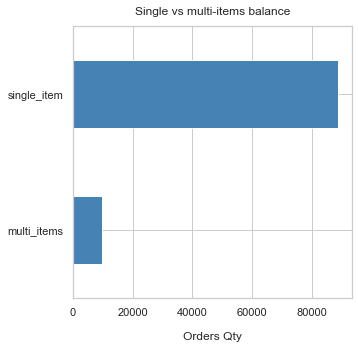

In [76]:
# observer la répartition des single et multi_item
df_items_count['items_qty'].value_counts().plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Orders Qty', labelpad=14)
plt.title('Single vs multi-items balance', y=1.02)

In [77]:
# aggréger aux commandes le nb d'articles
df_orders = df_orders.merge(
    df_items_count,
    how='left',
    left_on=['order_id'],
    right_on=['order_id'])

In [78]:
df_orders.shape

(94422, 19)

In [79]:
print(ref-df_orders.shape[0])
df_orders.sample(3)

5019


,order_id,customer_id,order_purchase_timestamp,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_dayofweek,order_purchase_hour,order_purchase_month_label,order_purchase_dayofweek_label,time_zone_hour,time_zone_day,purchase_time_zone_cat,estimated_delivery_time,effective_delivery_time,delivery_vs_estimated,delivery_vs_estimated_lvl,items_qty,products_qty
60958,e4f0b379cb8233db68561f79f774988d,418674f10950b8eef8388d160ac4a53a,2018-02-19 16:31:25,2018,2,19,0,16,Feb,Mon,PM,WD,PM-WD,23,3,20,Sooner_Delivery,single_item,single_product
24667,a2d07ac7e227a1d032218e0144893375,1f919de718cca46a16d7485dac73b9b8,2017-11-15 13:09:06,2017,11,15,2,13,Nov,Wed,PM,WD,PM-WD,21,16,5,Later_Delivery,single_item,single_product
16771,de3574da763e9c4950cfc27933332396,f2468e9b3de6ba79a57728bbfd70527f,2018-06-04 07:56:55,2018,6,4,0,7,Jun,Mon,Night,WD,Night,15,9,6,Later_Delivery,single_item,single_product


### 5.1.1.  Article principal de la commande

Au vu du faible de nombre de commandes multi-items, et encore plus faible de commandes multi-articles , l'idée est de résumer une commande à l'article le plus important, plutôt que de perdre le sens en fusionnant les caractéristiques des articles à ce stade. <br/>
On retient comme article le pus important, celui correspondant à la plus grosse dépense.

In [80]:
#  garder l'article le plus cher pour chaque commande
df_items_mip = df_items[['order_id', 'product_id']].drop_duplicates(
    subset='order_id',
    keep='first').copy()
# renommer le feature désignant le produit le plus important
df_items_mip = df_items_mip.rename(columns={'product_id': 'most_important_product'})

In [81]:
# vérifier un résultat
df_items_mip[df_items_mip['order_id'] == '8272b63d03f5f79c56e9e4120aec44ef']

,order_id,most_important_product
57317,8272b63d03f5f79c56e9e4120aec44ef,79ce45dbc2ea29b22b5a261bbb7b7ee7


In [82]:
# aggréger aux commandes l'article le plus cher
df_orders = df_orders.merge(
    df_items_mip,
    how='left',
    left_on=['order_id'],
    right_on=['order_id'])

In [83]:
# contrôler le résultat
print(ref-df_orders.shape[0])
df_orders.sample(7)

5019


,order_id,customer_id,order_purchase_timestamp,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_dayofweek,order_purchase_hour,order_purchase_month_label,order_purchase_dayofweek_label,time_zone_hour,time_zone_day,purchase_time_zone_cat,estimated_delivery_time,effective_delivery_time,delivery_vs_estimated,delivery_vs_estimated_lvl,items_qty,products_qty,most_important_product
58979,1567393726edacf3d6b548daa7a34475,f752eb5ad4ba2692fc58c43a8c420c8a,2018-03-29 10:41:51,2018,3,29,3,10,Mar,Thu,AM,WD,AM-WD,33,13,20,Sooner_Delivery,single_item,single_product,1a9d64af3398397aa9948a714bb2baaa
89783,c995be74082b70d3ec06d817e73f7300,d5435bfb461189b2b1fe24dc28797056,2017-12-03 19:18:56,2017,12,3,6,19,Dec,Sun,Evening,WE,WE,25,32,-7,Later_Delivery,multi_items,multi_products,81a266bbf4c7aa3113db84e81ca899b8
92583,bbec5ebc694ba25d867c7d3493a18e2e,5834f051f3aed6dbad4d1d1fb604768a,2017-04-03 17:14:19,2017,4,3,0,17,Apr,Mon,PM,WD,PM-WD,22,7,14,Nominal_Delivery,single_item,single_product,c1488892604e4ba5cff5b4eb4d595400
35393,35b2be75ac71d838d1743e201de6bcaa,9797ebd812978869a779e146e9b2e140,2018-08-19 17:17:06,2018,8,19,6,17,Aug,Sun,PM,WE,WE,16,8,8,Later_Delivery,single_item,single_product,937c825572d26b9e5a723527c6d625c6
6079,7c9b63669cf62dd8d1ed4d40d5bf953a,a6c424c5f57e7085560010f2082121ec,2018-07-01 12:21:19,2018,7,1,6,12,Jul,Sun,AM,WE,WE,22,10,12,Nominal_Delivery,single_item,single_product,8365b258a7ca21a31b8c972495efd2f7
71787,121dbde7d88c82adc886e26b28552ef7,e9d4a08d748f76bdddafcbbbaf1e9fc9,2018-05-19 16:13:18,2018,5,19,5,16,May,Sat,PM,WE,WE,32,19,13,Nominal_Delivery,single_item,single_product,ca5c923962558430573f83661dbe36d6
72969,9546aa638d07ac340a91c59b0b2dee96,8d0a81505e8e6b660cdb18c8b4c6c2a4,2018-08-10 16:05:40,2018,8,10,4,16,Aug,Fri,PM,WD,PM-WD,16,5,11,Nominal_Delivery,single_item,single_product,4732ecf5e4abee8f7ff4d1b8df0f7af5


In [84]:
df_orders[df_orders['order_id'] == '00143d0f86d6fbd9f9b38ab440ac16f5']

,order_id,customer_id,order_purchase_timestamp,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_dayofweek,order_purchase_hour,order_purchase_month_label,order_purchase_dayofweek_label,time_zone_hour,time_zone_day,purchase_time_zone_cat,estimated_delivery_time,effective_delivery_time,delivery_vs_estimated,delivery_vs_estimated_lvl,items_qty,products_qty,most_important_product
34445,00143d0f86d6fbd9f9b38ab440ac16f5,2e45292979b9b2700ea09560eeb0f803,2017-10-16 15:29:43,2017,10,16,0,15,Oct,Mon,PM,WD,PM-WD,20,11,9,Nominal_Delivery,multi_items,single_product,e95ee6822b66ac6058e2e4aff656071a


In [85]:
df_orders[df_orders['order_id'] == '8272b63d03f5f79c56e9e4120aec44ef']

,order_id,customer_id,order_purchase_timestamp,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_dayofweek,order_purchase_hour,order_purchase_month_label,order_purchase_dayofweek_label,time_zone_hour,time_zone_day,purchase_time_zone_cat,estimated_delivery_time,effective_delivery_time,delivery_vs_estimated,delivery_vs_estimated_lvl,items_qty,products_qty,most_important_product
84371,8272b63d03f5f79c56e9e4120aec44ef,fc3d1daec319d62d49bfb5e1f83123e9,2017-07-16 18:19:25,2017,7,16,6,18,Jul,Sun,Evening,WE,WE,11,14,-4,Later_Delivery,multi_items,multi_products,79ce45dbc2ea29b22b5a261bbb7b7ee7


Le cas de commandes multi_items et single_product invite à reconsidérer le prix affiché et le coût de livraison :
- le prix "visible" est celui de la quantité d'un même article (à aggréger en un total_price).
- le coût de livraison est, conformément aux indications kaggle, réparti sur les exemplaires d'un même article, et peut en conséquence être re-aggrégé.
- l'aggrégation est compromise dans le cas marginal des commandes multi_items et multi_products. <br/>
On décide de : 
- retirer les commandes multi-products,
- conserver une seule occurence de chaque commande multi-items, donc appliquant au produit son "total_price" selon la quantité. <br/>

Cela implique de dégrader l'information du nombre d'items, mais cela consiste simplement à considérer plusieurs valeurs pour un même produit selon la quantité achetée, c'est donc une opération valable pour une donnée centrée client. <br/>
Cela a pour autre conséquence d'expérimenter le calcul du charm price sur le total_price, qui est celui finalement affiché pour le client et non celui rattaché à chaque occurence des articles de la commande (idem pour le coût de livraison).

In [86]:
# retirer les commandes multi-products
print(df_orders.shape)
df_orders = df_orders[df_orders['products_qty'] == 'single_product'].copy()
print(df_orders.shape)

(94422, 20)
(91294, 20)


### 5.1.2. Coûts totaux et part du coût de transport

On a observé que les coûts totaux (prix, transport) ont plus de sens sous réserve de ne garder que les commandes mono-produit. <br/>

In [87]:
# renommer en product_x pour ne pas confondre avec le total_x
df_items = df_items.rename(columns={
    'freight_value': 'product_freight',
    'price': 'product_price'})

In [88]:
# retirer les colonnes inutiles
df_items = df_items.drop(
    columns=['shipping_limit_date',
             'order_item_id'])

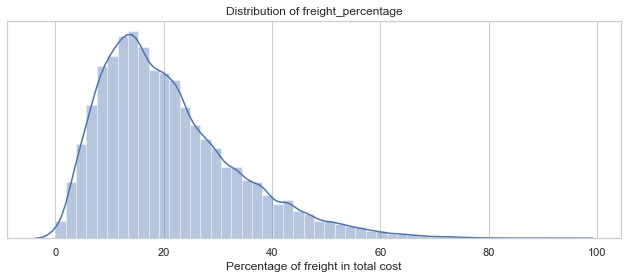

Pourcentage moyen du coût de livraison : 20


In [89]:
# calculer les coûts totaux produits et livraison
df_cart_costs = df_items.groupby(
    'order_id',
    as_index=False).agg({'product_price': ['sum'],
                         'product_freight': ['sum']})
df_cart_costs.columns = ['order_id',
                         'total_price',
                         'total_freight']
# déterminer la proportion du coût de livraison
df_cart_costs['freight_percentage'] = \
    100 * df_cart_costs['total_freight'] / \
    (df_cart_costs['total_freight'] + df_cart_costs['total_price'])
# afficher la distribution de la proportion du coût de livraison
distribution(df_cart_costs,
             'freight_percentage',
             'Percentage of freight in total cost',
             'dist')
print('Pourcentage moyen du coût de livraison : %d'
      % df_cart_costs['freight_percentage'].mean())

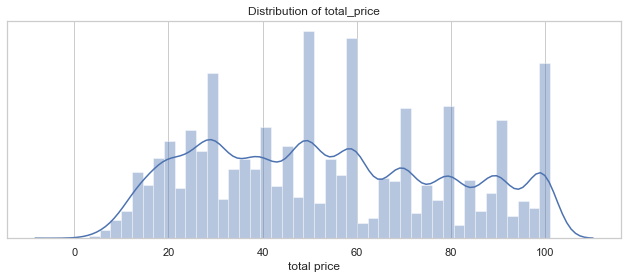

In [90]:
# afficher la distribution du total_price
distribution(df_cart_costs[df_cart_costs['total_price'] < 101],
             'total_price',
             'total price',
             'dist')

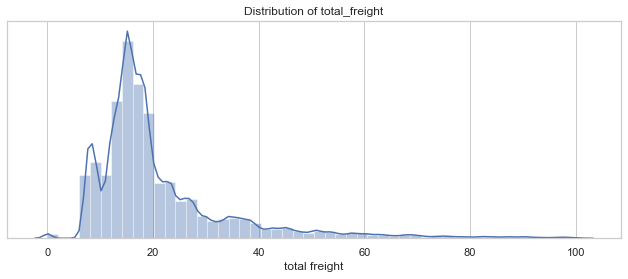

In [91]:
# afficher la distribution du total_freight
distribution(df_cart_costs[df_cart_costs['total_freight'] < 101],
             'total_freight',
             'total freight',
             'dist')

In [92]:
# scruter les commandes sans frais de livraison
df_cart_costs[df_cart_costs['total_freight'] == 0].shape

(338, 4)

In [93]:
# contrôler la pertinence des valeurs limites des niveaux
pd.qcut(df_cart_costs['freight_percentage'], 3)

0        (13.727, 23.682]
1        (-0.001, 13.727]
2        (-0.001, 13.727]
3        (23.682, 95.545]
4        (-0.001, 13.727]
               ...       
98661    (-0.001, 13.727]
98662    (-0.001, 13.727]
98663    (13.727, 23.682]
98664    (-0.001, 13.727]
98665    (13.727, 23.682]
Name: freight_percentage, Length: 98666, dtype: category
Categories (3, interval[float64]): [(-0.001, 13.727] < (13.727, 23.682] < (23.682, 95.545]]

In [94]:
# découper le pourcentage en 3 niveaux
df_cart_costs['freight_percentage_lvl'] = pd.qcut(
    df_cart_costs['freight_percentage'],
    3,
    labels=['Low_FreightCost',
            'Nominal_FreightCost',
            'High_FreightCost'])

Text(0.5, 1.02, 'Freight Levels')

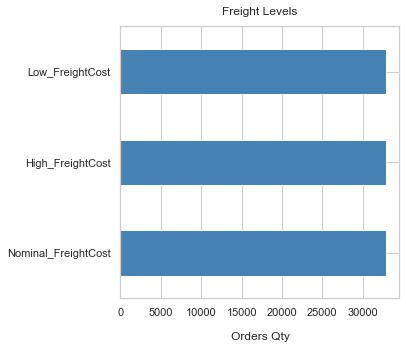

In [95]:
# observer la répartition par niveaux des commandes par cout de livraison
df_cart_costs['freight_percentage_lvl'].value_counts().plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Orders Qty', labelpad=14)
plt.title('Freight Levels', y=1.02)

In [96]:
# Observer les features créés
df_cart_costs

,order_id,total_price,total_freight,freight_percentage,freight_percentage_lvl
0,00010242fe8c5a6d1ba2dd792cb16214,58.90,13.29,18.409752,Nominal_FreightCost
1,00018f77f2f0320c557190d7a144bdd3,239.90,19.93,7.670400,Low_FreightCost
2,000229ec398224ef6ca0657da4fc703e,199.00,17.87,8.239959,Low_FreightCost
3,00024acbcdf0a6daa1e931b038114c75,12.99,12.79,49.612102,High_FreightCost
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90,18.14,8.319574,Low_FreightCost
...,...,...,...,...,...
98661,fffc94f6ce00a00581880bf54a75a037,299.99,43.41,12.641235,Low_FreightCost
98662,fffcd46ef2263f404302a634eb57f7eb,350.00,36.53,9.450754,Low_FreightCost
98663,fffce4705a9662cd70adb13d4a31832d,99.90,16.95,14.505777,Nominal_FreightCost
98664,fffe18544ffabc95dfada21779c9644f,55.99,8.72,13.475506,Low_FreightCost


In [97]:
# aggréger aux commandes les coûts totaux et pourcentage du coût de livraison
df_orders = df_orders.merge(
    df_cart_costs,
    how='left',
    left_on=['order_id'],
    right_on=['order_id'])

In [98]:
# contrôler le résultat
print(ref-df_orders.shape[0])
df_orders.sample(3)

8147


,order_id,customer_id,order_purchase_timestamp,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_dayofweek,order_purchase_hour,order_purchase_month_label,order_purchase_dayofweek_label,time_zone_hour,time_zone_day,purchase_time_zone_cat,estimated_delivery_time,effective_delivery_time,delivery_vs_estimated,delivery_vs_estimated_lvl,items_qty,products_qty,most_important_product,total_price,total_freight,freight_percentage,freight_percentage_lvl
21177,0070092bb6004faafa287e5fc35971e9,399d1e628c48b7c3b6389098be566cfd,2017-07-25 11:42:58,2017,7,25,1,11,Jul,Tue,AM,WD,AM-WD,19,2,17,Sooner_Delivery,single_item,single_product,31a2f42a87890f87d77daebdfabc182e,149.0,14.06,8.622593,Low_FreightCost
88453,44af3ebb46b0fa7f9ec19a2a3e49d3c1,4c2476d4bcf9b366b70d1616ac2ecd62,2018-06-22 21:20:56,2018,6,22,4,21,Jun,Fri,Evening,WD,Evening-WD,27,7,20,Sooner_Delivery,single_item,single_product,87aff1d9a5e94db6840c5b963a5cef90,135.0,23.75,14.960630,Nominal_FreightCost
57784,8e38e47818413e295f5b4c4af60bf0c0,a404e7de80bcea1f5192df78dda47f74,2018-06-28 16:59:36,2018,6,28,3,16,Jun,Thu,PM,WD,PM-WD,13,6,7,Later_Delivery,single_item,single_product,6adab229374835b551f6402e0dc53267,49.9,11.84,19.177195,Nominal_FreightCost


In [99]:
df_orders[df_orders['order_id'] == '00143d0f86d6fbd9f9b38ab440ac16f5']

,order_id,customer_id,order_purchase_timestamp,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_dayofweek,order_purchase_hour,order_purchase_month_label,order_purchase_dayofweek_label,time_zone_hour,time_zone_day,purchase_time_zone_cat,estimated_delivery_time,effective_delivery_time,delivery_vs_estimated,delivery_vs_estimated_lvl,items_qty,products_qty,most_important_product,total_price,total_freight,freight_percentage,freight_percentage_lvl
33339,00143d0f86d6fbd9f9b38ab440ac16f5,2e45292979b9b2700ea09560eeb0f803,2017-10-16 15:29:43,2017,10,16,0,15,Oct,Mon,PM,WD,PM-WD,20,11,9,Nominal_Delivery,multi_items,single_product,e95ee6822b66ac6058e2e4aff656071a,63.99,45.3,41.449355,High_FreightCost


In [100]:
# conserver une seule occurence de chaque commande multi-items
print(df_orders.shape)
df_orders = df_orders.drop_duplicates(
    subset='order_id',
    keep='first').copy()
print(df_orders.shape)

(91294, 24)
(91294, 24)


In [101]:
# créer / actualiser les commandes répartes par année
orders_2017 = df_orders[(df_orders['order_purchase_year'] == 2017) |
                        (df_orders['order_purchase_year'] == 2016)]
orders_2018 = df_orders[(df_orders['order_purchase_year'] == 2018)]

In [102]:
# observer la variation éventuelle entre 2017 et 2018
print('Variation freight_percentage entre 2017 (ref) et 2018 : ' +
      str(round(orders_2017['freight_percentage'].mean() - orders_2018['freight_percentage'].mean())))

Variation freight_percentage entre 2017 (ref) et 2018 : 0


### 5.1.3.  Repérage du type de prix affiché avec terminaison "9", dit "charm price".

Le prix visible est plutôt le total_price, qui correspond au product_price dans le cas d'une commande single_item, et du product_price x qty dans le cas d'une commande multi_items.

In [103]:
# détecter le charm price sur le prix total
charm_price(df_orders, 'total_price')

,order_id,customer_id,order_purchase_timestamp,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_dayofweek,order_purchase_hour,order_purchase_month_label,order_purchase_dayofweek_label,time_zone_hour,time_zone_day,purchase_time_zone_cat,estimated_delivery_time,effective_delivery_time,delivery_vs_estimated,delivery_vs_estimated_lvl,items_qty,products_qty,most_important_product,total_price,total_freight,freight_percentage,freight_percentage_lvl,charm_price
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017,10,2,0,10,Oct,Mon,AM,WD,AM-WD,15,8,7,Later_Delivery,single_item,single_product,87285b34884572647811a353c7ac498a,29.99,8.72,22.526479,Nominal_FreightCost,1
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,2018,7,24,1,20,Jul,Tue,Evening,WD,Evening-WD,19,13,5,Later_Delivery,single_item,single_product,595fac2a385ac33a80bd5114aec74eb8,118.70,22.76,16.089354,Nominal_FreightCost,0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,2018,8,8,2,8,Aug,Wed,AM,WD,AM-WD,26,9,17,Sooner_Delivery,single_item,single_product,aa4383b373c6aca5d8797843e5594415,159.90,19.22,10.730237,Low_FreightCost,1
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,2017,11,18,5,19,Nov,Sat,Evening,WE,WE,26,13,12,Nominal_Delivery,single_item,single_product,d0b61bfb1de832b15ba9d266ca96e5b0,45.00,27.20,37.673130,High_FreightCost,0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,2018,2,13,1,21,Feb,Tue,Evening,WD,Evening-WD,12,2,9,Nominal_Delivery,single_item,single_product,65266b2da20d04dbe00c5c2d3bb7859e,19.90,8.72,30.468204,High_FreightCost,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91289,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,2017-03-09 09:54:05,2017,3,9,3,9,Mar,Thu,AM,WD,AM-WD,18,8,10,Nominal_Delivery,single_item,single_product,ac35486adb7b02598c182c2ff2e05254,72.00,13.08,15.373766,Nominal_FreightCost,0
91290,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,2018-02-06 12:58:58,2018,2,6,1,12,Feb,Tue,AM,WD,AM-WD,23,22,1,Later_Delivery,single_item,single_product,f1d4ce8c6dd66c47bbaa8c6781c2a923,174.90,20.10,10.307692,Low_FreightCost,1
91291,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,2017-08-27 14:46:43,2017,8,27,6,14,Aug,Sun,PM,WE,WE,30,24,5,Later_Delivery,single_item,single_product,b80910977a37536adeddd63663f916ad,205.99,65.02,23.991735,High_FreightCost,1
91292,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,2018-01-08 21:28:27,2018,1,8,0,21,Jan,Mon,Evening,WD,Evening-WD,37,17,20,Sooner_Delivery,multi_items,single_product,d1c427060a0f73f6b889a5c7c61f2ac4,359.98,81.18,18.401487,Nominal_FreightCost,1


In [104]:
# prix total moyens avec ou sans Charm price
df_total_price_charm = df_orders.groupby(
    'charm_price',
    as_index=False).agg({'order_id': ['count'],
                         'total_price': ['mean']})
df_total_price_charm.columns = ['charm_price',
                                'count',
                                'mean_price']
df_total_price_charm.set_index('charm_price')

,count,mean_price
charm_price,,
0,27576,150.175946
1,63718,127.079837


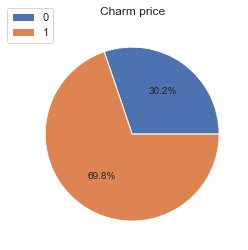

In [105]:
# observer la répartition du charm pricing à travers les produits
plt.title('Charm price', y=1.02)
plt.pie(df_total_price_charm['count'], autopct='%1.1f%%')
plt.legend(df_total_price_charm.index, loc='center left', bbox_to_anchor=(-0.1, 1.))

Tandis qu'il y a plus de références en Charm Price, on observe qu'il s'agit en moyenne d'articles moins coûteux, cela reletivisera l'impact du Charm Price sur les ventes.

In [106]:
# découper le prix total en classe
bins = [0, 10, 20, 50, 100, 200, 500, 1000, np.inf]
values = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
df_orders['total_price_lvl'] = pd.cut(df_orders['total_price'], bins, labels=values)

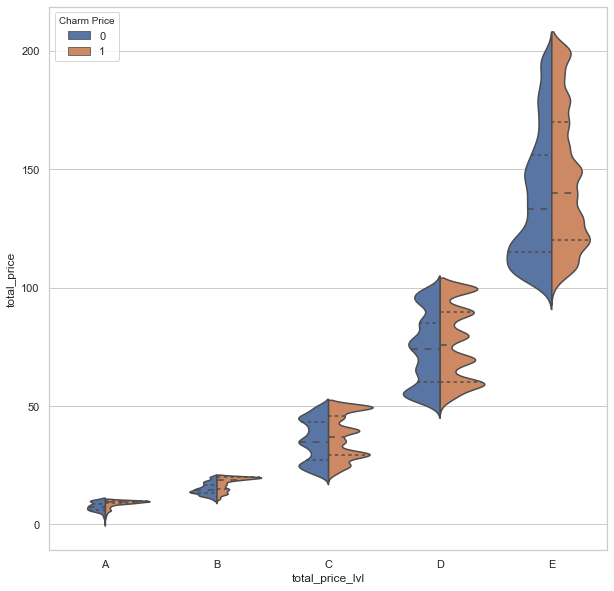

In [107]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.violinplot(x='total_price_lvl',
                    y='total_price',
                    hue='charm_price',
                    data=df_orders[df_orders['total_price'] < 200],
                    order=['A', 'B', 'C', 'D', 'E'],
                    split=True,
                    inner='quartile')
plt.legend(title='Charm Price', loc='upper left')

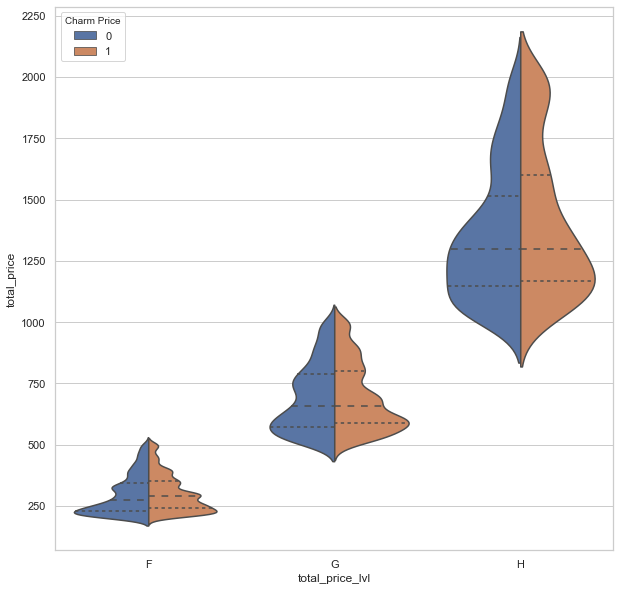

In [108]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.violinplot(x='total_price_lvl',
                    y='total_price',
                    hue='charm_price',
                    data=df_orders[df_orders['total_price'] < 2000],
                    order=['F', 'G', 'H'],
                    split=True,
                    inner='quartile')
plt.legend(title='Charm Price', loc='upper left')

Au delà des effets de seuils naturels s'agissant de prix proches des plafonds, on observe que le charm price a pour effet de relever le prix moyens d'articles bon marché, et que cet effet s'atténue voire s'inverse pour les articles plus chers.


In [109]:
# prix total moyens avec ou sans Charm price
df_total_low_price_charm = df_orders[df_orders['total_price'] < 200].groupby(
    'charm_price',
    as_index=False).agg({'order_id': ['count'],
                         'total_price': ['mean']})
df_total_low_price_charm.columns = ['charm_price',
                                    'count',
                                    'mean_price']
df_total_low_price_charm.set_index('charm_price')

,count,mean_price
charm_price,,
0,22491,80.242703
1,55617,80.203538


On relève plusieurs points d'équilibre des prix moyens, (ici [0, 200]), qui confirment cette observation.

In [110]:
# dériver un feature purement catégoriel pour le Charm Price
df_orders['charmed_price_cat'] =\
    df_orders['charm_price'].map(
    lambda x: 'Charmed_Price' if x == 1 else 'Uncharmed_Price')

## 5.2. Products

Ce dataset permet d'accéder aux caractéristiques des produits achetés.

In [111]:
# aperçu des données Products
print(df_products.shape)
df_products.head(3)

(32951, 9)


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0


In [112]:
# retirer les valeurs manquantes et controler la taille résultante
df_products = df_products.dropna().copy()
print(df_products.shape)

(32340, 9)


In [113]:
# renommer les colonnes lenght -> length
df_products = df_products.rename(columns={
    'product_name_lenght': 'product_name_length',
    'product_description_lenght': 'product_description_length'})

### 5.2.1.  Taille de l'article (volume)

In [114]:
# simplifier la taille des produits (volume)
df_products['product_size'] = df_products['product_length_cm'] * \
    df_products['product_height_cm'] * df_products['product_width_cm']
# retirer le détail
df_products = df_products.drop(
    columns=['product_length_cm',
             'product_height_cm',
             'product_width_cm'])

In [115]:
# observer les valeurs numériques
df_products.describe()

,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_size
count,32340.000000,32340.000000,32340.000000,32340.000000,32340.000000
mean,48.476592,771.492393,2.188961,2276.956586,16577.961286
std,10.245699,635.124831,1.736787,4279.291845,27062.978147
min,5.000000,4.000000,1.000000,0.000000,168.000000
25%,42.000000,339.000000,1.000000,300.000000,2880.000000
50%,51.000000,595.000000,1.000000,700.000000,6860.000000
75%,57.000000,972.000000,3.000000,1900.000000,18522.750000
max,76.000000,3992.000000,20.000000,40425.000000,296208.000000


In [116]:
# compter les valeurs manquantes
df_products.isna().sum()

product_id                    0
product_category_name         0
product_name_length           0
product_description_length    0
product_photos_qty            0
product_weight_g              0
product_size                  0
dtype: int64

In [117]:
# retirer les valeurs manquantes
df_products = df_products.dropna().copy()
print(df_products.shape[0])

32340


### 5.2.2.  Catégorisation des produits par type de description : taille de description, de nom, nombre de photos

#### Product Description Length

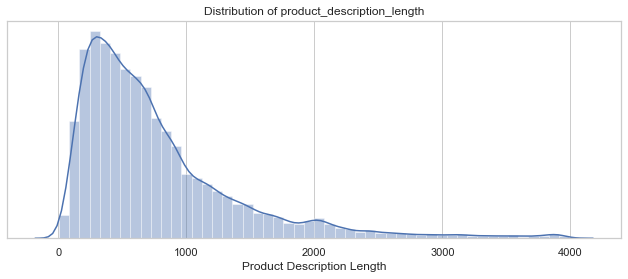

Taille moyenne de la description produit : 771


In [118]:
# observer le product_description_length
distribution(df_products,
             'product_description_length',
             'Product Description Length',
             'dist')
print('Taille moyenne de la description produit : %d'
      % df_products['product_description_length'].mean())

#### Product Name Length

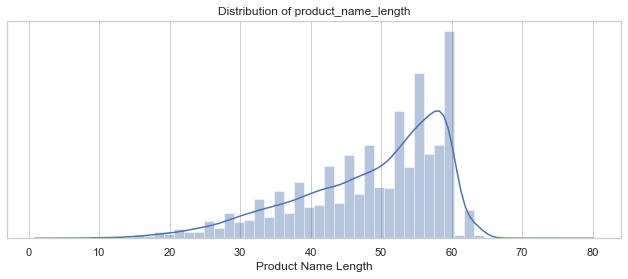

Taille moyenne nom du produit : 48


In [119]:
# observer le taille du nom de produit
distribution(df_products,
             'product_name_length',
             'Product Name Length',
             'dist')
print('Taille moyenne nom du produit : %d'
      % df_products['product_name_length'].mean())

#### Photo Quantity

Text(0.5, 1.02, 'Photos Qty Levels')

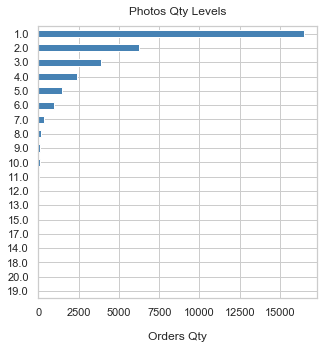

In [120]:
# observer la répartition des nb de photos
df_products['product_photos_qty'].value_counts().plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Orders Qty', labelpad=14)
plt.title('Photos Qty Levels', y=1.02)

In [121]:
# simplifier en aggrégeant au delà de 6 photos
bins = [0, 1, 2, 3, 4, 5, np.inf]
values = [1, 2, 3, 4, 5, 6]
df_products['product_photos_qty_lvl'] = pd.cut(df_products['product_photos_qty'], bins, labels=values)

Text(0.5, 1.02, 'Photos Qty Levels')

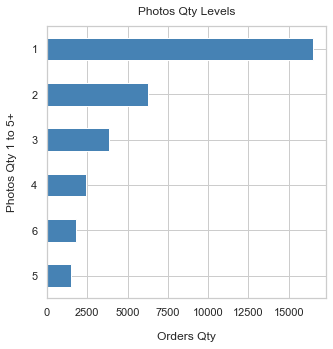

In [122]:
# observer la répartition des nb de photos
df_products['product_photos_qty_lvl'].value_counts().plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Orders Qty', labelpad=14)
plt.ylabel('Photos Qty 1 to 5+', labelpad=14)
plt.title('Photos Qty Levels', y=1.02)

### 5.2.3.   Catégorisation des produits par caractéristique taille et poids

#### Taille

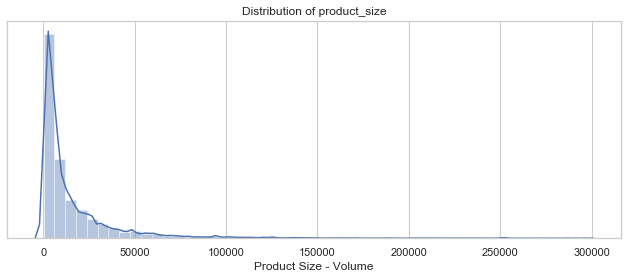

Taille moyenne des produits : 16577


In [123]:
# observer la taille des produits
distribution(df_products,
             'product_size',
             'Product Size - Volume',
             'dist')
print('Taille moyenne des produits : %d'
      % df_products['product_size'].mean())

#### Poids

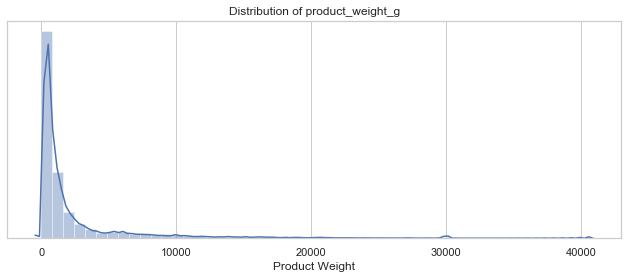

Poids moyen des produits : 2276


In [124]:
# observer le poids
distribution(df_products,
             'product_weight_g',
             'Product Weight',
             'dist')
print('Poids moyen des produits : %d'
      % df_products['product_weight_g'].mean())

In [125]:
df_products.isna().sum()

product_id                    0
product_category_name         0
product_name_length           0
product_description_length    0
product_photos_qty            0
product_weight_g              0
product_size                  0
product_photos_qty_lvl        0
dtype: int64

#### Catégories de vente des produits

La seule indication qualitative de la nature des articles est contenue dans le nom de sa catégorie de vente. On privilégie la version anglaise pour améliorer la lisibilité.

In [126]:
# exploiter la version anglaise des catégories
df_translation.sample(3)

,product_category_name,product_category_name_english
32,eletronicos,electronics
5,esporte_lazer,sports_leisure
1,informatica_acessorios,computers_accessories


In [127]:
# améliorer la lisibilité des product category
df_translation['product_category_name_english'] =\
    df_translation['product_category_name_english'].str.replace('_', ' ')
df_translation['product_category_name_english'] =\
    df_translation['product_category_name_english'].str.title()

In [128]:
# aggréger aux produits la version anglaise des catégories
df_products = df_products.merge(
    df_translation,
    how='left',
    left_on=['product_category_name'],
    right_on=['product_category_name'])
df_products.sample(3)

,product_id,product_category_name,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_size,product_photos_qty_lvl,product_category_name_english
30497,61984b4164968929229a5bed244e353d,cama_mesa_banho,53.0,396.0,3.0,850.0,12350.0,3,Bed Bath Table
31743,fb6782985a98aa8a59238f58239f6f1e,informatica_acessorios,55.0,1400.0,7.0,2500.0,20000.0,6,Computers Accessories
15453,1e8c9a649b9c92a2acf771c3168e15b8,cama_mesa_banho,45.0,759.0,1.0,9550.0,47916.0,1,Bed Bath Table


### 5.2.4.   Rationnalisation des catégories de produits

In [129]:
# décompter et lister les catégories
print(df_products['product_category_name_english'].unique().size)
df_products['product_category_name_english'].unique()

72


array(['Perfumery', 'Art', 'Sports Leisure', 'Baby', 'Housewares',
       'Musical Instruments', 'Cool Stuff', 'Furniture Decor',
       'Home Appliances', 'Toys', 'Bed Bath Table',
       'Construction Tools Safety', 'Computers Accessories',
       'Health Beauty', 'Luggage Accessories', 'Garden Tools',
       'Office Furniture', 'Auto', 'Electronics', 'Fashion Shoes',
       'Telephony', 'Stationery', 'Fashion Bags Accessories', 'Computers',
       'Home Construction', 'Watches Gifts',
       'Construction Tools Construction', 'Pet Shop', 'Small Appliances',
       'Agro Industry And Commerce', 'Furniture Living Room',
       'Signaling And Security', 'Air Conditioning', 'Consoles Games',
       'Books General Interest', 'Costruction Tools Tools',
       'Fashion Underwear Beach', 'Fashion Male Clothing',
       'Kitchen Dining Laundry Garden Furniture',
       'Industry Commerce And Business', 'Fixed Telephony',
       'Construction Tools Lights', 'Books Technical',
       'Home App

In [130]:
# denombrer les produits non catégorisés inconnues
df_products['product_category_name_english'].isna().sum()

13

In [131]:
df_products.isna().sum()

product_id                        0
product_category_name             0
product_name_length               0
product_description_length        0
product_photos_qty                0
product_weight_g                  0
product_size                      0
product_photos_qty_lvl            0
product_category_name_english    13
dtype: int64

In [132]:
df_products.describe()

,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_size
count,32340.000000,32340.000000,32340.000000,32340.000000,32340.000000
mean,48.476592,771.492393,2.188961,2276.956586,16577.961286
std,10.245699,635.124831,1.736787,4279.291845,27062.978147
min,5.000000,4.000000,1.000000,0.000000,168.000000
25%,42.000000,339.000000,1.000000,300.000000,2880.000000
50%,51.000000,595.000000,1.000000,700.000000,6860.000000
75%,57.000000,972.000000,3.000000,1900.000000,18522.750000
max,76.000000,3992.000000,20.000000,40425.000000,296208.000000


#### Effectifs des produits dans chaque catégorie de vente

In [133]:
# calculer la quantité de produits dans chaque catégorie
rows = [[i, df_products[df_products['product_category_name_english'] ==
                        i].shape[0]]
        for i in df_products['product_category_name_english'].unique()]
df_category_qty = pd.DataFrame(rows, columns=['category', 'qty'])
# trier par nb de produits décroissant
df_category_qty = df_category_qty.sort_values(by='qty',
                                              ascending=False)

In [134]:
# top 5 des catégories par nb de produits
df_category_qty[:5]

,category,qty
10,Bed Bath Table,3029
2,Sports Leisure,2867
7,Furniture Decor,2657
13,Health Beauty,2444
4,Housewares,2335


In [135]:
# aggreger aux items les produits
df_items = df_items.merge(
    df_products,
    how='left',
    left_on=['product_id'],
    right_on=['product_id'])
print(df_items.shape[0])
df_items.sample(3)

112650


,order_id,product_id,seller_id,product_price,product_freight,product_category_name,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_size,product_photos_qty_lvl,product_category_name_english
7782,ee38b45af2d4e705a88a37af7f0cda97,3e0ef3ff4fc511b36e717b18a3d080df,5a32c398a06c345440bf2a683b017ad3,44.9,7.94,livros_interesse_geral,35.0,593.0,3.0,200.0,882.0,3,Books General Interest
67201,673eb223ff385f5a14396580692d36ed,e3db46616e0d26551a86377bab9b0308,8444e55c1f13cd5c179851e5ca5ebd00,219.0,19.63,perfumaria,42.0,453.0,2.0,523.0,5440.0,2,Perfumery
85716,3d4747e5a741a90f0c60acf8ce8399a2,47ca7005be6de4f29ad906d744f6c7b0,c990d6cf976a5718aaedc539f383ab88,28.9,14.10,informatica_acessorios,29.0,1391.0,4.0,1134.0,3780.0,4,Computers Accessories


#### Quantité de produits vendus dans chaque catégorie de vente

In [136]:
# décompter les produits commandés par catégorie
df_categ_qty = df_items.groupby('product_category_name_english',
                                as_index=False).agg({'order_id': ['count']})
df_categ_qty.columns = ['product_category_name_english',
                        'count']
df_categ_qty = df_categ_qty.sort_values(by='count',
                                        ascending=False)

In [137]:
# top 5 des catégories par décompte des commandes
df_categ_qty[:5]

,product_category_name_english,count
7,Bed Bath Table,11115
43,Health Beauty,9670
65,Sports Leisure,8641
39,Furniture Decor,8334
15,Computers Accessories,7827


In [138]:
# aggreger les décompte de produits et produits commandés
df_category_qty = df_category_qty.merge(
    df_categ_qty,
    how='left',
    left_on=['category'],
    right_on=['product_category_name_english'])
df_category_qty = df_category_qty.sort_values(by='count',
                                              ascending=False)

In [139]:
# afficher les 2 quantités
pd.set_option('display.max_rows', df_category_qty.shape[0]+1)
df_category_qty

,category,qty,product_category_name_english,count
0,Bed Bath Table,3029,Bed Bath Table,11115.0
3,Health Beauty,2444,Health Beauty,9670.0
1,Sports Leisure,2867,Sports Leisure,8641.0
2,Furniture Decor,2657,Furniture Decor,8334.0
6,Computers Accessories,1639,Computers Accessories,7827.0
4,Housewares,2335,Housewares,6964.0
8,Watches Gifts,1329,Watches Gifts,5991.0
9,Telephony,1134,Telephony,4545.0
15,Garden Tools,753,Garden Tools,4347.0
5,Auto,1900,Auto,4235.0


L'ordre des quantités de produits par catégories est similaire à l'ordre des quantités de commandes effectuées dans ces catégories 

In [140]:
# rationaliser les catégories
category_mapping = {
    'Watches Gifts': 'Watches Gifts Toys',
    'Toys': 'Watches Gifts Toys',
    'Food Drink': 'Food Drink & Pets',
    'Food': 'Food Drink & Pets',
    'Drinks': 'Food Drink & Pets',
    'Flowers': 'Food Drink & Pets',
    'Pet Shop': 'Food Drink & Pets',
    'Baby': 'Health Beauty Baby',
    'Health Beauty': 'Health Beauty Baby',
    'Perfumery': 'Health Beauty Baby',
    'Diapers And Hygiene': 'Health Beauty Baby',
    'Bed Bath Table': 'Home Accessories',
    'Home Confort': 'Home Accessories',
    'Home Comfort 2': 'Home Accessories',
    'La Cuisine': 'Home Accessories',
    'Housewares': 'Home Appliances',
    'Small Appliances': 'Home Appliances',
    'Home Appliances 2': 'Home Appliances',
    'Small Appliances Home Oven And Coffee': 'Home Appliances',
    'Air Conditioning': 'Home Appliances',
    'Consoles Games': 'Entertainement',
    'Art': 'Entertainement',
    'Cine Photo': 'Entertainement',
    'Books General Interest': 'Entertainement',
    'Cds Dvds Musicals': 'Entertainement',
    'Music': 'Entertainement',
    'Books Technical': 'Entertainement',
    'Audio': 'Entertainement',
    'Dvds Blu Ray': 'Entertainement',
    'Books Imported': 'Entertainement',
    'Arts And Craftmanship': 'Entertainement',
    'Musical Instruments': 'Entertainement',
    'Fashion Male Clothing': 'Fashion',
    'Fashion Sport': 'Fashion',
    'Fashion Underwear Beach': 'Fashion',
    'Fashion Bags Accessories': 'Fashion',
    'Fashio Female Clothing': 'Fashion',
    'Fashion Shoes': 'Fashion',
    'Fashion Childrens Clothes': 'Fashion',
    'Luggage Accessories': 'Fashion',
    'Kitchen Dining Laundry Garden Furniture': 'Furniture',
    'Furniture Decor': 'Furniture',
    'Office Furniture': 'Furniture',
    'Furniture Living Room': 'Furniture',
    'Furniture Bedroom': 'Furniture',
    'Furniture Mattress And Upholstery': 'Furniture',
    'Costruction Tools Tools': 'Construction & Tools',
    'Construction Tools Safety': 'Construction & Tools',
    'Garden Tools': 'Construction & Tools',
    'Construction Tools Lights': 'Construction & Tools',
    'Construction Tools Construction': 'Construction & Tools',
    'Costruction Tools Garden': 'Construction & Tools',
    'Home Construction': 'Construction & Tools',
    'Computers Accessories': 'Electronics Computers & Accessories',
    'Computers': 'Electronics Computers & Accessories',
    'Fixed Telephony': 'Telephony',
    'Tablets Printing Image': 'Electronics Computers & Accessories',
    'Electronics': 'Electronics Computers & Accessories',
    'Agro Industry And Commerce': 'Corporate',
    'Signaling And Security': 'Corporate',
    'Security And Services': 'Corporate',
    'Industry Commerce And Business': 'Corporate',
    'Market Place': 'Corporate',
    'Stationery': 'Supplies',
    'Cool Stuff': 'Supplies',
    'Party Supplies': 'Supplies',
    'Christmas Supplies': 'Supplies'}

In [141]:
# renommer le feature des regroupement de catégories
df_category_qty = df_category_qty.rename(columns={'product_category_name_english': 'product_cat'})

In [142]:
# vérifier l'application de la correspondance
df_category_qty['product_cat'] = df_category_qty['product_cat'].replace(category_mapping)

In [143]:
# décompter les produits référencés par categorie
df_rat_categ_qty_ref = df_category_qty.groupby(
    'product_cat',
    as_index=False).agg({'qty': ['sum']})
df_rat_categ_qty_ref.columns = ['product_cat',
                                'new_qty']
df_rat_categ_qty_ref = df_rat_categ_qty_ref.sort_values(by='new_qty',
                                                        ascending=False)

[Text(0, 0.5, 'Categories'),
 Text(0.5, 0, 'Products Qty'),
 Text(0.5, 1.0, 'Products by Category')]

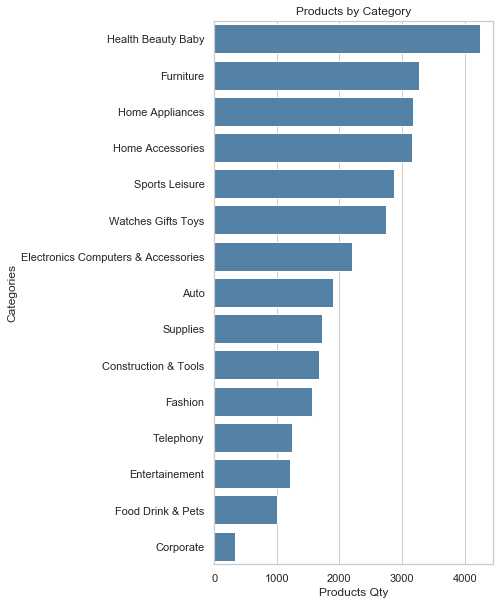

In [144]:
# contrôler la nouvelle répartition des produits référencés
fig, ax = plt.subplots(figsize=(5, 10))
ax = sns.barplot(y='product_cat',
                 x='new_qty',
                 color='Steelblue',
                 data=df_rat_categ_qty_ref)
ax.set(xlabel='Products Qty',
       ylabel='Categories',
       title='Products by Category')

In [145]:
# décompter les produits commandés par product_cat
df_rat_categ_qty = df_category_qty.groupby(
    'product_cat',
    as_index=False).agg({'count': ['sum']})
df_rat_categ_qty.columns = ['product_cat',
                            'new_count']
df_rat_categ_qty = df_rat_categ_qty.sort_values(by='new_count',
                                                ascending=False)

[Text(0, 0.5, 'Categories'),
 Text(0.5, 0, 'Orders Qty'),
 Text(0.5, 1.0, 'Orders by Category')]

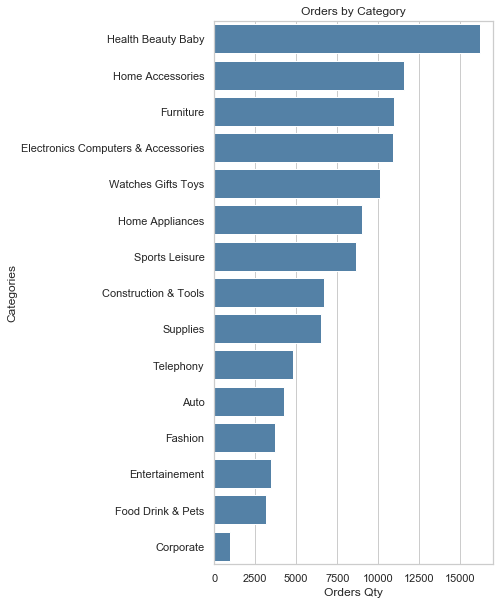

In [146]:
# contrôler la nouvelle répartition par regroupement de catégories
fig, ax = plt.subplots(figsize=(5, 10))
ax = sns.barplot(y='product_cat',
                 x='new_count',
                 color='Steelblue',
                 data=df_rat_categ_qty)
ax.set(xlabel='Orders Qty',
       ylabel='Categories',
       title='Orders by Category')

In [147]:
# renommer le feature des regroupement de catégories
df_items = df_items.rename(
    columns={'product_category_name_english': 'product_cat'})

# appliquer la correspondance sur le dataset des produits
df_items['product_cat'] =\
    df_items['product_cat'].replace(category_mapping)

# retirer l'ancienne colonne product_category_name
df_items = df_items.drop(
    columns=['product_category_name'])

In [148]:
df_items.sample(3)

,order_id,product_id,seller_id,product_price,product_freight,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_size,product_photos_qty_lvl,product_cat
101962,186517d0eb6786c1a45e1af8ac30cd28,c6f46351ae5ae5a6d75ab14996584ce1,77530e9772f57a62c906e1c21538ab82,49.0,14.10,56.0,2434.0,2.0,400.0,8349.0,2,Furniture
50313,8e5eafb4c60eec3b291d9703cca5157f,b111c38aa707bd7b20191b63b50803e3,582d4f8675b945722eda7c0cb61ba4c7,13.9,11.85,32.0,336.0,1.0,200.0,612.0,1,Electronics Computers & Accessories
32897,b560ced1765e243b3ebf765d80a8873d,372645c7439f9661fbbacfd129aa92ec,da8622b14eb17ae2831f4ac5b9dab84a,114.9,23.60,60.0,236.0,1.0,1500.0,7616.0,1,Home Accessories


In [149]:
df_items[df_items['product_id'] == 'ceb43e52119b25c8f2b6049a5534c339']

,order_id,product_id,seller_id,product_price,product_freight,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_size,product_photos_qty_lvl,product_cat
21403,cf2159bbc127ae7a92a057266d687260,ceb43e52119b25c8f2b6049a5534c339,6b243f80ed07b10f0e8aa0f21a205f3c,64.9,16.42,55.0,1392.0,1.0,750.0,4096.0,1,Sports Leisure
60975,7585d4e21b02da91dd6b9dae232f96f8,ceb43e52119b25c8f2b6049a5534c339,6b243f80ed07b10f0e8aa0f21a205f3c,64.9,15.21,55.0,1392.0,1.0,750.0,4096.0,1,Sports Leisure
84799,3f60c18dceaa348eb8891eea71a53dc1,ceb43e52119b25c8f2b6049a5534c339,6b243f80ed07b10f0e8aa0f21a205f3c,64.9,23.60,55.0,1392.0,1.0,750.0,4096.0,1,Sports Leisure
85688,3d5651800efaa81c9c96808ded6f145e,ceb43e52119b25c8f2b6049a5534c339,6b243f80ed07b10f0e8aa0f21a205f3c,64.9,15.21,55.0,1392.0,1.0,750.0,4096.0,1,Sports Leisure


In [150]:
df_items.shape[0]

112650

In [151]:
# calculer la quantité de produits référencés dans chaque nouvelle catégorie
rows = [[i, df_products[df_products['product_category_name_english'] ==
                        i].shape[0]]
        for i in df_products['product_category_name_english'].unique()]
df_category_qty = pd.DataFrame(rows, columns=['category', 'qty'])
# trier par nb de produits décroissant
df_category_qty = df_category_qty.sort_values(by='qty',
                                              ascending=False)

## 5.3. Simplification au produit le plus cher d'une commande

La stratégie est d'aggréger les informations produits aux commandes sur le produit "phare" most_important_product

In [152]:
print(ref-df_orders.shape[0])
df_orders.sample(3)

8147


,order_id,customer_id,order_purchase_timestamp,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_dayofweek,order_purchase_hour,order_purchase_month_label,order_purchase_dayofweek_label,time_zone_hour,time_zone_day,purchase_time_zone_cat,estimated_delivery_time,effective_delivery_time,delivery_vs_estimated,delivery_vs_estimated_lvl,items_qty,products_qty,most_important_product,total_price,total_freight,freight_percentage,freight_percentage_lvl,charm_price,total_price_lvl,charmed_price_cat
53291,7ad26c8f2f119d81460033a51a648dc8,ae927b68dbd3fa99d797a3e716fa5360,2018-05-08 10:48:38,2018,5,8,1,10,May,Tue,AM,WD,AM-WD,19,9,10,Nominal_Delivery,single_item,single_product,aca2eb7d00ea1a7b8ebd4e68314663af,69.9,0.00,0.000000,Low_FreightCost,1,D,Charmed_Price
87683,c54a395b5f384f7eb66433d136522b7f,73f0cc708f1defa0fe32569a96aa278c,2017-05-17 10:50:54,2017,5,17,2,10,May,Wed,AM,WD,AM-WD,25,4,20,Sooner_Delivery,single_item,single_product,776ef0ee36e20757c513e64903f1fa8a,98.0,16.45,14.373089,Nominal_FreightCost,0,D,Uncharmed_Price
46830,4d23a772e8fc588881020cd749f76c8f,3142d98ec0bda2129bacbddf0c8fdd17,2017-06-12 09:08:19,2017,6,12,0,9,Jun,Mon,AM,WD,AM-WD,29,9,20,Sooner_Delivery,single_item,single_product,9c33575aa341a769bf00ea6e3cd12e6f,15.9,15.10,48.709677,High_FreightCost,1,B,Charmed_Price


In [153]:
df_orders['most_important_product'].unique().size

29703

In [154]:
df_orders.shape[0]

91294

In [155]:
df_orders[df_orders['most_important_product'] == 'ceb43e52119b25c8f2b6049a5534c339']

,order_id,customer_id,order_purchase_timestamp,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_dayofweek,order_purchase_hour,order_purchase_month_label,order_purchase_dayofweek_label,time_zone_hour,time_zone_day,purchase_time_zone_cat,estimated_delivery_time,effective_delivery_time,delivery_vs_estimated,delivery_vs_estimated_lvl,items_qty,products_qty,most_important_product,total_price,total_freight,freight_percentage,freight_percentage_lvl,charm_price,total_price_lvl,charmed_price_cat
2918,cf2159bbc127ae7a92a057266d687260,79986e17c3a038cb24355365fc78a0e9,2018-04-13 07:50:12,2018,4,13,4,7,Apr,Fri,Night,WD,Night,27,6,21,Sooner_Delivery,single_item,single_product,ceb43e52119b25c8f2b6049a5534c339,64.9,16.42,20.191835,Nominal_FreightCost,1,D,Charmed_Price
8636,3d5651800efaa81c9c96808ded6f145e,2a882786bc3a3af530ed3405b171b09b,2017-09-16 19:36:06,2017,9,16,5,19,Sep,Sat,Evening,WE,WE,18,5,12,Nominal_Delivery,single_item,single_product,ceb43e52119b25c8f2b6049a5534c339,64.9,15.21,18.986394,Nominal_FreightCost,1,D,Charmed_Price
18267,7585d4e21b02da91dd6b9dae232f96f8,d106918f73f119d9ebf155a753135f40,2017-10-19 22:15:23,2017,10,19,3,22,Oct,Thu,Evening,WD,Evening-WD,19,5,13,Nominal_Delivery,single_item,single_product,ceb43e52119b25c8f2b6049a5534c339,64.9,15.21,18.986394,Nominal_FreightCost,1,D,Charmed_Price
72429,3f60c18dceaa348eb8891eea71a53dc1,7b0e5d9d1949bce0504d928d8897dead,2018-08-01 20:48:00,2018,8,1,2,20,Aug,Wed,Evening,WD,Evening-WD,20,7,12,Nominal_Delivery,single_item,single_product,ceb43e52119b25c8f2b6049a5534c339,64.9,23.60,26.666667,High_FreightCost,1,D,Charmed_Price


In [156]:
df_items.shape

(112650, 12)

In [157]:
# aggréger aux commandes les informations détaillées des produits
df_orders = df_orders.merge(
    df_items,
    how='left',
    left_on=['order_id',
             'most_important_product'],
    right_on=['order_id',
              'product_id'])
print(ref-df_orders.shape[0])
df_orders.sample(3)


-905


,order_id,customer_id,order_purchase_timestamp,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_dayofweek,order_purchase_hour,order_purchase_month_label,order_purchase_dayofweek_label,time_zone_hour,time_zone_day,purchase_time_zone_cat,estimated_delivery_time,effective_delivery_time,delivery_vs_estimated,delivery_vs_estimated_lvl,items_qty,products_qty,most_important_product,total_price,total_freight,freight_percentage,freight_percentage_lvl,charm_price,total_price_lvl,charmed_price_cat,product_id,seller_id,product_price,product_freight,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_size,product_photos_qty_lvl,product_cat
72446,a42e31c24c15dfa40b3b5179c811f43b,94384c84cc16bfa2d08be7bc9ed690e0,2017-11-21 19:50:54,2017,11,21,1,19,Nov,Tue,Evening,WD,Evening-WD,30,31,-2,Later_Delivery,single_item,single_product,f1b094f93ebed1272928238b76d8933b,84.9,19.83,18.934403,Nominal_FreightCost,1,D,Charmed_Price,f1b094f93ebed1272928238b76d8933b,7142540dd4c91e2237acb7e911c4eba2,84.9,19.83,57.0,404.0,4.0,800.0,8712.0,4,Fashion
10478,5a854278109ac48d0a19b5a30590af27,823ddff9dd8959511a087d391e97a76d,2018-02-16 15:30:17,2018,2,16,4,15,Feb,Fri,PM,WD,PM-WD,25,6,18,Sooner_Delivery,multi_items,single_product,f8bf29282300f0f7c655e3caf53f17ce,107.1,53.76,33.420366,High_FreightCost,0,E,Uncharmed_Price,f8bf29282300f0f7c655e3caf53f17ce,282f23a9769b2690c5dda22e316f9941,35.7,17.92,39.0,636.0,1.0,12150.0,59904.0,1,Food Drink & Pets
1813,2573400a7beba401684ca3eca5e38936,45cb012906505930fa83d7f85939a7e0,2017-03-15 21:25:00,2017,3,15,2,21,Mar,Wed,Evening,WD,Evening-WD,20,21,-2,Later_Delivery,single_item,single_product,55ebae49cf4c0963d5738a39e1e79750,139.0,15.14,9.822240,Low_FreightCost,1,E,Charmed_Price,55ebae49cf4c0963d5738a39e1e79750,2be17df1c49978426251562096c3cc09,139.0,15.14,54.0,588.0,8.0,300.0,6776.0,6,Fashion


In [158]:
# retirer les valeurs manquantes et controler la taille résultante
df_orders = df_orders.dropna().copy()
print(df_orders.shape)

(98892, 38)


In [159]:
df_orders.columns

Index(['order_id', 'customer_id', 'order_purchase_timestamp',
       'order_purchase_year', 'order_purchase_month', 'order_purchase_day',
       'order_purchase_dayofweek', 'order_purchase_hour',
       'order_purchase_month_label', 'order_purchase_dayofweek_label',
       'time_zone_hour', 'time_zone_day', 'purchase_time_zone_cat',
       'estimated_delivery_time', 'effective_delivery_time',
       'delivery_vs_estimated', 'delivery_vs_estimated_lvl', 'items_qty',
       'products_qty', 'most_important_product', 'total_price',
       'total_freight', 'freight_percentage', 'freight_percentage_lvl',
       'charm_price', 'total_price_lvl', 'charmed_price_cat', 'product_id',
       'seller_id', 'product_price', 'product_freight', 'product_name_length',
       'product_description_length', 'product_photos_qty', 'product_weight_g',
       'product_size', 'product_photos_qty_lvl', 'product_cat'],
      dtype='object')

# 6. Paiements

Un client peut choisir de payer à l'aide de plusieurs payment_type ce qui ouvre un payment_sequential >1. <br/> 
Il peut également choisir un étalement en n fois (valeur de payment_installments) dans le cas d'un paiement par carte de crédit.

In [160]:
# montrer un aperçu des données de paiement
df_payments.sample(3)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
98576,bd982aee32cd290fc0ecf05ec77c326b,1,credit_card,5,119.32
59180,9973f9740bab3248c510c83fb2a8960f,1,credit_card,1,71.78
15539,7c62935e1c4bfb9a29d419cfcc0a13e9,1,boleto,1,238.41


In [161]:
df_payments.isna().sum()

order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64

## 6.1. Type de Paiement

In [162]:
# lister les type de paiement
df_payments['payment_type'].unique()

array(['credit_card', 'boleto', 'voucher', 'debit_card', 'not_defined'],
      dtype=object)

In [163]:
df_payments['payment_type'].value_counts()

credit_card    76795
boleto         19784
voucher         5775
debit_card      1529
not_defined        3
Name: payment_type, dtype: int64

In [164]:
# identifier les types non définis
cols = ['payment_sequential',
        'payment_type',
        'payment_installments',
        'payment_value']
mask = (df_payments['payment_type'] == 'not_defined')
print(df_payments[cols][mask].shape)
df_payments[cols][mask].sample(3)

(3, 4)


,payment_sequential,payment_type,payment_installments,payment_value
57411,1,not_defined,1,0.0
94427,1,not_defined,1,0.0
51280,1,not_defined,1,0.0


In [165]:
# retirer les paiements indéfinis
df_payments = df_payments[df_payments['payment_type'] != 'not_defined']
print(df_payments.shape)

(103883, 5)


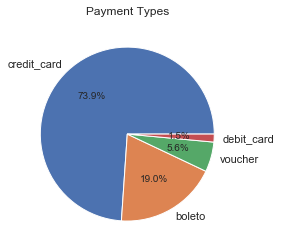

In [166]:
# observer la répartition des types de payment
plt.title('Payment Types', y=1.02)
plt.pie(df_payments['payment_type'].value_counts(),
        labels=df_payments['payment_type'].value_counts().index,
        autopct='%1.1f%%')
plt.show()

In [167]:
# ordonner les paiements par valeur décroissante
df_payments = df_payments.sort_values(by=['order_id', 'payment_value'],
                                      ascending=False)

# retenir la taille de la séquence de paiement
df_payments_details = df_payments.groupby(
    'order_id',
    as_index=False).agg({'payment_sequential': 'max',
                         'payment_installments': 'max',
                         'payment_value': 'sum'})
df_payments_details.columns = ['order_id',
                               'payment_sequence_size',
                               'payment_installments_size',
                               'payment_total']

# aggreger les détails
df_payments = df_payments.merge(
    df_payments_details,
    how='left',
    left_on=['order_id'],
    right_on=['order_id'])

# vérifier le résultat
df_payments.sample(3)

,order_id,payment_sequential,payment_type,payment_installments,payment_value,payment_sequence_size,payment_installments_size,payment_total
45301,90eb7899e0ba01c27fc128e31e0c872e,1,credit_card,1,142.68,1,1,142.68
11704,e2c37260c7a927c7d9808341dbe2924c,1,boleto,1,39.10,1,1,39.10
71892,4e574601fa03ae371593a005d9cc7a32,1,boleto,1,126.33,1,1,126.33


In [168]:
# retirer les doublons en gardant le paiement le plus important
df_payments.drop_duplicates(subset='order_id', keep='first', inplace=True)

In [169]:
# renommer les colonnes
df_payments = df_payments.rename(columns={
    'payment_type': 'main_payment_type',
    'payment_value': 'main_payment_value'})
# retirer les colonnes obsolètes
df_payments = df_payments.drop(
    columns=['payment_sequential',
             'payment_installments'])

In [170]:
# vérfier le résultat
df_payments.sample(3)

,order_id,main_payment_type,main_payment_value,payment_sequence_size,payment_installments_size,payment_total
23302,c69eeadb2be025a8483b632013bb0788,boleto,66.24,1,1,66.24
76745,42d0d6be3900c1f50190096f216695b1,credit_card,240.13,1,1,240.13
100996,071b93a866ff2f7302f456e6bba8c9c7,boleto,100.12,1,1,100.12


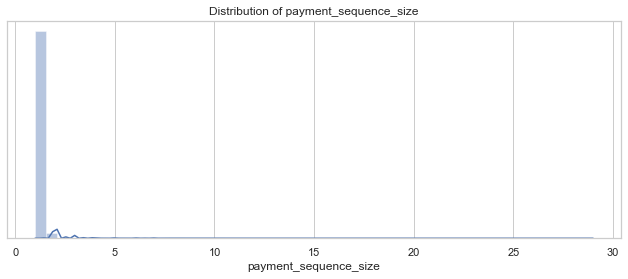

taille moyenne de la séquence de paiement : 1


In [171]:
# observer la distribution des séquences de paiement
distribution(df_payments,
             'payment_sequence_size',
             'payment_sequence_size',
             'dist')
print('taille moyenne de la séquence de paiement : %d'
      % df_payments['payment_sequence_size'].mean())

In [172]:
# dériver un feature réduits à mono_payment ou multi_payment
df_payments['payment_sequence_size_cat'] =\
    df_payments['payment_sequence_size'].map(
    lambda x: 'mono_payment' if x == 1 else 'multi_payment')

In [173]:
df_payments['payment_installments_size'].unique()

array([ 1,  3,  7,  4, 10,  2,  5,  6,  8,  9, 24, 20, 13, 15, 12, 21, 18,
       17, 22, 14, 11, 16,  0, 23], dtype=int64)

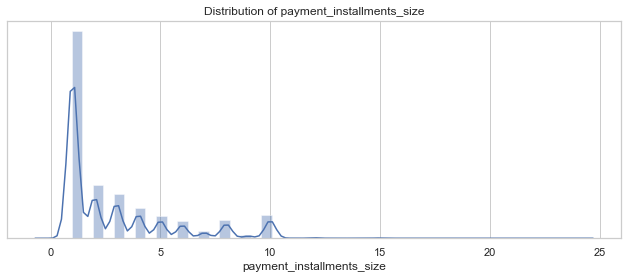

nb de versement moyens : 2


In [174]:
# observer la distribution des versements
distribution(df_payments,
             'payment_installments_size',
             'payment_installments_size',
             'dist')
print('nb de versement moyens : %d'
      % df_payments['payment_installments_size'].mean())

In [175]:
# retirer les valeurs outliers
df_payments = df_payments[df_payments['payment_installments_size'] != 0]

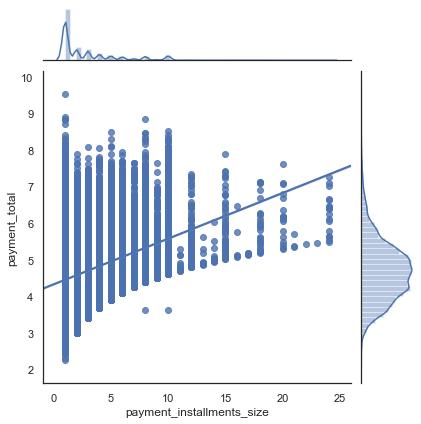

In [176]:
# évolution des nb de versements selon le montant de la commande (au log)
with sns.axes_style('white'):
    sns.jointplot(df_payments['payment_installments_size'],
                  np.log(df_payments['payment_total']),
                  data=df_payments,
                  kind='reg')
    plt.show()

sans surprise, le nb de versements augmente avec le montant, et on observe également que la possibilité de paiement en plusieurs fois est soumise au montant commandé. 

In [177]:
# dériver un feature réduits à single_payment ou installed_payment
df_payments['payment_installment_size_cat'] =\
    df_payments['payment_sequence_size'].map(
    lambda x: 'single_payment' if x == 1 else 'installed_payment')

In [178]:
# contrôler les valeurs manquantes
df_payments.isna().sum()

order_id                        0
main_payment_type               0
main_payment_value              0
payment_sequence_size           0
payment_installments_size       0
payment_total                   0
payment_sequence_size_cat       0
payment_installment_size_cat    0
dtype: int64

In [179]:
# dériver un feature réduits à 2 moyens de paiement
df_payments['main_payment_type_cat'] =\
    df_payments['main_payment_type'].map(
    lambda x: 'Credit_Card_PayType' if x == 'credit_card' else 'Other_PayType')

In [180]:
# aggreger les paiements à la commande
df_orders = df_orders.merge(
    df_payments,
    how='left',
    left_on=['order_id'],
    right_on=['order_id'])

In [181]:
# retirer les valeurs manquantes et controler la taille résultante
df_orders = df_orders.dropna().copy()
print(df_orders.shape)

(98889, 46)


## 6.2. Ventes par catégorie de produit 

[Text(0, 0.5, 'Products Categories'),
 Text(0.5, 0, 'Sales Revenue'),
 Text(0.5, 1.0, 'Sales by Category')]

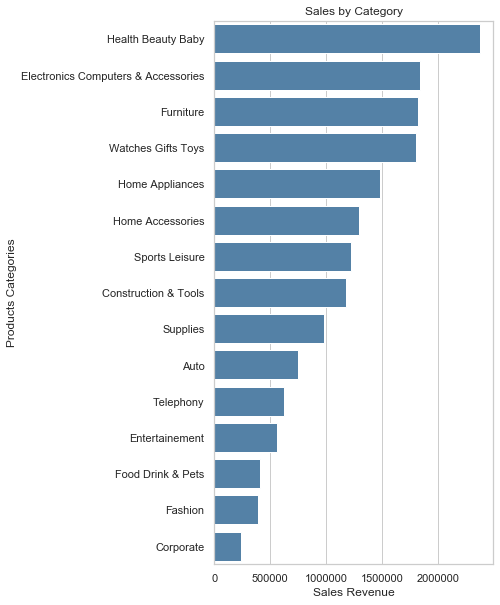

In [182]:
# répartition des ventes par catégorie de produit
df_sales_categ = df_orders.groupby(
    'product_cat',
    as_index=False).agg({'payment_total': ['sum']})
df_sales_categ.columns = ['product_cat',
                          'sales']
df_sales_categ = df_sales_categ.sort_values(by=['sales'],
                                            ascending=False)
fig, ax = plt.subplots(figsize=(5, 10))
ax = sns.barplot(y='product_cat',
                 x='sales',
                 color='Steelblue',
                 data=df_sales_categ)
ax.set(xlabel='Sales Revenue',
       ylabel='Products Categories',
       title='Sales by Category')

In [183]:
df_orders.columns

Index(['order_id', 'customer_id', 'order_purchase_timestamp',
       'order_purchase_year', 'order_purchase_month', 'order_purchase_day',
       'order_purchase_dayofweek', 'order_purchase_hour',
       'order_purchase_month_label', 'order_purchase_dayofweek_label',
       'time_zone_hour', 'time_zone_day', 'purchase_time_zone_cat',
       'estimated_delivery_time', 'effective_delivery_time',
       'delivery_vs_estimated', 'delivery_vs_estimated_lvl', 'items_qty',
       'products_qty', 'most_important_product', 'total_price',
       'total_freight', 'freight_percentage', 'freight_percentage_lvl',
       'charm_price', 'total_price_lvl', 'charmed_price_cat', 'product_id',
       'seller_id', 'product_price', 'product_freight', 'product_name_length',
       'product_description_length', 'product_photos_qty', 'product_weight_g',
       'product_size', 'product_photos_qty_lvl', 'product_cat',
       'main_payment_type', 'main_payment_value', 'payment_sequence_size',
       'payment_insta

In [184]:
# répartition des ventes en fonction du Charm price
df_sales_charm = df_orders[df_orders['total_price'] < 200].groupby(
    'charm_price',
    as_index=False).agg({'payment_total': ['sum'],
                        'order_id': ['count']})
df_sales_charm.columns = ['charm_price',
                          'sales',
                          'qty']
df_sales_charm['avg_sale'] = df_sales_charm['sales'] / df_sales_charm['qty']
df_sales_charm = df_sales_charm.sort_values(by=['avg_sale'],
                                            ascending=False)
df_sales_charm

,charm_price,sales,qty,avg_sale
0,0,2627949.95,25121,104.611677
1,1,5823156.06,57482,101.303992


Le revenu généré par les articles Charm Price n'est que le double de celui sans Charm Price, cependant qu'il sont plus de 2 fois plus souvent achetés : cela conduit à un revenu moyen des articles en Charm Price inférieur à celui des autres articles.

In [185]:
df_orders[df_orders['items_qty'] == 'multi_items'].sample(7)

,order_id,customer_id,order_purchase_timestamp,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_dayofweek,order_purchase_hour,order_purchase_month_label,order_purchase_dayofweek_label,time_zone_hour,time_zone_day,purchase_time_zone_cat,estimated_delivery_time,effective_delivery_time,delivery_vs_estimated,delivery_vs_estimated_lvl,items_qty,products_qty,most_important_product,total_price,total_freight,freight_percentage,freight_percentage_lvl,charm_price,total_price_lvl,charmed_price_cat,product_id,seller_id,product_price,product_freight,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_size,product_photos_qty_lvl,product_cat,main_payment_type,main_payment_value,payment_sequence_size,payment_installments_size,payment_total,payment_sequence_size_cat,payment_installment_size_cat,main_payment_type_cat
21003,69f300c1548bb914121c37910b3f8196,e0e201b85ad5717fb99edb6d9194795c,2017-09-29 16:22:26,2017,9,29,4,16,Sep,Fri,PM,WD,PM-WD,17,7,10,Nominal_Delivery,multi_items,single_product,fe6a9515d655fa7936b8a7c841039f34,499.8,74.74,13.008668,Low_FreightCost,1,F,Charmed_Price,fe6a9515d655fa7936b8a7c841039f34,dc317f341ab0e22f39acbd9dbf9b4a1f,249.9,37.37,29.0,266.0,3.0,5650.0,106580.0,3,Supplies,credit_card,574.54,1.0,5.0,574.54,mono_payment,single_payment,Credit_Card_PayType
14903,f861cd4fdb01ef5140e9a260279f0a26,950322a8be6e8e0e0e91516847779161,2017-05-29 09:58:04,2017,5,29,0,9,May,Mon,AM,WD,AM-WD,22,3,19,Sooner_Delivery,multi_items,single_product,6eb6618376baf873225738ce4fe760ac,104.7,45.33,30.213957,High_FreightCost,0,E,Uncharmed_Price,6eb6618376baf873225738ce4fe760ac,41b39e28db005d9731d9d485a83b4c38,34.9,15.11,44.0,331.0,1.0,300.0,5616.0,1,Home Accessories,credit_card,150.03,1.0,10.0,150.03,mono_payment,single_payment,Credit_Card_PayType
80456,74c8fc29ba64bb72272c8025c00bb85e,43cebded17ef78782f347b0bf5eaae5b,2017-11-24 12:45:07,2017,11,24,4,12,Nov,Fri,AM,WD,AM-WD,20,8,12,Nominal_Delivery,multi_items,single_product,aca66d896a36f009a83d865e61832831,149.5,63.45,29.795727,High_FreightCost,1,E,Charmed_Price,aca66d896a36f009a83d865e61832831,0adac9fbd9a2b63cccaac4f8756c1ca8,29.9,12.69,23.0,751.0,1.0,550.0,2178.0,1,Corporate,credit_card,212.95,1.0,10.0,212.95,mono_payment,single_payment,Credit_Card_PayType
83390,97c404dfeae6c85bdf1e01bee13dddf6,121d975fd057bd1856669b183a42aec3,2018-06-20 15:25:44,2018,6,20,2,15,Jun,Wed,PM,WD,PM-WD,29,12,16,Sooner_Delivery,multi_items,single_product,de3f078dec217fe7b864a4bb912fef7b,945.0,97.10,9.317724,Low_FreightCost,0,G,Uncharmed_Price,de3f078dec217fe7b864a4bb912fef7b,744dac408745240a2c2528fb1b6028f3,189.0,19.42,60.0,813.0,4.0,300.0,2112.0,4,Watches Gifts Toys,credit_card,1042.10,1.0,1.0,1042.10,mono_payment,single_payment,Credit_Card_PayType
24274,338d127554d67a15cb4e257742847056,13a6bcc8613c796033664f81fec6fc70,2018-01-31 08:51:08,2018,1,31,2,8,Jan,Wed,AM,WD,AM-WD,29,16,13,Nominal_Delivery,multi_items,single_product,672ffb2231575afa70f7fee73fe400a1,1100.0,40.58,3.557839,Low_FreightCost,0,H,Uncharmed_Price,672ffb2231575afa70f7fee73fe400a1,b3b17aab11f273023a5f22ca52e1eb70,550.0,20.29,59.0,1793.0,1.0,23200.0,352.0,1,Auto,credit_card,1140.58,1.0,3.0,1140.58,mono_payment,single_payment,Credit_Card_PayType
38728,4f68ed0836136db8064bf34ebb1965e2,08a113f40963196742d5538a95776e34,2017-08-03 13:19:56,2017,8,3,3,13,Aug,Thu,PM,WD,PM-WD,18,14,4,Later_Delivery,multi_items,single_product,ab687729e8507381d0b4aa32bef2d723,119.8,18.54,13.401764,Low_FreightCost,1,E,Charmed_Price,ab687729e8507381d0b4aa32bef2d723,6562efe88ce0826a4ca4f189f03b4b84,59.9,9.27,48.0,599.0,2.0,1200.0,9360.0,2,Furniture,credit_card,138.34,1.0,10.0,138.34,mono_payment,single_payment,Credit_Card_PayType
98510,2e180902a7c09965877711c287097421,f349d0d4c578720a500efdde105e48cc,2017-05-31 12:52:56,2017,5,31,2,12,May,Wed,AM,WD,AM-WD,26,16,10,Nominal_Delivery,multi_items,single_product,d97f2d7642b06661e99578b3455f5d58,77.7,45.30,36.829268,High_FreightCost,0,D,Uncharmed_Price,d97f2d7642b06661e99578b

## 6.3. Evolution mensuelle des ventes

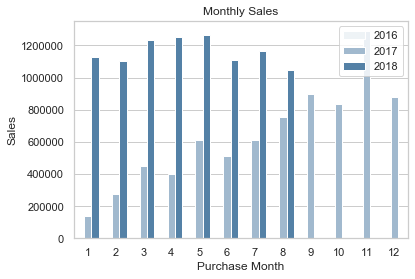

In [186]:
# évolution mensuelle des ventes
df_sales_month = df_orders.groupby(
    ['order_purchase_year', 'order_purchase_month'],
    as_index=False).agg({'payment_total': ['sum']})
df_sales_month.columns = ['order_purchase_year',
                          'order_purchase_month',
                          'sales']
ax = sns.barplot(x='order_purchase_month',
                 y='sales',
                 hue='order_purchase_year',
                 color='Steelblue',
                 data=df_sales_month)
ax.set(xlabel='Purchase Month',
       ylabel='Sales',
       title='Monthly Sales')
plt.legend(loc='upper right')

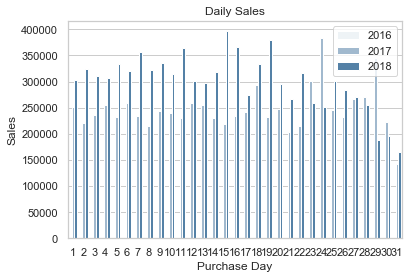

In [187]:
# évolution des ventes au cours du mois
df_sales_day = df_orders.groupby(
    ['order_purchase_year', 'order_purchase_day'],
    as_index=False).agg({'payment_total': ['sum']})
df_sales_day.columns = ['order_purchase_year',
                        'order_purchase_day',
                        'sales']
ax = sns.barplot(x='order_purchase_day',
                 y='sales',
                 hue='order_purchase_year',
                 color='Steelblue',
                 data=df_sales_day)
ax.set(xlabel='Purchase Day',
       ylabel='Sales',
       title='Daily Sales')
plt.legend(loc='upper right')

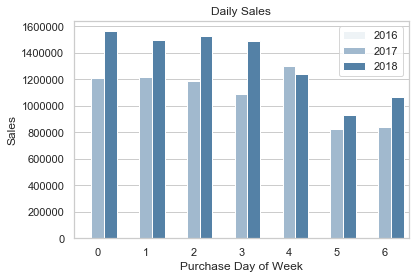

In [188]:
# évolution des ventes au cours de la semaine
df_sales_dayofweek = df_orders.groupby(
    ['order_purchase_year', 'order_purchase_dayofweek'],
    as_index=False).agg({'payment_total': ['sum']})
df_sales_dayofweek.columns = ['order_purchase_year',
                              'order_purchase_dayofweek',
                              'sales']
ax = sns.barplot(x='order_purchase_dayofweek',
                 y='sales',
                 hue='order_purchase_year',
                 color='Steelblue',
                 data=df_sales_dayofweek)
ax.set(xlabel='Purchase Day of Week',
       ylabel='Sales',
       title='Daily Sales')
plt.legend(loc='upper right')

In [189]:
df_orders['purchase_time_zone_cat']

0             AM-WD
1        Evening-WD
2             AM-WD
3                WE
4        Evening-WD
            ...    
98887         AM-WD
98888            WE
98889    Evening-WD
98890    Evening-WD
98891    Evening-WD
Name: purchase_time_zone_cat, Length: 98889, dtype: object

In [190]:
# niveau des ventes par purchase_time_zone
df_sales_time_zone = df_orders.groupby(
    ['purchase_time_zone_cat', 'order_purchase_year'],
    as_index=False).agg({'payment_total': ['sum']})
df_sales_time_zone.columns = ['purchase_time_zone_cat',
                              'order_purchase_year',
                              'sales']

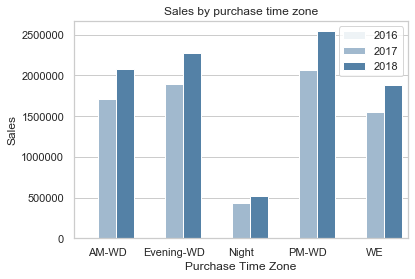

In [191]:
# afficher l'histogramme
ax = sns.barplot(x='purchase_time_zone_cat',
                 y='sales',
                 hue='order_purchase_year',
                 color='Steelblue',
                 data=df_sales_time_zone)
ax.set(xlabel='Purchase Time Zone',
       ylabel='Sales',
       title='Sales by purchase time zone')
plt.legend(loc='upper right')

## 6.4 Niveaux de paiements

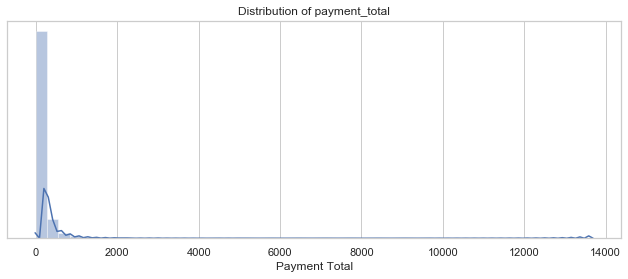

Paiements moyens  : 171


In [192]:
# observer les valeurs de paiements
distribution(df_orders,
             'payment_total',
             'Payment Total',
             'dist')
print('Paiements moyens  : %d'
      % df_orders['payment_total'].mean())

In [193]:
# répartir en niveaux de payment
df_orders['payment_lvl'] = pd.qcut(
    df_orders['payment_total'],
    4,
    labels=['Light_Payment',
            'UnderMed_Payment',
            'OverMed_Payment',
            'Heavy_Payment'])

Text(0.5, 1.02, 'Payment Levels')

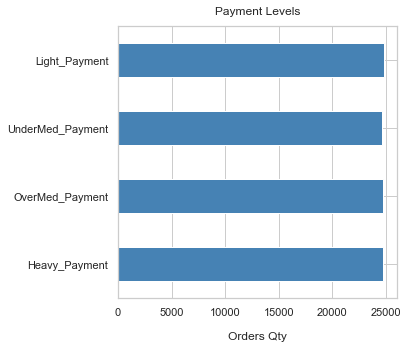

In [194]:
# observer la répartition des niveaux de payment
df_orders['payment_lvl'].value_counts(sort=False).plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Orders Qty', labelpad=14)
plt.title('Payment Levels', y=1.02)

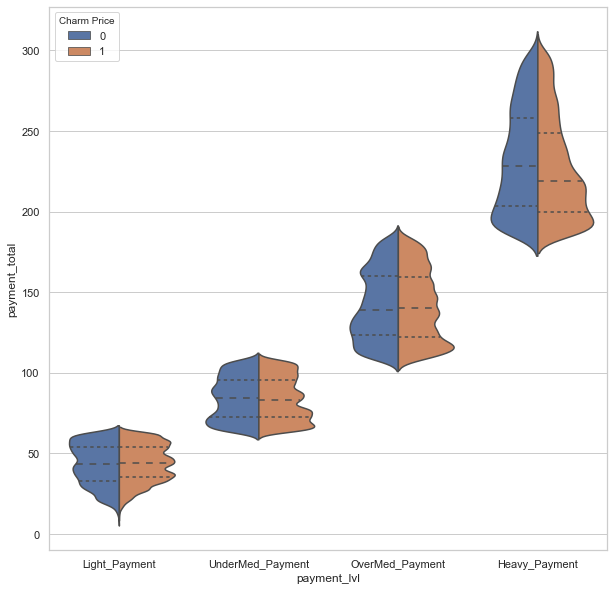

In [195]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.violinplot(x='payment_lvl',
                    y='payment_total',
                    hue='charm_price',
                    data=df_orders[(df_orders['payment_total'] < 300)],
                    split=True,
                    inner='quartile')
plt.legend(title='Charm Price', loc='upper left')

Ce type d'investigation permet de nuancer l'intérêt du Charm Price, qui dans ce cas a une efficacité variable selon la plage de dépense. Les prix élevés ne sont pas en Charm Price, les effets de seuils doivent être pris en compte, car selon le cas les dépenses sont plus ou moins élevées.

# 7. Données géographiques

Geolocation détaille toutes les paires {lat, lng}, associée à un zip_code_prefix, avec toute une diversité pour chaque {city, state}.
Pour conserver une exploitabilité et une signification marketing (zone géographiques, distances, etc.) on propose de préserver une donnée de localisation simple {lat mean, lng mean} qui sera associé à chaque ville {city, state}. <br/>
Pour dériver une distance entre le client et le vendeur, on propose de conserver les données précises.

In [196]:
# aperçu des données geolocation
df_geolocation.sample(3)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
40772,2963,-23.487336,-46.698536,sao paulo,SP
341972,14806,-21.762526,-48.168981,araraquara,SP
19573,2018,-23.494866,-46.630720,são paulo,SP


In [197]:
# observer la taille des données
df_geolocation.sample(3)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
475438,24325,-22.882507,-43.027330,niteroi,RJ
874652,85505,-26.235974,-52.672028,pato branco,PR
91147,4402,-23.669312,-46.663514,sao paulo,SP


In [198]:
# observer les zip_code unique
len(df_geolocation['geolocation_zip_code_prefix'].unique())

19015

Cette table est surabondante et indique que pour un zip_code donnée, il existe des coordonnées différentes. On testera donc s'il vaut mieux fusionner à partir du zip_code ou du couple {city, state}, selon la qualité du résultat.

In [199]:
df_geolocation.isna().sum()

geolocation_zip_code_prefix    0
geolocation_lat                0
geolocation_lng                0
geolocation_city               0
geolocation_state              0
dtype: int64

In [200]:
# aperçu des données géographiques pour customers
df_customers.sample(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_count
47055,89ce5d185f524e19ab34c90e6739aa7a,359c46ba516e74cb07fef0e173ec730d,1511,sao paulo,SP,1
89234,6c7f22d419350aa50d3ed422fe852df1,09f59cc845b71c91ee612e3103d58c6b,24730,sao goncalo,RJ,1
88761,ddf98a7aaeadf47dbd2a7fa2e82eb3ed,766c81a2c833af9ca5fa917a7f1a506f,8674,suzano,SP,1


In [201]:
df_customers.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
order_count                 0
dtype: int64

In [202]:
# aperçu des données géographiques pour sellers
df_sellers.sample(3)

,seller_id,seller_zip_code_prefix,seller_city,seller_state
1001,8629a7efec1aab257e58cda559f03ba7,74223,goiania,GO
1267,1eade46fba20122dc4aefb379f8c636b,2066,sao paulo,SP
762,70125af26c2d6d4ef401a1d02ae7701f,74435,goiania,GO


In [203]:
df_sellers.isna().sum()

seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

## 7.1. Rationalisation des données géographiques

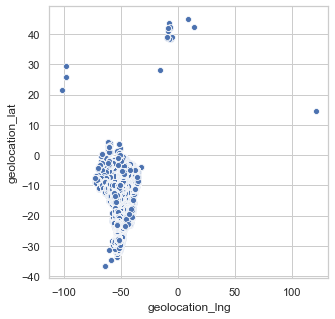

In [204]:
# afficher la répartion des localisations détaillées
fig, ax = plt.subplots(figsize=(5, 5))
ax = sns.scatterplot(x='geolocation_lng',
                     y='geolocation_lat',
                     data=df_geolocation)

In [205]:
# identifier les localisations hors Brésil
cols = ['geolocation_city',
        'geolocation_state',
        'geolocation_lat',
        'geolocation_lng']
mask = (df_geolocation['geolocation_lat'] > 10)
print(df_geolocation[cols][mask].shape)
df_geolocation[cols][mask].sample(7)

(26, 4)


,geolocation_city,geolocation_state,geolocation_lat,geolocation_lng
769351,porto trombetas,PA,42.166805,-6.898531
965687,santa lucia do piai,RS,14.585073,121.105394
516682,portela,RJ,43.684961,-7.411080
769924,castelo dos sonhos,PA,38.713128,-9.135741
387565,bom retiro da esperanca,SP,28.008978,-15.536867
860832,ilha dos valadares,PR,42.184003,-8.723762
769489,porto trombetas,PA,42.167251,-6.898559


In [206]:
# retirer les localisations marginales
df_geolocation = df_geolocation[df_geolocation['geolocation_lat'] < 10].copy()

In [207]:
# normaliser les noms de ville, et effet de la normalisation
print('geoloc cities : '
      + str(df_geolocation['geolocation_city'].unique().size))
df_geolocation['geolocation_city'] = df_geolocation['geolocation_city'].str\
    .normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
print('geoloc cities norm : '
      + str(df_geolocation['geolocation_city'].unique().size))
print('customers cities : '
      + str(df_customers['customer_city'].unique().size))
df_customers['customer_city'] = df_customers['customer_city'].str\
    .normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
print('customers cities norm : '
      + str(df_customers['customer_city'].unique().size))
print('sellers cities : '
      + str(df_sellers['seller_city'].unique().size))
df_sellers['seller_city'] = df_sellers['seller_city'].str\
    .normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
print('sellers cities norm : '
      + str(df_sellers['seller_city'].unique().size))
# améliorer la lisibilité en écriture type "title"
df_customers['customer_city'] = df_customers['customer_city'].str.title()
df_sellers['seller_city'] = df_sellers['seller_city'].str.title()
df_geolocation['geolocation_city'] = df_geolocation['geolocation_city'].str.title()

geoloc cities : 8007
geoloc cities norm : 5965
customers cities : 4119
customers cities norm : 4119
sellers cities : 611
sellers cities norm : 609


In [208]:
# simplifier par une latitude unique {ville, état}
df_geolocation['unique_city_geolocation_lat'] = df_geolocation.groupby(
    ['geolocation_city',
     'geolocation_state']
)['geolocation_lat'].transform(lambda x: x.mean())

In [209]:
# simplifier par une latitude unique {ville, état}
df_geolocation['unique_city_geolocation_lng'] = df_geolocation.groupby(
    ['geolocation_city',
     'geolocation_state']
)['geolocation_lng'].transform(lambda x: x.mean())

In [210]:
# simplifier par une latitude unique sur zip_code
df_geolocation['unique_zip_geolocation_lat'] = df_geolocation.groupby(
    ['geolocation_zip_code_prefix']
)['geolocation_lat'].transform(lambda x: x.mean())

In [211]:
# simplifier par une latitude unique sur zip_code
df_geolocation['unique_zip_geolocation_lng'] = df_geolocation.groupby(
    ['geolocation_zip_code_prefix']
)['geolocation_lng'].transform(lambda x: x.mean())

In [212]:
# observer le résultat des traitements
df_geolocation.sample(3)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,unique_city_geolocation_lat,unique_city_geolocation_lng,unique_zip_geolocation_lat,unique_zip_geolocation_lng
627878,37200,-21.241905,-44.996421,Lavras,MG,-21.244711,-44.999196,-21.244709,-44.999202
671481,40296,-12.994448,-38.483728,Salvador,BA,-12.962655,-38.461683,-12.994230,-38.480535
286209,13098,-22.820080,-47.035561,Campinas,SP,-22.900868,-47.068537,-22.816248,-47.022837


In [213]:
# conserver une seule localisation détaillée par zip_code
print('geoloc with duplicates shape : '
      + str(df_geolocation.shape))
df_unique_zip_geolocation =\
    df_geolocation.drop_duplicates(['geolocation_zip_code_prefix']).copy()
print('geoloc unique zip_code shape : '
      + str(df_unique_zip_geolocation.shape))

geoloc with duplicates shape : (1000137, 9)
geoloc unique zip_code shape : (19011, 9)


In [214]:
# conserver une seule localisation détaillée par {city, state}
print('geoloc with duplicates shape : '
      + str(df_geolocation.shape))
df_unique_city_geolocation =\
    df_geolocation.drop_duplicates(['geolocation_city',
                                    'geolocation_state']).copy()
print('geoloc unique city, state shape : '
      + str(df_unique_city_geolocation.shape))

geoloc with duplicates shape : (1000137, 9)
geoloc unique city, state shape : (6345, 9)


In [215]:
# aggréger la localisation unique pour customers sur {city, state}
df_customers = df_customers.merge(
    df_unique_city_geolocation,
    how='left',
    left_on=['customer_city', 'customer_state'],
    right_on=['geolocation_city', 'geolocation_state'])

In [216]:
df_customers.isna().sum()

customer_id                     0
customer_unique_id              0
customer_zip_code_prefix        0
customer_city                   0
customer_state                  0
order_count                     0
geolocation_zip_code_prefix    78
geolocation_lat                78
geolocation_lng                78
geolocation_city               78
geolocation_state              78
unique_city_geolocation_lat    78
unique_city_geolocation_lng    78
unique_zip_geolocation_lat     78
unique_zip_geolocation_lng     78
dtype: int64

In [217]:
# réagencer les colonnes customers
df_customers = df_customers.rename(columns={
    'unique_city_geolocation_lat': 'customer_lat',
    'unique_city_geolocation_lng': 'customer_lng'})
df_customers = df_customers.drop(
    columns=['customer_zip_code_prefix',
             'geolocation_zip_code_prefix',
             'unique_zip_geolocation_lng',
             'unique_zip_geolocation_lat',
             'geolocation_city',
             'geolocation_state',
             'geolocation_lat',
             'geolocation_lng'])

In [218]:
# retirer les valeurs manquantes et controler la taille résultante
print(df_customers.shape)
df_customers = df_customers.dropna().copy()
print(df_customers.shape)

(99441, 7)
(99363, 7)


In [219]:
# aggréger la localisation unique pour sellers sur zip_code
df_sellers = df_sellers.merge(
    df_unique_zip_geolocation,
    how='left',
    left_on=['seller_zip_code_prefix'],
    right_on=['geolocation_zip_code_prefix'])

In [220]:
# réagencer les colonnes sellers (idem customers)
df_sellers = df_sellers.rename(columns={
    'unique_zip_geolocation_lat': 'seller_lat',
    'unique_zip_geolocation_lng': 'seller_lng'})
df_sellers = df_sellers.drop(
    columns=['seller_zip_code_prefix',
             'unique_city_geolocation_lat',
             'unique_city_geolocation_lng',
             'geolocation_zip_code_prefix',
             'geolocation_city',
             'geolocation_state',
             'geolocation_lat',
             'geolocation_lng'])

In [221]:
# contrôler les valeurs manquantes
df_sellers.isna().sum()

seller_id       0
seller_city     0
seller_state    0
seller_lat      7
seller_lng      7
dtype: int64

In [222]:
# retirer les valeurs manquantes et controler la taille résultante
print(df_sellers.shape)
df_sellers = df_sellers.dropna().copy()
print(df_sellers.shape)

(3095, 5)
(3088, 5)


In [223]:
# observer le résultat pour sellers
df_sellers.sample(3)

,seller_id,seller_city,seller_state,seller_lat,seller_lng
877,715bbd5ba4e6b74cb0d2f29eb45058b0,Serra Negra,SP,-22.614621,-46.709593
1860,ae45df84722b1d15c5f32b23a095746c,Sao Paulo,SP,-23.541084,-46.589429
1508,2e3be8a987a30d7544dbbda6861cc14e,Belo Horizonte,MG,-19.983319,-44.001374


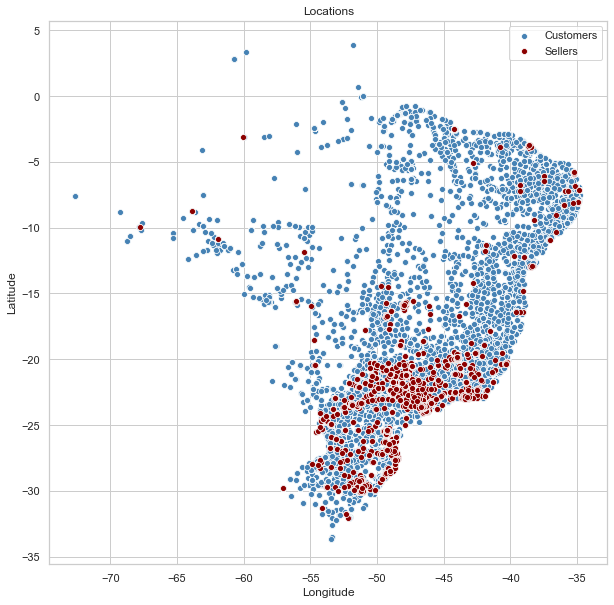

In [224]:
# affichier la nouvelle répartion (carte)
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(x='customer_lng',
                y='customer_lat',
                color='steelblue',
                data=df_customers,
                label='Customers')
sns.scatterplot(x='seller_lng',
                y='seller_lat',
                color='darkred',
                data=df_sellers,
                label='Sellers')
plt.title('Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [225]:
# retirer les colonnes obsolètes ?
df_sellers.columns

Index(['seller_id', 'seller_city', 'seller_state', 'seller_lat', 'seller_lng'], dtype='object')

In [226]:
# aggréger aux commandes les localisations customers et sellers
df_orders = df_orders.merge(
    df_sellers,
    how='left',
    left_on=['seller_id'],
    right_on=['seller_id'])
df_orders = df_orders.merge(
    df_customers,
    how='left',
    left_on=['customer_id'],
    right_on=['customer_id'])

In [227]:
df_orders.isna().sum()

order_id                            0
customer_id                         0
order_purchase_timestamp            0
order_purchase_year                 0
order_purchase_month                0
order_purchase_day                  0
order_purchase_dayofweek            0
order_purchase_hour                 0
order_purchase_month_label          0
order_purchase_dayofweek_label      0
time_zone_hour                      0
time_zone_day                       0
purchase_time_zone_cat              0
estimated_delivery_time             0
effective_delivery_time             0
delivery_vs_estimated               0
delivery_vs_estimated_lvl           0
items_qty                           0
products_qty                        0
most_important_product              0
total_price                         0
total_freight                       0
freight_percentage                  0
freight_percentage_lvl              0
charm_price                         0
total_price_lvl                     0
charmed_pric

cette aggrégation minimise les données manquantes, mais de nouvelles données sont perdues du fait de l'absence de données de géolocalisation pour les id de clients et vendeurs.

In [228]:
# retirer les valeurs manquantes et controler la taille résultante
print(df_orders.shape)
df_orders = df_orders.dropna().copy()
print(df_orders.shape)

(98889, 57)
(98589, 57)


In [229]:
df_orders.sample(7)

,order_id,customer_id,order_purchase_timestamp,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_dayofweek,order_purchase_hour,order_purchase_month_label,order_purchase_dayofweek_label,time_zone_hour,time_zone_day,purchase_time_zone_cat,estimated_delivery_time,effective_delivery_time,delivery_vs_estimated,delivery_vs_estimated_lvl,items_qty,products_qty,most_important_product,total_price,total_freight,freight_percentage,freight_percentage_lvl,charm_price,total_price_lvl,charmed_price_cat,product_id,seller_id,product_price,product_freight,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_size,product_photos_qty_lvl,product_cat,main_payment_type,main_payment_value,payment_sequence_size,payment_installments_size,payment_total,payment_sequence_size_cat,payment_installment_size_cat,main_payment_type_cat,payment_lvl,seller_city,seller_state,seller_lat,seller_lng,customer_unique_id,customer_city,customer_state,order_count,customer_lat,customer_lng
87442,e24482f15e14b7c0adfe34b1c0542e43,381408c4cb32738d5008a1bfd66d6e4c,2017-08-11 20:05:11,2017,8,11,4,20,Aug,Fri,Evening,WD,Evening-WD,23,13,9,Nominal_Delivery,single_item,single_product,6803077179d24889430188e03fafd31a,16.90,15.10,47.187500,High_FreightCost,1,B,Charmed_Price,6803077179d24889430188e03fafd31a,128639473a139ac0f3e5f5ade55873a5,16.90,15.10,48.0,287.0,1.0,100.0,3312.0,1,Electronics Computers & Accessories,credit_card,32.00,1.0,1.0,32.00,mono_payment,single_payment,Credit_Card_PayType,Light_Payment,Maringa,PR,-23.431131,-51.918235,28da99e178f274876e3052c1740c6c87,Paranapanema,SP,2.0,-23.390520,-48.739125
29743,64930a85c555750a1f71af3d49b0c54b,6bdc6bd2a184acd029712b3ab0037565,2018-05-01 17:20:54,2018,5,1,1,17,May,Tue,PM,WD,PM-WD,21,15,6,Later_Delivery,single_item,single_product,c706d50b57c9e83293c2586d01f32445,49.99,18.28,26.776036,High_FreightCost,1,C,Charmed_Price,c706d50b57c9e83293c2586d01f32445,7ecd59e5e20407131822c1a68ac59c1f,49.99,18.28,60.0,310.0,3.0,600.0,4200.0,3,Supplies,credit_card,68.27,1.0,1.0,68.27,mono_payment,single_payment,Credit_Card_PayType,UnderMed_Payment,Brasilia,DF,-15.786284,-47.889118,5f45aa4ef9b8fb99b95d33a970bb64a7,Sao Paulo,SP,3.0,-23.571253,-46.633911
38403,8ec55bc714dc23ff93908bdaf8b97704,a2c6cf15697f03b627807d18d51f0c37,2018-01-19 11:46:16,2018,1,19,4,11,Jan,Fri,AM,WD,AM-WD,16,5,11,Nominal_Delivery,single_item,single_product,54d9ac713e253fa1fae9c8003b011c2a,29.50,13.08,30.718647,High_FreightCost,1,C,Charmed_Price,54d9ac713e253fa1fae9c8003b011c2a,955fee9216a65b617aa5c0531780ce60,29.50,13.08,57.0,787.0,8.0,1867.0,7776.0,6,Supplies,boleto,42.58,1.0,1.0,42.58,mono_payment,single_payment,Other_PayType,Light_Payment,Sao Paulo,SP,-23.691013,-46.703810,e7468e276500e0e19d73bde2b165c476,Piracicaba,SP,1.0,-22.725841,-47.646622
34459,2bd6a9cea9df97f5f2d0717bb6307f32,bbfcd35b7bde08b872286d6b3d74e254,2018-05-02 22:35:34,2018,5,2,2,22,May,Wed,Evening,WD,Evening-WD,22,12,9,Nominal_Delivery,single_item,single_product,422879e10f46682990de24d770e7f83d,53.90,0.00,0.000000,Low_FreightCost,1,D,Charmed_Price,422879e10f46682990de24d770e7f83d,1f50f920176fa81dab994f9023523100,53.90,0.00,56.0,348.0,2.0,1550.0,19800.0,2,Construction & Tools,credit_card,53.90,1.0,1.0,53.90,mono_payment,single_payment,Credit_Card_PayType,Light_Payment,Sao Jose Do Rio Preto,SP,-20.806707,-49.389165,8b562fe20fc1a0a18898b2dcd62008d5,Araras,SP,1.0,-22.357746,-47.375546
4029,da60e4caa4c6e303002f33c304011591,73038e9f26a27fc56631416306bd7829,2017-11-13 08:04:09,2017,11,13,0,8,Nov,Mon,AM,WD,AM-WD,24,9,15,Sooner_Delivery,single_item,single_product,e84997d75938765ef99930f908ceedf4,127.00,14.62,10.323401,Low_FreightCost,0,E,Uncharmed_Price,e84997d75938765ef99930f908ceedf4,cd6efc47efaabf134f8bdb654e10b4f1,127.00,14.62,52.0,431.0,1.0,1900.0,21168.0,1,Supplies,credit_card,141.62,1.0,5.0,141.62,mono_payment,single_payment,Credit_Card_PayType,OverMed_Payment,Rio De Janeiro,RJ,-22.906374,-43.566410,c3ddcb8cafa47711e96ff4852fc7e52c,Praia Grande,SP

## 7.2. Distance Customer - Seller

Au vu de la virtualisation apportée par le e-commerce, on peut se demander si la notion distance est transparente pour les clients. On émet ici l'hypothèse que la localisation d'un vendeur correspond à celle de ses marchandises.

In [230]:
# calculer une distance entre customer et seller
df_orders['cust_sell_dist'] = \
    haversine(df_orders['customer_lat'],
              df_orders['customer_lng'],
              df_orders['seller_lat'],
              df_orders['seller_lng'])

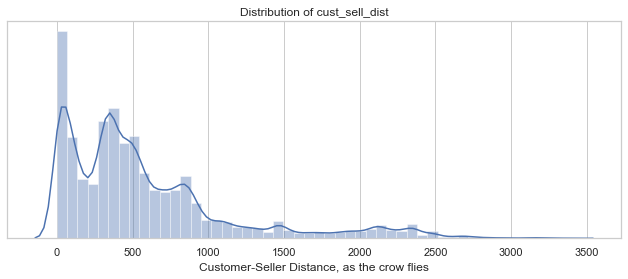

Distance moyenne entre Client et Vendeur : 589


In [231]:
# afficher la distribution de la distance sellers - customers
distribution(df_orders,
             'cust_sell_dist',
             'Customer-Seller Distance, as the crow flies',
             'dist')
print('Distance moyenne entre Client et Vendeur : %d'
      % df_orders['cust_sell_dist'].mean())

In [232]:
# créer / actualiser les commandes répartes par année
orders_2017 = df_orders[(df_orders['order_purchase_year'] == 2017) |
                        (df_orders['order_purchase_year'] == 2016)]
orders_2018 = df_orders[(df_orders['order_purchase_year'] == 2018)]

In [233]:
# observer la variation éventuelle entre 2017 et 2018
print('Variation distance acheteur-vendeur entre 2017 (ref) et 2018 : ' +
      str(round(orders_2017['cust_sell_dist'].mean() - orders_2018['cust_sell_dist'].mean())))

Variation distance acheteur-vendeur entre 2017 (ref) et 2018 : 49


on observe un éloignement géographique, peut-être lié à la popularité de la market-place au dela des zones d'origine : clients ou vendeurs plus éloignés des centres économiques.

In [234]:
# variation de la distance client - vendeur
df_orders['cust_sell_dist'].describe()

count    98589.000000
mean       589.652729
std        580.514935
min          0.000000
25%        177.367814
50%        428.863777
75%        786.518723
max       3397.283980
Name: cust_sell_dist, dtype: float64

In [235]:
# limites en cas de découpage en 3 niveaux
pd.qcut(df_orders['cust_sell_dist'], 3)

0          (-0.001, 302.391]
1        (617.392, 3397.284]
2         (302.391, 617.392]
3        (617.392, 3397.284]
4          (-0.001, 302.391]
                ...         
98884     (302.391, 617.392]
98885    (617.392, 3397.284]
98886     (302.391, 617.392]
98887     (302.391, 617.392]
98888    (617.392, 3397.284]
Name: cust_sell_dist, Length: 98589, dtype: category
Categories (3, interval[float64]): [(-0.001, 302.391] < (302.391, 617.392] < (617.392, 3397.284]]

In [236]:
# découper en 3 niveaux de distance
df_orders['cust_sell_dist_lvl'] = pd.qcut(
    df_orders['cust_sell_dist'],
    3,
    labels=['Near_Dist',
            'AroundMed_Dist',
            'Far_Dist'])

Text(0.5, 1.02, 'Customer-Seller Distance Levels')

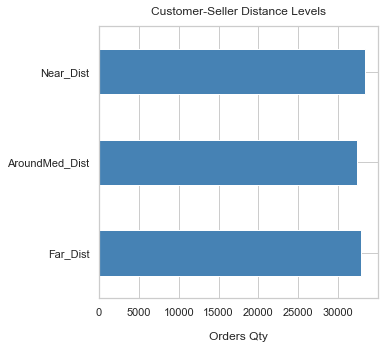

In [237]:
# contrôler la répartition des niveaux de distance
df_orders['cust_sell_dist_lvl'].value_counts(sort=False).plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Orders Qty', labelpad=14)
plt.title('Customer-Seller Distance Levels', y=1.02)

# 8. Review

Une review permet de remonter à la commande, mais pas au produit évalué, ce qui compromet l'exploitation détaillée.

In [238]:
# montrer un aperçu des review
df_reviews.sample(3)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
95249,92d910adbec09eaafdfc6f969cbf22a2,cbf5771b59c1f5688a8f8224f08607eb,5,NaN,NaN,2018-05-04 00:00:00,2018-05-07 19:40:41
74524,0b7c43d32f17394413fa603325c54c2c,ac75a9ba33bcc9cefc7e36b0f4cc044a,3,NaN,NaN,2017-12-19 00:00:00,2017-12-19 20:11:07
79556,a031ab4274251ad9a93e86003b6e9bbc,edf195e14f83b9753f2cf2f7263f279e,5,NaN,NaN,2018-08-22 00:00:00,2018-08-22 11:15:49


In [239]:
df_reviews.isna().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       88285
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

In [240]:
# valeur possible des review score
df_reviews['review_score'].unique()

array([4, 5, 1, 3, 2], dtype=int64)

On ne dispose que des produits (bien) évalués !

In [241]:
# nb de commandes unique dans les données de review
df_reviews['order_id'].unique().size

99441

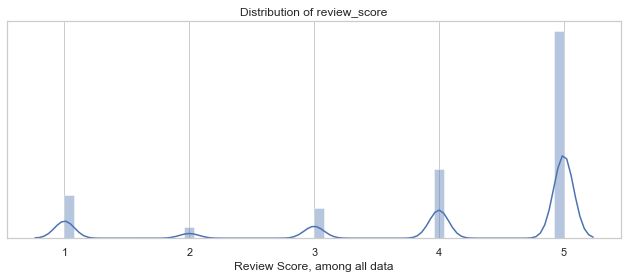

Average Review Score : 4


In [242]:
# afficher la distribution des review_score
distribution(df_reviews,
             'review_score',
             'Review Score, among all data',
             'dist')
print('Average Review Score : %d'
      % df_reviews['review_score'].mean())

Text(0.5, 1.02, 'review_score')

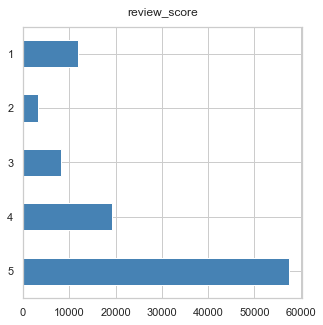

In [243]:
# observer la répartition des review scores
df_reviews['review_score'].value_counts(sort=False).plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.title('review_score', y=1.02)

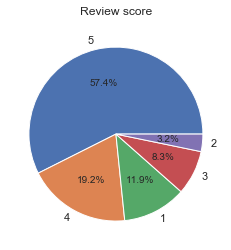

In [244]:
# observer la répartition des types de payment
plt.title('Review score', y=1.02)
plt.pie(df_reviews['review_score'].value_counts(),
        labels=df_reviews['review_score'].value_counts().index,
        autopct='%1.1f%%')
plt.show()

Une exploitation plus fine consisterait à valoriser la longueur du titre et du commentaire pour un aspect plus qualitatif.

## 8.1. Délai de réponse suite à une demande de review
Comportement évaluateur d'un client : délai de réponse.

In [245]:
# formater les champs date
for col in ['review_creation_date', 'review_answer_timestamp']:
    df_reviews[col] = pd.to_datetime(df_reviews[col], format='%Y-%m-%d %H:%M:%S')

In [246]:
df_reviews.isna().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       88285
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

In [247]:
# ordonner les reviews par valeur décroissante de dates
df_reviews = df_reviews.sort_values(by=['order_id', 'review_answer_timestamp'],
                                    ascending=False)

In [248]:
# retirer les doublons en gardant la review la plus récente
df_reviews.drop_duplicates(subset='order_id', keep='first', inplace=True)

In [249]:
# contrôler le traitement
print(df_reviews.shape[0] - df_reviews['order_id'].unique().size)

0


In [250]:
# calculer le délai de réponse (demande d'ajout d'une review)
df_reviews['review_answer_delay'] =\
    (df_reviews['review_answer_timestamp'] - df_reviews['review_creation_date']).dt.days

In [251]:
# retirer les colonnes obsolètes
df_reviews = df_reviews.drop(
    columns=['review_id',
             'review_comment_title',
             'review_comment_message',
             'review_answer_timestamp',
             'review_creation_date'])

In [252]:
# vérification du résultat
df_reviews.sample(3)

,order_id,review_score,review_answer_delay
40503,fd5f4a26279e437735f4d5da152f5295,5,4
13213,99ca85d0497f1b958fabcd12b46168e6,5,5
55622,27b286dd0016893043cae6da2f07a2a5,5,1


In [253]:
df_reviews.isna().sum()

order_id               0
review_score           0
review_answer_delay    0
dtype: int64

In [254]:
df_reviews.describe()

,review_score,review_answer_delay
count,99441.000000,99441.000000
mean,4.070796,2.584186
std,1.359783,9.884802
min,1.000000,0.000000
25%,4.000000,1.000000
50%,5.000000,1.000000
75%,5.000000,3.000000
max,5.000000,518.000000


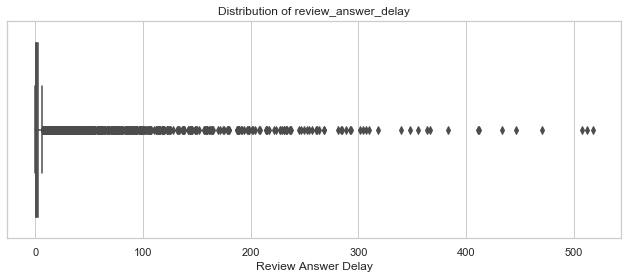

Average Review Answer Delay : 2


In [255]:
# afficher la distribution des délais de réponse
distribution(df_reviews,
             'review_answer_delay',
             'Review Answer Delay',
             'box')
print('Average Review Answer Delay : %d'
      % df_reviews['review_answer_delay'].mean())

In [256]:
# split en 3 niveaux de délais
df_reviews['review_answer_delay_lvl'] = pd.qcut(
    df_reviews['review_answer_delay'],
    3,
    labels=['Early_Answer',
            'Nominal_Answer',
            'Late_Answer'])

Text(0.5, 1.02, 'Review Delay ')

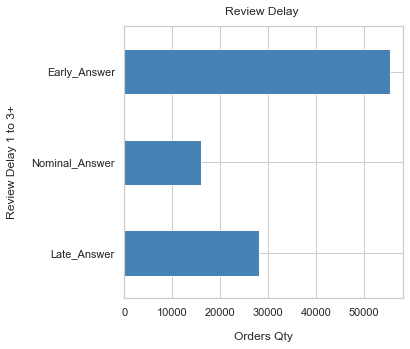

In [257]:
# nouvelle répartition des délais de réponse
df_reviews['review_answer_delay_lvl'].value_counts(sort=False).plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Orders Qty', labelpad=14)
plt.ylabel('Review Delay 1 to 3+', labelpad=14)
plt.title('Review Delay ', y=1.02)

In [258]:
# aggreger aux orders les reviews
df_orders = df_orders.merge(
    df_reviews,
    how='left',
    left_on=['order_id'],
    right_on=['order_id'])

## 8.2. Note moyenne donnée à chaque produit
Influence possible de la note d'un produit sur le comportement client (décompte et note moyenne)

In [259]:
# créer la note (décompte et moyenne)
df_prod_mean_score =\
    df_orders.groupby('product_id',
                      as_index=False).agg({'review_score': ['count',
                                                            'mean']})
df_prod_mean_score.columns = ['product_id',
                              'count',
                              'mean']

# afficher les 10 produits les plus notés
df_prod_mean_score = df_prod_mean_score.sort_values(by='count',
                                                    ascending=False)
df_prod_mean_score[:10]

,product_id,count,mean
19531,aca2eb7d00ea1a7b8ebd4e68314663af,515,4.046602
7634,422879e10f46682990de24d770e7f83d,437,4.002288
17426,99a4788cb24856965c36a24e339b6058,421,3.973872
6528,389d119b48cf3043d311335e499d9c6b,354,4.169492
6276,368c6c730842d78016ad823897a372db,341,4.058651
9562,53759a2ecddad2bb87a079a1f1519f73,327,3.984709
23861,d1c427060a0f73f6b889a5c7c61f2ac4,312,4.381410
9584,53b36df67ebb7c41585e8d54d6772e08,309,4.262136
2469,154e7e31ebfa092203795c972e5804a6,267,4.363296
7143,3dd2a17168ec895c781a9191c1e95ad7,265,4.245283


In [260]:
# retirer les colonnes obsolètes
df_orders = df_orders.drop(
    columns=['product_id'])

In [261]:
# renommer la colonne
df_prod_mean_score = df_prod_mean_score.rename(columns={
    'mean': 'product_review_mean',
    'count': 'product_review_count'})
# rattacher aux commandes la note moyenne
df_orders = df_orders.merge(
    df_prod_mean_score,
    how='left',
    left_on=['most_important_product'],
    right_on=['product_id'])

In [262]:
# retirer les colonnes redondantes
df_orders = df_orders.drop(
    columns=['product_id'])

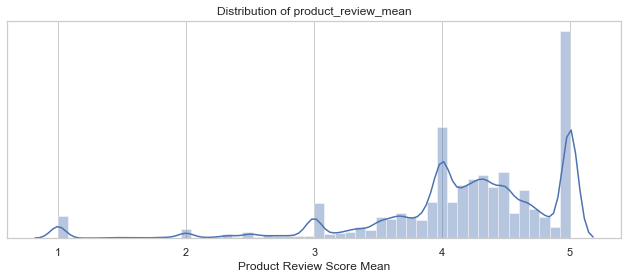

Average Product Review Score : 4


In [263]:
# afficher la distribution des product_review_mean
distribution(df_orders,
             'product_review_mean',
             'Product Review Score Mean',
             'dist')
print('Average Product Review Score : %d'
      % df_orders['product_review_mean'].mean())

In [264]:
# split en 3 niveaux de score
df_orders['product_review_mean_lvl'] = pd.qcut(
    df_orders['product_review_mean'],
    3,
    labels=['Low_Score',
            'Medium_Score',
            'Top_Score'])

Text(0.5, 1.02, 'Score Levels')

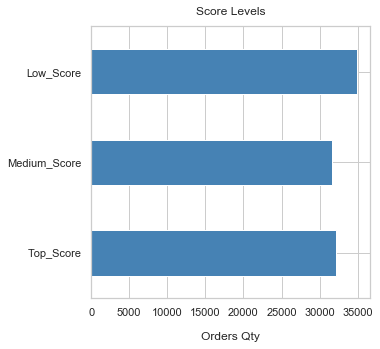

In [265]:
# Contrôler la répartition des niveaux de score
df_orders['product_review_mean_lvl'].value_counts(sort=False).plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Orders Qty', labelpad=14)
plt.title('Score Levels', y=1.02)

In [266]:
# créer / actualiser les commandes répartes par année
orders_2017 = df_orders[(df_orders['order_purchase_year'] == 2017) |
                        (df_orders['order_purchase_year'] == 2016)]
orders_2018 = df_orders[(df_orders['order_purchase_year'] == 2018)]

In [267]:
# observer la variation éventuelle entre 2017 et 2018
print('Variation product_review_mean entre 2017 (ref) et 2018 : ' +
      str(round(orders_2017['product_review_mean'].mean() - orders_2018['product_review_mean'].mean(), 2)))

Variation product_review_mean entre 2017 (ref) et 2018 : 0.0


## 8.3. Note moyenne donnée par chaque client
Comportement évaluateur d'un client : décompte et note moyenne.

In [268]:
# créer la note (décompte et moyenne)
df_cust_mean_score = df_orders.groupby(
    'customer_unique_id',
    as_index=False).agg({'review_score': ['count',
                                          'mean']})
df_cust_mean_score.columns = ['customer_unique_id',
                              'count',
                              'mean']

# afficher les 10 clients donnant les meilleurs notes
df_cust_mean_score = df_cust_mean_score.sort_values(by='count',
                                                    ascending=False)
df_cust_mean_score[:10]

,customer_unique_id,count,mean
68252,c8460e4251689ba205045f3ea17884a1,24,4.0
36033,698e1cf81d01a3d389d96145f7fa6df8,20,1.0
66811,c402f431464c72e27330a67f7b94d4fb,20,1.0
5264,0f5ac8d5c31de21d2f25e24be15bbffb,18,5.0
6196,11f97da02237a49c8e783dfda6f50e8e,15,5.0
17060,31e412b9fb766b6794724ed17a41dfa6,14,1.0
84391,f7ea4eef770a388bd5b225acfc546604,14,1.0
48028,8d50f5eadf50201ccdcedfb9e2ac8455,14,5.0
40085,7582a5a77fc2976628f46a13ec91b375,13,3.0
45942,86df00dc5fd68f4dd5d5945ca19f3ed6,12,5.0


In [269]:
# rattacher au df via le customer_unique_id
df_cust_mean_score = df_cust_mean_score.rename(columns={
    'count': 'customer_review_count',
    'mean': 'customer_review_mean'})
# rattacher aux clients leur note moyenne
df_orders = df_orders.merge(
    df_cust_mean_score,
    how='left',
    left_on=['customer_unique_id'],
    right_on=['customer_unique_id'])

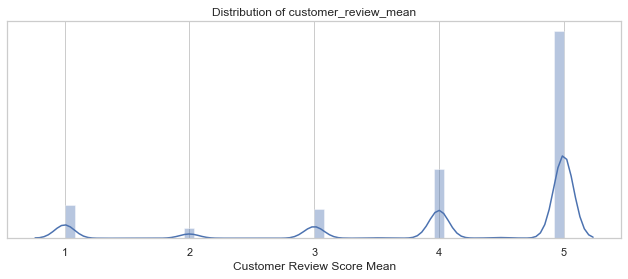

Average Customer Review Score : 4


In [270]:
# afficher la distribution des customer_review_mean
distribution(df_orders,
             'customer_review_mean',
             'Customer Review Score Mean',
             'dist')
print('Average Customer Review Score : %d'
      % df_orders['customer_review_mean'].mean())

In [271]:
# créer / actualiser les commandes répartes par année
orders_2017 = df_orders[(df_orders['order_purchase_year'] == 2017) |
                        (df_orders['order_purchase_year'] == 2016)]
orders_2018 = df_orders[(df_orders['order_purchase_year'] == 2018)]

In [272]:
# observer la variation éventuelle entre 2017 et 2018
print('Variation customer_review_mean entre 2017 (ref) et 2018 : ' +
      str(round(orders_2017['customer_review_mean'].mean() - orders_2018['customer_review_mean'].mean(), 2)))

Variation customer_review_mean entre 2017 (ref) et 2018 : 0.03


## 8.4 Ecart d'évaluation

Le Client évalue-t-il mieux ou moins bien les produits que la moyenne des autres évaluations effectuées pour un produit donné.

In [273]:
# calculer l'écart entre les évaluation moyennes client et globale
df_orders['review_gap'] = df_orders['customer_review_mean'] - df_orders['product_review_mean']

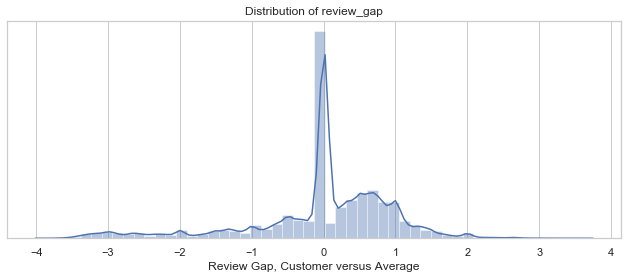

Average Review Gap : 0


In [274]:
# afficher la distribution du review_gap
distribution(df_orders,
             'review_gap',
             'Review Gap, Customer versus Average',
             'dist')
print('Average Review Gap : %d'
      % df_orders['review_gap'].mean())

In [275]:
# créer / actualiser les commandes répartes par année
orders_2017 = df_orders[(df_orders['order_purchase_year'] == 2017) |
                        (df_orders['order_purchase_year'] == 2016)]
orders_2018 = df_orders[(df_orders['order_purchase_year'] == 2018)]

In [276]:
# observer la variation éventuelle entre 2017 et 2018
print('Variation review_gap entre 2017 (ref) et 2018 : ' +
      str(round(orders_2017['review_gap'].mean() - orders_2018['review_gap'].mean(), 2)))

Variation review_gap entre 2017 (ref) et 2018 : 0.03


L'écart moyen est logiquement nul du fait que ce sont les notes des clients qui sont prises en compte pour le même scope de commandes, en revanche l'étalement de l'écart introduit une appréciation différente.

In [298]:
# catégoriser les écart de notation


def note(val):
    if (val == 0):
        return 'Same_Review'
    elif (val < 0):
        return 'Worst_Review'
    else:
        return 'Better_Review'


# dériver un feature identifiant qu'il y a plus de 3 usages
df_orders['review_gap_lvl'] = df_orders['review_gap'].apply(note)

# transformer en feature catégoriel
df_orders['review_gap_lvl'] = df_orders['review_gap_lvl'].astype('category')

Text(0.5, 1.02, 'Review Gap Levels Customers versus Average')

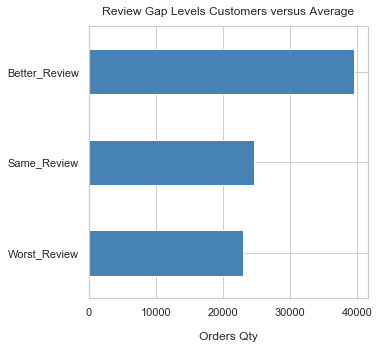

In [299]:
# observer la répartition écarts de score
df_orders['review_gap_lvl'].value_counts(sort=False).plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Orders Qty', labelpad=14)
plt.title('Review Gap Levels Customers versus Average', y=1.02)

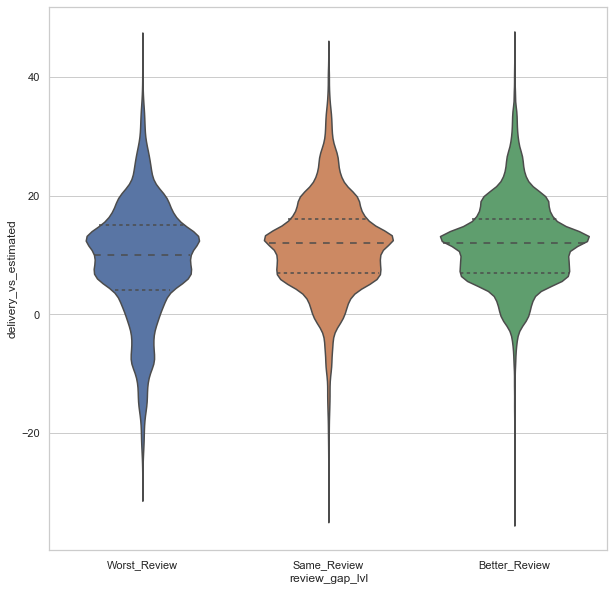

In [280]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.violinplot(x='review_gap_lvl',
                    y='delivery_vs_estimated',
                    order=['Worst_Review', 'Same_Review', 'Better_Review'],
                    data=df_orders,
                    split=True,
                    inner='quartile')

# 9. Données consolidées et Orientation Retenue

Du fait d'être marginales, les commandes multiples ne permettent pas une approche RFM (Recency et Frequency sont affectés).
Nous avons retenu les commandes mono produits et il reste donc à choisie de retenir une commande par client, en partant du principe que l'on ne peut pas reconstruire une liste de clients ayant fait une seule commande parmis les 97 %, d'autant qu'on ne sait pas quel est l'équilibre des données initiales.  <br/>

L'EDA a révélé des features et leurs dérivés, que nous allons catégoriser pour appliquer des traitements systématiques et tester leur pertinence dans l'approche de segmentation. <br/>

## 9.1. Simplification à la commande la plus récente et consolidation

In [281]:
df_orders.columns

Index(['order_id', 'customer_id', 'order_purchase_timestamp',
       'order_purchase_year', 'order_purchase_month', 'order_purchase_day',
       'order_purchase_dayofweek', 'order_purchase_hour',
       'order_purchase_month_label', 'order_purchase_dayofweek_label',
       'time_zone_hour', 'time_zone_day', 'purchase_time_zone_cat',
       'estimated_delivery_time', 'effective_delivery_time',
       'delivery_vs_estimated', 'delivery_vs_estimated_lvl', 'items_qty',
       'products_qty', 'most_important_product', 'total_price',
       'total_freight', 'freight_percentage', 'freight_percentage_lvl',
       'charm_price', 'total_price_lvl', 'charmed_price_cat', 'seller_id',
       'product_price', 'product_freight', 'product_name_length',
       'product_description_length', 'product_photos_qty', 'product_weight_g',
       'product_size', 'product_photos_qty_lvl', 'product_cat',
       'main_payment_type', 'main_payment_value', 'payment_sequence_size',
       'payment_installments_size',

In [282]:
# contrôler l'aggrégation sur la base des coûts
cols = ['total_price',
        'total_freight',
        'payment_total']
df_orders[cols].sample(3)

,total_price,total_freight,payment_total
98492,309.90,23.88,333.78
7774,179.90,52.34,232.24
27505,45.97,13.90,59.87


In [286]:
# trier par date la plus récente
df_orders = df_orders.sort_values(by='order_purchase_timestamp',
                                  ascending=False)
df_orders.head(3)

,order_id,customer_id,order_purchase_timestamp,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_dayofweek,order_purchase_hour,order_purchase_month_label,order_purchase_dayofweek_label,time_zone_hour,time_zone_day,purchase_time_zone_cat,estimated_delivery_time,effective_delivery_time,delivery_vs_estimated,delivery_vs_estimated_lvl,items_qty,products_qty,most_important_product,total_price,total_freight,freight_percentage,freight_percentage_lvl,charm_price,total_price_lvl,charmed_price_cat,seller_id,product_price,product_freight,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_size,product_photos_qty_lvl,product_cat,main_payment_type,main_payment_value,payment_sequence_size,payment_installments_size,payment_total,payment_sequence_size_cat,payment_installment_size_cat,main_payment_type_cat,payment_lvl,seller_city,seller_state,seller_lat,seller_lng,customer_unique_id,customer_city,customer_state,order_count,customer_lat,customer_lng,cust_sell_dist,cust_sell_dist_lvl,review_score,review_answer_delay,review_answer_delay_lvl,product_review_count,product_review_mean,product_review_mean_lvl,customer_review_count,customer_review_mean,review_gap,review_gap_lvl
87355,35a972d7f8436f405b56e36add1a7140,898b7fee99c4e42170ab69ba59be0a8b,2018-08-29 15:00:37,2018,8,29,2,15,Aug,Wed,PM,WD,PM-WD,6,1,5,Later_Delivery,single_item,single_product,d04857e7b4b708ee8b8b9921163edba3,84.99,8.76,9.344000,Low_FreightCost,1,D,Charmed_Price,9f505651f4a6abe901a56cdc21508025,84.99,8.76,33.0,1127.0,2.0,450.0,1280.0,2,Electronics Computers & Accessories,credit_card,93.75,1.0,1.0,93.75,mono_payment,single_payment,Credit_Card_PayType,UnderMed_Payment,Sao Paulo,SP,-23.589847,-46.632614,24ac2b4327e25baf39f2119e4228976a,Limeira,SP,1.0,-22.573479,-47.408479,138.098069,Near_Dist,5,9,Late_Answer,82,4.353659,Medium_Score,1,5.0,0.646341,Better_Review
69116,03ef5dedbe7492bdae72eec50764c43f,496630b6740bcca28fce9ba50d8a26ef,2018-08-29 14:52:00,2018,8,29,2,14,Aug,Wed,PM,WD,PM-WD,4,1,3,Later_Delivery,single_item,single_product,c7f27c5bef2338541c772b5776403e6a,24.90,8.33,25.067710,High_FreightCost,1,C,Charmed_Price,7d7866a99a8656a42c7ff6352a433410,24.90,8.33,54.0,429.0,1.0,450.0,4788.0,1,Supplies,credit_card,33.23,1.0,1.0,33.23,mono_payment,single_payment,Credit_Card_PayType,Light_Payment,Sao Paulo,SP,-23.557955,-46.639347,b701bebbdf478f5500348f03aff62121,Sao Caetano Do Sul,SP,1.0,-23.626539,-46.565188,10.736211,Near_Dist,3,0,Early_Answer,1,3.000000,Low_Score,1,3.0,0.000000,Same_Review
31318,168626408cb32af0ffaf76711caae1dc,6e353700bc7bcdf6ebc15d6de16d7002,2018-08-29 14:18:28,2018,8,29,2,14,Aug,Wed,PM,WD,PM-WD,12,1,11,Nominal_Delivery,single_item,single_product,bdcf6a834e8faa30dac3886c7a58e92e,45.90,15.39,25.110132,High_FreightCost,1,C,Charmed_Price,2a84855fd20af891be03bc5924d2b453,45.90,15.39,26.0,394.0,1.0,1614.0,13888.0,1,Health Beauty Baby,voucher,61.29,1.0,1.0,61.29,mono_payment,single_payment,Other_PayType,Light_Payment,Belo Horizonte,MG,-19.917826,-43.942418,7febafa06d9d8f232a900a2937f04338,Paracatu,MG,1.0,-17.231034,-46.868966,429.397609,AroundMed_Dist,5,2,Nominal_Answer,29,4.172414,Medium_Score,1,5.0,0.827586,Better_Review


In [287]:
# observer le nb de commandes multiples avant simplification
df_orders[df_orders['order_count'] > 1].shape[0]

2911

In [288]:
# ne garder que la dernière commande et surveiller la taille de dataset
print(df_orders.shape)
df_orders.drop_duplicates(subset='customer_unique_id',
                          keep='first',
                          inplace=True)
print(df_orders.shape)

(87086, 68)
(87086, 68)


In [289]:
# observer le nb de commandes multiples après simplification
df_orders[df_orders['order_count'] > 1].shape[0]

2911

In [300]:
# conditionner les données "customer-centric"
data = df_orders.copy()

In [301]:
# passer le customer_unique_id en index
data = data.rename(index=data['customer_unique_id'])

## 9.2. Catégorisation et preprocessing adapté

Le dataset customer-centric présente des features de différentes nature : numériques, catégoriels et ordinaux (i.e. l'ordre importe). Se pose la question du préprocessing adapté à ces features selon leur nature.

In [302]:
# features ordinaux
data.select_dtypes(include='category').columns

Index(['delivery_vs_estimated_lvl', 'freight_percentage_lvl',
       'total_price_lvl', 'product_photos_qty_lvl', 'payment_lvl',
       'cust_sell_dist_lvl', 'review_answer_delay_lvl',
       'product_review_mean_lvl', 'review_gap_lvl'],
      dtype='object')

In [317]:
# autre façon de grouper les features ordinaux
lvl_features = data.columns[data.columns.str.contains('_lvl')].tolist()

In [325]:
# projeter et décrire les features ordinaux
data_lvl = data.filter(lvl_features)
data_lvl.describe()

,delivery_vs_estimated_lvl,freight_percentage_lvl,total_price_lvl,product_photos_qty_lvl,payment_lvl,cust_sell_dist_lvl,review_answer_delay_lvl,product_review_mean_lvl,review_gap_lvl
count,87086,87086,87086,87086,87086,87086,87086,87086,87086
unique,3,3,8,6,4,3,3,3,3
top,Later_Delivery,Low_FreightCost,D,1,Light_Payment,Near_Dist,Early_Answer,Low_Score,Better_Review
freq,31304,29228,25277,42638,23536,29371,48411,29950,39543


In [305]:
# features catégoriels
cat_features = data.columns[data.columns.str.contains('_cat')].tolist()

In [321]:
# projeter et décrire les features catégoriels
data_cat = data.filter(cat_features)
data_cat.describe()

,purchase_time_zone_cat,charmed_price_cat,product_cat,payment_sequence_size_cat,payment_installment_size_cat,main_payment_type_cat
count,87086,87086,87086,87086,87086,87086
unique,5,2,15,2,2,2
top,PM-WD,Charmed_Price,Health Beauty Baby,mono_payment,single_payment,Credit_Card_PayType
freq,22117,60773,13409,84471,84471,65671


In [335]:
# features numériques
data.select_dtypes(include='number')

,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_dayofweek,order_purchase_hour,estimated_delivery_time,effective_delivery_time,delivery_vs_estimated,total_price,total_freight,freight_percentage,charm_price,product_price,product_freight,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_size,main_payment_value,payment_sequence_size,payment_installments_size,payment_total,seller_lat,seller_lng,order_count,customer_lat,customer_lng,cust_sell_dist,review_score,review_answer_delay,product_review_count,product_review_mean,customer_review_count,customer_review_mean,review_gap
24ac2b4327e25baf39f2119e4228976a,2018,8,29,2,15,6,1,5,84.99,8.76,9.344000,1,84.99,8.76,33.0,1127.0,2.0,450.0,1280.0,93.75,1.0,1.0,93.75,-23.589847,-46.632614,1.0,-22.573479,-47.408479,138.098069,5,9,82,4.353659,1,5.0,0.646341
b701bebbdf478f5500348f03aff62121,2018,8,29,2,14,4,1,3,24.90,8.33,25.067710,1,24.90,8.33,54.0,429.0,1.0,450.0,4788.0,33.23,1.0,1.0,33.23,-23.557955,-46.639347,1.0,-23.626539,-46.565188,10.736211,3,0,1,3.000000,1,3.0,0.000000
7febafa06d9d8f232a900a2937f04338,2018,8,29,2,14,12,1,11,45.90,15.39,25.110132,1,45.90,15.39,26.0,394.0,1.0,1614.0,13888.0,61.29,1.0,1.0,61.29,-19.917826,-43.942418,1.0,-17.231034,-46.868966,429.397609,5,2,29,4.172414,1,5.0,0.827586
5c58de6fb80e93396e2f35642666b693,2018,8,29,2,14,5,1,4,418.00,92.96,18.193205,0,209.00,46.48,44.0,112.0,1.0,13550.0,115248.0,510.96,1.0,8.0,510.96,-25.394747,-49.344438,1.0,-25.453054,-49.274996,9.521961,5,54,3,5.000000,2,5.0,0.000000
7a22d14aa3c3599238509ddca4b93b01,2018,8,29,2,12,4,1,3,63.90,9.20,12.585499,1,63.90,9.20,52.0,711.0,2.0,1500.0,11088.0,73.10,1.0,7.0,73.10,-23.502723,-46.738728,1.0,-23.571253,-46.633911,13.124187,1,21,2,3.000000,1,1.0,-2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728e4a7d0db4845270091ded0923c71f,2017,1,5,3,12,38,12,26,9.90,8.72,46.831364,1,9.90,8.72,54.0,282.0,1.0,200.0,352.0,18.62,1.0,1.0,18.62,-25.504915,-49.300034,3.0,-25.453054,-49.274996,6.290523,5,2,1,5.000000,3,5.0,0.000000
f7b981e8a280e455ac3cbe0d5d171bd1,2017,1,5,3,11,26,6,20,10.90,8.72,44.444444,1,10.90,8.72,64.0,1710.0,1.0,200.0,352.0,19.62,1.0,1.0,19.62,-25.504915,-49.300034,2.0,-25.453054,-49.274996,6.290523,5,1,10,5.000000,2,5.0,0.000000
2552194579775fed6641fa5f56152e0a,2016,10,7,4,15,48,7,41,339.90,14.45,4.077889,1,339.90,14.45,43.0,837.0,2.0,411.0,7581.0,354.35,1.0,10.0,354.35,-22.540797,-43.201235,1.0,-22.914911,-43.312877,43.146645,5,20,3,5.000000,1,5.0,0.000000
37d1cea760ff9b96298e678a10b02c85,2016,10,7,4,10,48,7,41,349.90,13.61,3.744051,1,349.90,13.61,36.0,210.0,1.0,541.0,5040.0,363.51,1.0,10.0,363.51,-22.540797,-43.201235,1.0,-22.828016,-43.027779,36.560449,5,4,10,4.600000,1,5.0,0.400000


In [401]:
num_features = ['order_purchase_dayofweek',
                'order_purchase_hour',
                'charm_price',
                'payment_sequence_size',
                'payment_installments_size',
                'main_payment_value',
                'payment_total',
                'total_price',
                'product_price',
                'total_freight',
                'product_freight',
                'product_weight_g',
                'product_size',
                'cust_sell_dist',
                'freight_percentage',
                'product_name_length',
                'product_description_length',
                'product_photos_qty',
                'review_answer_delay',
                'customer_review_count',
                'delivery_vs_estimated',
                'product_review_mean',
                'review_gap',
                'customer_review_mean']

In [ ]:
# transformer en feature catégoriel
# df_orders['purchase_time_zone_cat'] = df_orders['purchase_time_zone_cat'].astype('category')

## 9.3. Analyse multi-variée

In [359]:
cols = data.select_dtypes(include='number').columns

In [385]:
len(cols)

36

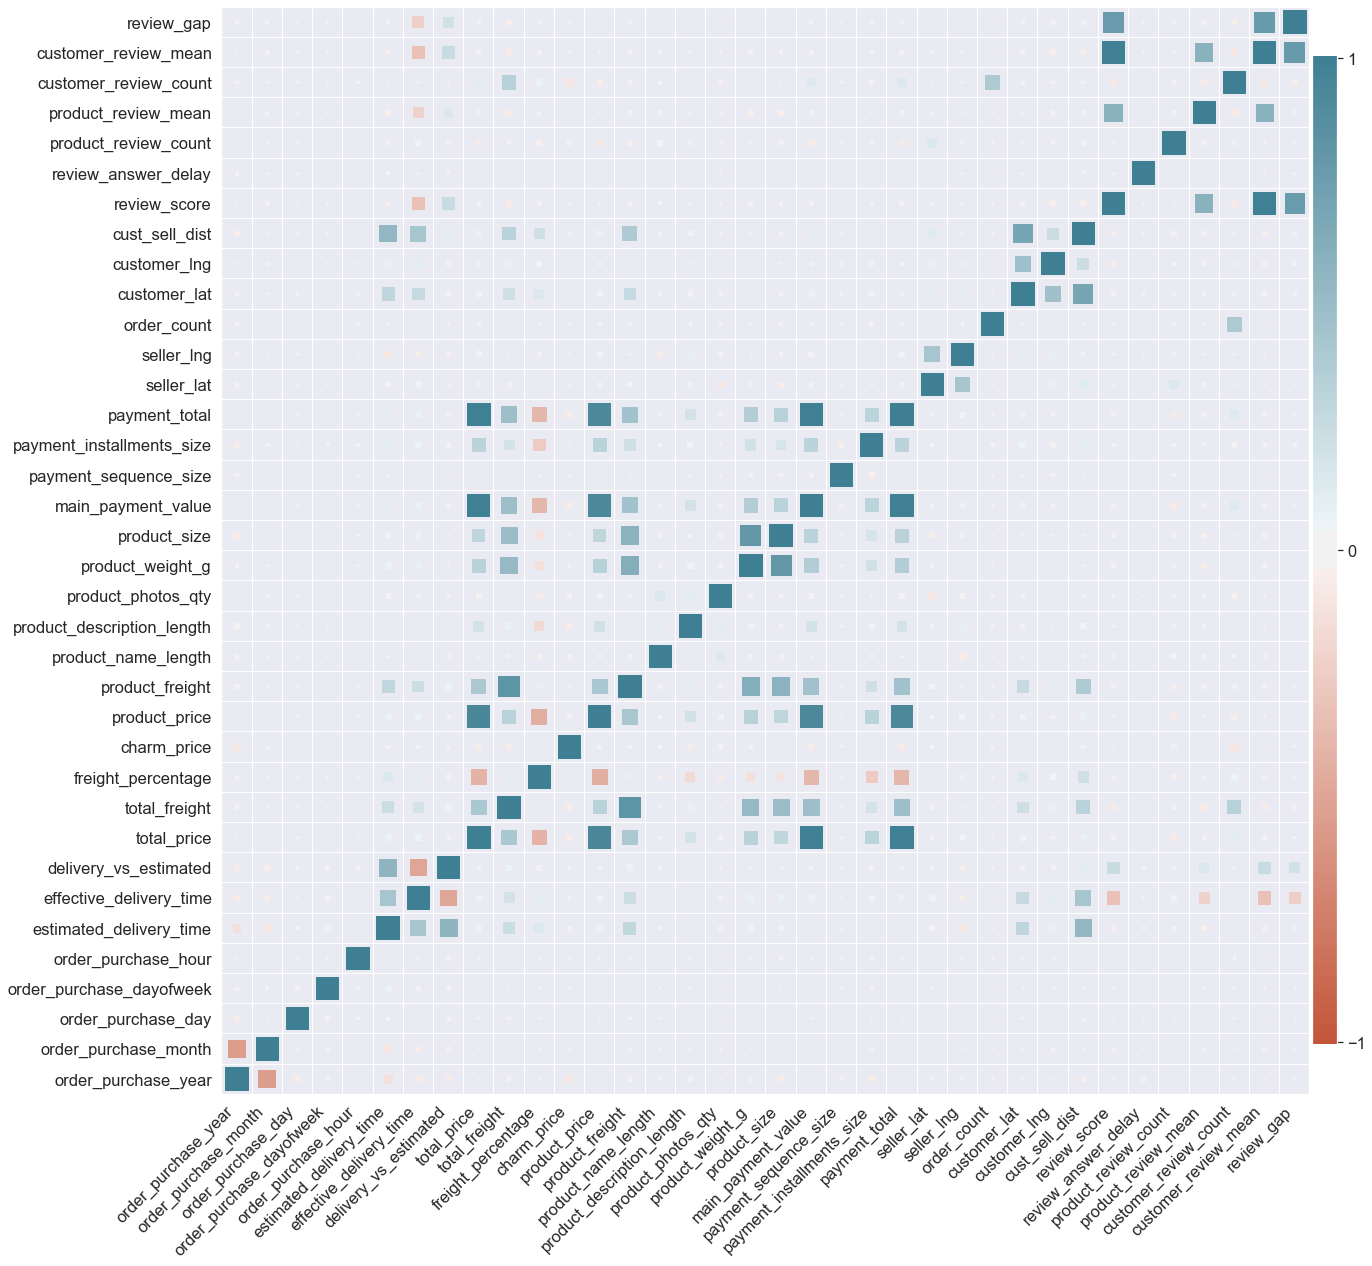

In [387]:
# the perfect heatmap

def heatmap(x, y, size, color):
    fig, ax = plt.subplots(figsize=(20, 20))
    # Mapping from column names to integer coordinates
    x_labels = [v for v in x.unique()]
    y_labels = [v for v in y.unique()]
    x_to_num = {p[1]: p[0] for p in enumerate(x_labels)}
    y_to_num = {p[1]: p[0] for p in enumerate(y_labels)}
    size_scale = 500
    # Use 256 colors for the diverging color palette
    n_colors = 256
    # Create the palette
    palette = sns.diverging_palette(20, 220, n=n_colors)
    # Range of values mapped to the palt, i.e. min and max poss corr
    color_min, color_max = [-1, 1]

    def value_to_color(val):
        # pos of value in input range, relative to length of input range
        val_position = float((val - color_min)) / (color_max - color_min)
        # target index in the color palette
        ind = int(val_position * (n_colors - 1))
        return palette[ind]

    # Setup a 1x40 Grid
    plot_grid = plt.GridSpec(1, 40, hspace=0.2, wspace=0.1)
    # Use the leftmost 39 columns of the grid for the main plot
    ax = plt.subplot(plot_grid[:, :-1])

    ax.scatter(
        x=x.map(x_to_num),  # Use mapping for x
        y=y.map(y_to_num),  # Use mapping for y
        s=size * size_scale,  # Vector sq sizes
        c=color.apply(value_to_color),  # Vector sq color values
        marker='s'  # Use square as scatterplot marker
    )

    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)

    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5])
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])

    # Add color legend on the right side of the plot
    ax = plt.subplot(plot_grid[:, -1])  # Use the rightmost column of the plot

    # Fixed x coordinate for the bars
    col_x = [0]*len(palette)
    # y coordinates for each of the n_colors bars
    bar_y = np.linspace(color_min, color_max, n_colors)

    bar_height = bar_y[1] - bar_y[0]
    ax.barh(
        y=bar_y,
        width=[5]*len(palette),  # Make bars 5 units wide
        left=col_x,  # Make bars start at 0
        height=bar_height,
        color=palette,
        linewidth=0
    )
    # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
    ax.set_xlim(1, 2)
    # Hide grid
    ax.grid(False)
    # Make background white
    ax.set_facecolor('white')
    # Remove horizontal ticks
    ax.set_xticks([])
    # Show vertical ticks for min, middle and max
    ax.set_yticks(np.linspace(min(bar_y), max(bar_y), 3))
    # Show vertical ticks on the right
    ax.yaxis.tick_right()


corr = data[cols].corr()
# Unpivot the dataframe, so we can get pair of arrays for x and y
corr = pd.melt(corr.reset_index(), id_vars='index')
corr.columns = ['x', 'y', 'value']

heatmap(
    x=corr['x'],
    y=corr['y'],
    size=corr['value'].abs(),
    color=corr['value']
)

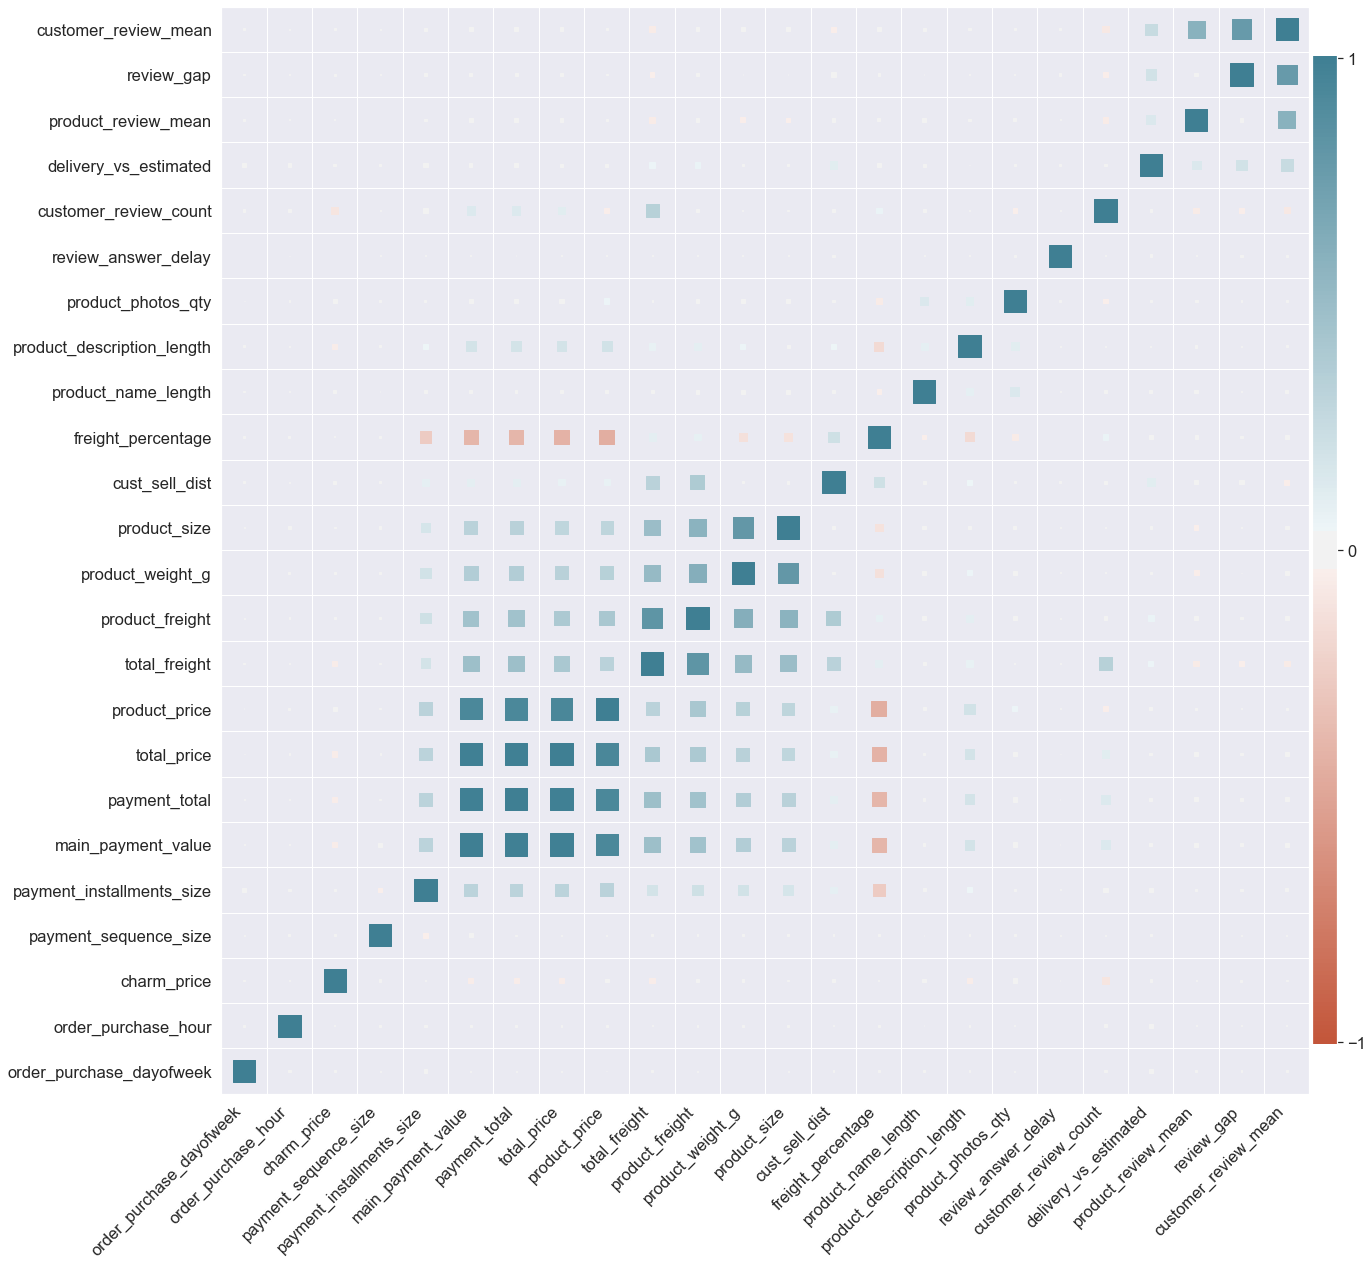

In [403]:
corr = data[num_features].corr()
# Unpivot the dataframe, so we can get pair of arrays for x and y
corr = pd.melt(corr.reset_index(), id_vars='index')
corr.columns = ['x', 'y', 'value']

heatmap(
    x=corr['x'],
    y=corr['y'],
    size=corr['value'].abs(),
    color=corr['value']
)

In [409]:
stdsc = StandardScaler()
data_std = pd.DataFrame(stdsc.fit_transform(data[num_features]))

In [410]:
data_std

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,-0.381629,0.040265,0.658006,-0.122488,-0.702186,-0.283801,-0.288388,-0.237843,-0.215911,-0.650651,-0.721965,-0.440492,-0.596378,-0.779125,-0.912808,-1.587244,0.496212,-0.150299,0.662832,-0.250915,-0.725758,0.227300,0.631401,0.647151
1,-0.381629,-0.147955,0.658006,-0.122488,-0.702186,-0.563481,-0.565887,-0.525416,-0.528625,-0.671895,-0.749317,-0.440492,-0.445863,-0.996863,0.339105,0.517129,-0.564935,-0.722495,-0.263387,-0.250915,-0.967772,-1.536341,-0.019123,-0.967088
2,-0.381629,-0.147955,0.658006,-0.122488,-0.702186,-0.433808,-0.437225,-0.424916,-0.419339,-0.323100,-0.300234,-0.128573,-0.055416,-0.281119,0.342482,-2.288701,-0.618145,-0.722495,-0.057560,-0.250915,0.000286,-0.008838,0.813818,0.647151
3,-0.381629,-0.147955,-1.519743,-0.122488,1.919940,1.644242,1.624626,1.355849,0.429451,3.509196,1.677389,3.069942,4.293559,-0.998939,-0.208239,-0.484953,-1.046860,-0.722495,5.293922,1.648690,-0.846765,1.069400,-0.019123,0.647151
4,-0.381629,-0.524397,0.658006,-0.122488,1.545350,-0.379231,-0.383073,-0.338773,-0.325665,-0.628913,-0.693977,-0.159122,-0.175554,-0.992780,-0.654721,0.316712,-0.136219,-0.150299,1.897789,-0.250915,-0.967772,-1.536341,-2.032063,-2.581327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87081,0.126941,-0.524397,0.658006,-0.122488,-0.702186,-0.630998,-0.632878,-0.597202,-0.606687,-0.652627,-0.724510,-0.507485,-0.636195,-1.004463,2.071914,0.517129,-0.788415,-0.722495,-0.057560,3.548294,1.815396,1.069400,-0.019123,0.647151
87082,0.126941,-0.712618,0.658006,-0.122488,-0.702186,-0.626377,-0.628292,-0.592416,-0.601483,-0.652627,-0.724510,-0.507485,-0.636195,-1.004463,1.881869,1.519211,1.382529,-0.722495,-0.160473,1.648690,1.089352,1.069400,-0.019123,0.647151
87083,0.635511,0.040265,0.658006,-0.122488,2.669119,0.920504,0.906529,0.982084,1.110668,-0.369540,-0.360027,-0.450943,-0.326026,-0.941454,-1.332092,-0.585162,0.055334,-0.150299,1.794876,-0.250915,3.630506,1.069400,-0.019123,0.647151
87084,0.635511,-0.900838,0.658006,-0.122488,2.669119,0.962835,0.948530,1.029942,1.162709,-0.411040,-0.413459,-0.416107,-0.435051,-0.952714,-1.358672,-1.286619,-0.897874,-0.722495,0.148266,-0.250915,3.630506,0.548251,0.383465,0.647151


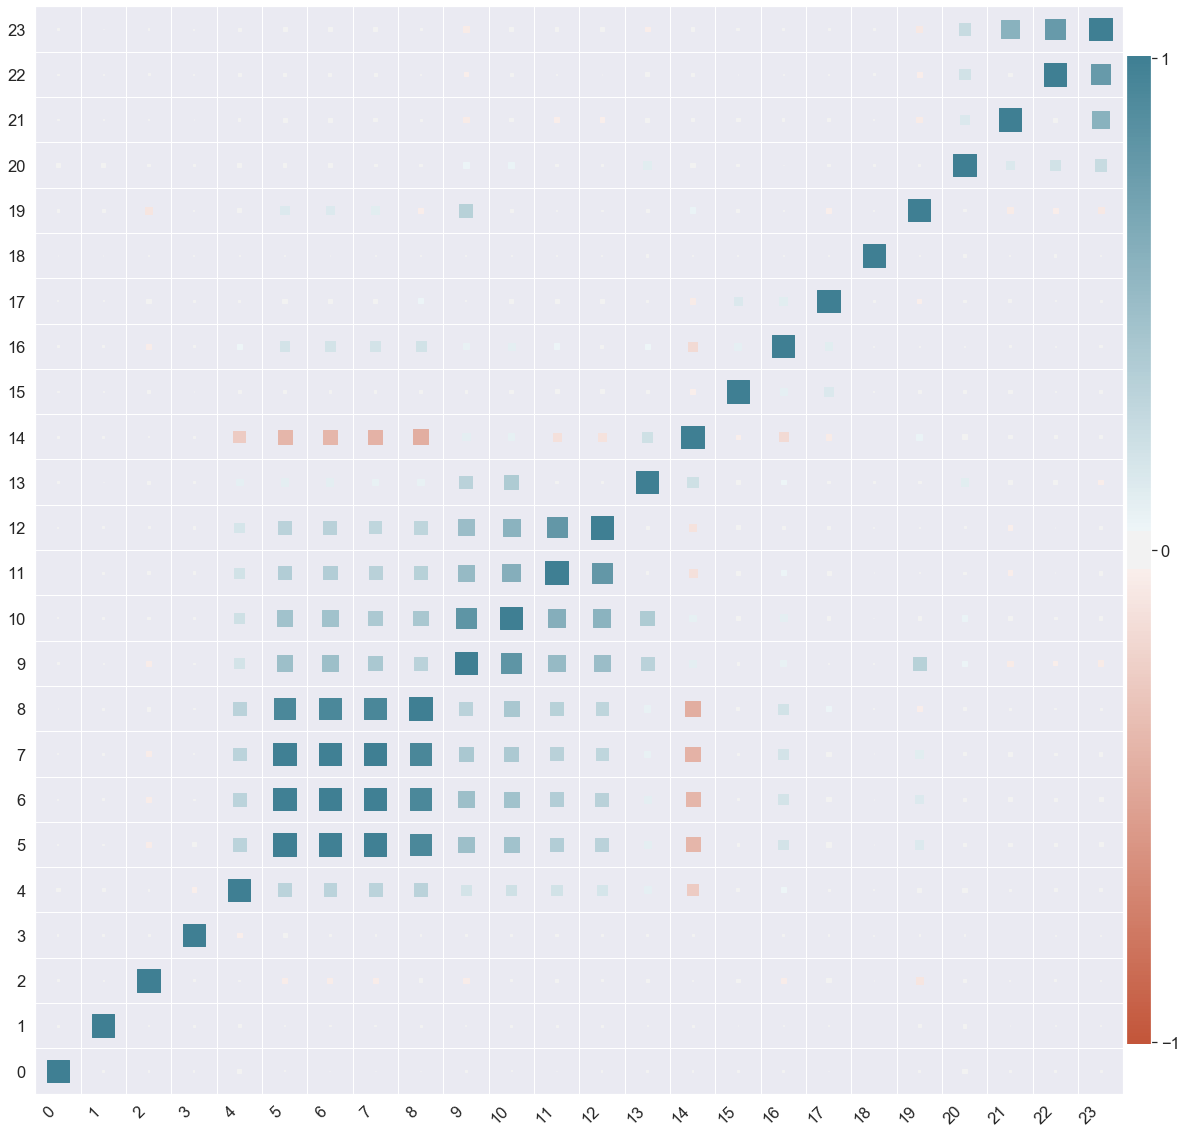

In [411]:
corr = data_std.corr()
# Unpivot the dataframe, so we can get pair of arrays for x and y
corr = pd.melt(corr.reset_index(), id_vars='index')
corr.columns = ['x', 'y', 'value']

heatmap(
    x=corr['x'],
    y=corr['y'],
    size=corr['value'].abs(),
    color=corr['value']
)

In [355]:
cov_mat

array([[ 1.00001148, -0.55076501, -0.05513638, ...,  0.01174834,
        -0.00654395, -0.01106636],
       [-0.55076501,  1.00001148,  0.00437817, ..., -0.00521376,
         0.02873769,  0.02110918],
       [-0.05513638,  0.00437817,  1.00001148, ...,  0.00658314,
         0.00257313,  0.00530591],
       ...,
       [ 0.01174834, -0.00521376,  0.00658314, ...,  1.00001148,
        -0.07500194, -0.04405762],
       [-0.00654395,  0.02873769,  0.00257313, ..., -0.07500194,
         1.00001148,  0.78518973],
       [-0.01106636,  0.02110918,  0.00530591, ..., -0.04405762,
         0.78518973,  1.00001148]])

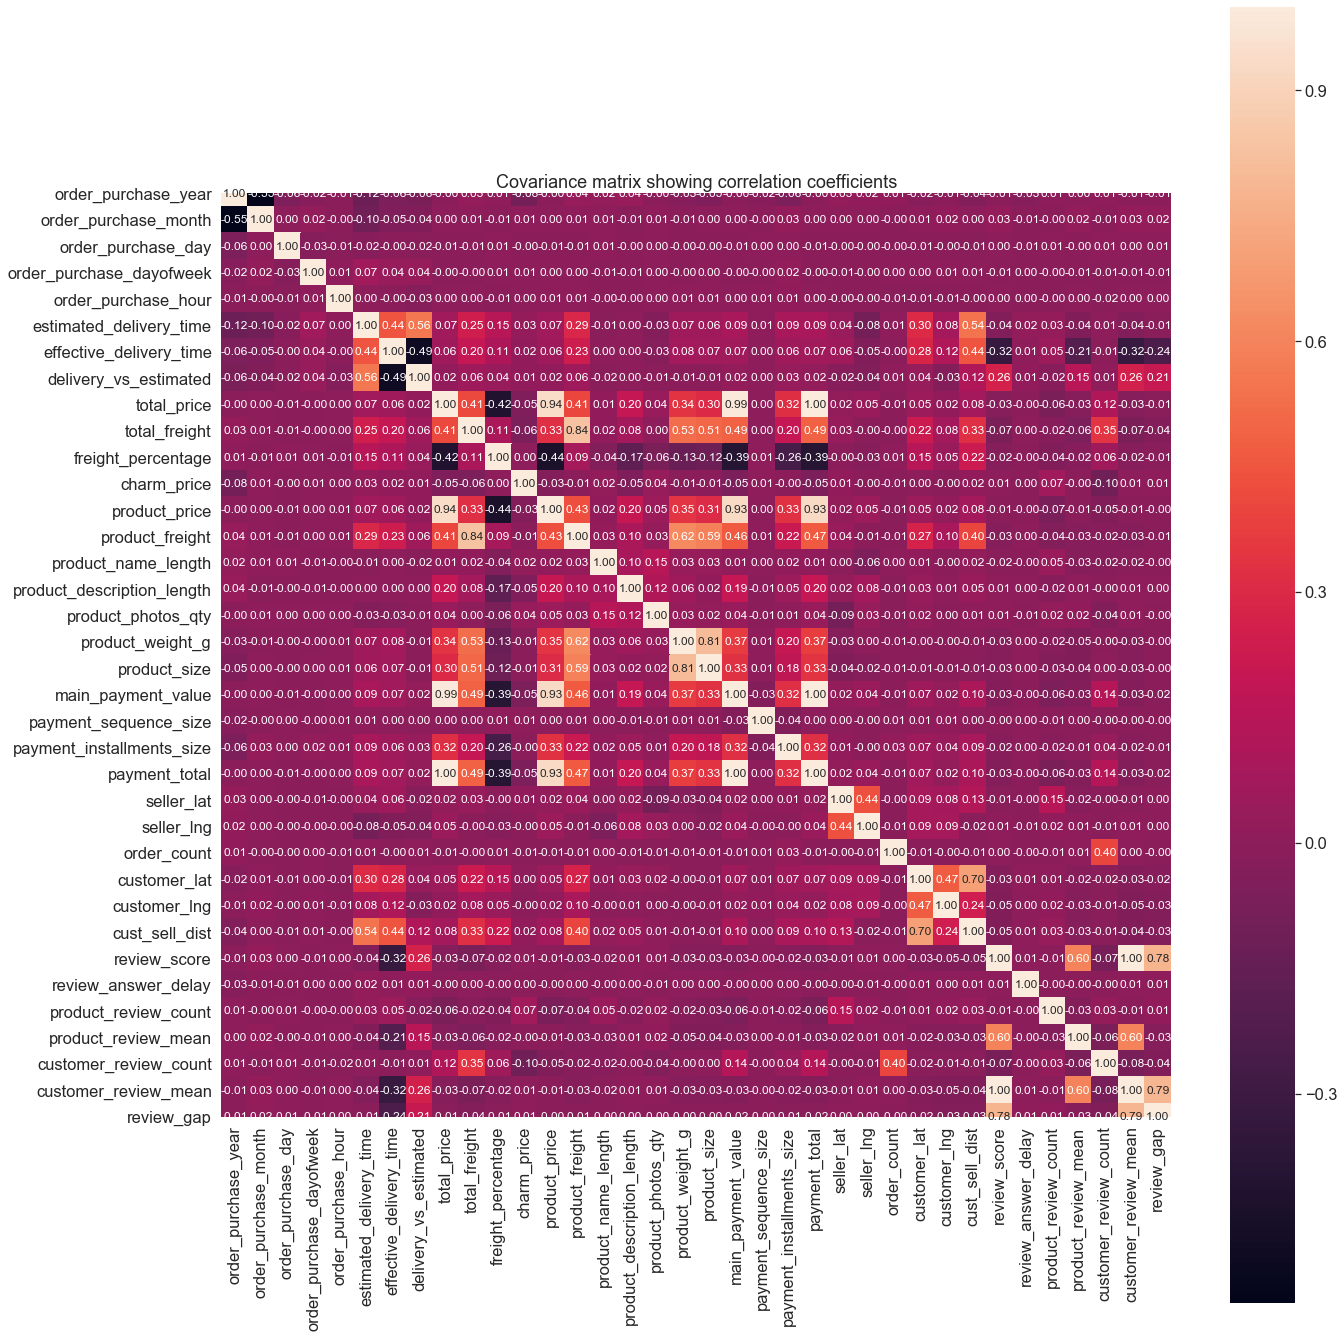

1:23: E231 missing whitespace after ','


In [358]:
plt.figure(figsize=(20,20))
palette = sns.diverging_palette(20, 220, n=256)
sns.set(font_scale=1.5)
hm = sns.heatmap(cov_mat,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 12},
                 yticklabels=cols,
                 xticklabels=cols)
plt.title('Covariance matrix showing correlation coefficients')
plt.tight_layout()
plt.show()

## 9.4.  Catégorisation des features

In [ ]:
data.select_dtypes(include='float64').columns

In [303]:
data.select_dtypes(include='category').columns

Index(['delivery_vs_estimated_lvl', 'freight_percentage_lvl',
       'total_price_lvl', 'product_photos_qty_lvl', 'payment_lvl',
       'cust_sell_dist_lvl', 'review_answer_delay_lvl',
       'product_review_mean_lvl', 'review_gap_lvl'],
      dtype='object')

In [304]:
data.select_dtypes(include='object').columns

Index(['order_id', 'customer_id', 'order_purchase_month_label',
       'order_purchase_dayofweek_label', 'time_zone_hour', 'time_zone_day',
       'purchase_time_zone_cat', 'items_qty', 'products_qty',
       'most_important_product', 'charmed_price_cat', 'seller_id',
       'product_cat', 'main_payment_type', 'payment_sequence_size_cat',
       'payment_installment_size_cat', 'main_payment_type_cat', 'seller_city',
       'seller_state', 'customer_unique_id', 'customer_city',
       'customer_state'],
      dtype='object')

In [ ]:
new_index = ['customer_unique_id']

temporal_cut_features = ['order_purchase_year', 'order_purchase_month']

useless_features = ['order_id',
                    'customer_id',
                    'order_purchase_timestamp',
                    'order_purchase_month_label'
                    'order_purchase_day',
                    'order_purchase_dayofweek_label',
                    'time_zone_hour',
                    'time_zone_day',
                    'most_important_product',
                    'seller_id',
                    'seller_city',
                    'customer_city',
                    'product_review_count',
                    'review_score',
                    'seller_lat',
                    'seller_lng',
                    'customer_lat',
                    'customer_lng']

for_lvl_features = ['delivery_vs_estimated_lvl',
                    'product_desc_length_lvl',
                    'product_name_length_lvl',
                    'product_photos_qty_lvl',
                    'product_size_lvl',
                    'product_weight_g_lvl',
                    'product_density_lvl',
                    'freight_percentage_lvl',
                    'eq_freight_percentage_lvl',
                    'payment_lvl',
                    'eq_payment_lvl',
                    'cust_sell_dist_lvl',
                    'eq_cust_sell_dist_lvl',
                    'review_gap_lvl']

to_encode_features = ['df_rat_categ_qty',
                      'purchase_time_zone',
                      'main_payment_type',
                      'main_payment_type_cat']

In [ ]:
df_orders[df_orders['order_id'] == '00143d0f86d6fbd9f9b38ab440ac16f5']

In [ ]:
# fonction de one-hot encoding pour les données catégorielles


def onehot(data, feature):
    # transforme en binaire les catégories
    temp_df = pd.get_dummies(data[feature])
    # préfixe le nouveau feature
    temp_df = temp_df.add_prefix(feature + '_')
    # ajoute le nouveau feature
    data = pd.concat([data, temp_df], axis=1)
    # retire le feature dans sa version d'origine
    # data.drop(feature, axis=1, inplace=True)
    # retourne le nouveau dataframe
    return data



In [ ]:
# appliquer l'encoding des variables catégorielles retenues
for i in to_encode_features:
    print(i)
    data = onehot(data, i)
    print(data.shape)

In [ ]:
# organiser les features catégoriels encodés
cat_feat_product = data.columns[data.columns.str.contains(
    'rational_category_')].tolist()
cat_feat_order = data.columns[data.columns.str.contains(
    'purchase_time_zone_')].tolist()
cat_feat_payment = data.columns[data.columns.str.contains(
    'main_payment_type')].tolist()
cat_feat_geoloc = data.columns[data.columns.str.contains(
    '_state_')].tolist()

In [ ]:
# fonction de transformation des features numériques


def rankgauss(data, feature):
    # crée une instance de quatiletransformer
    transformer = QuantileTransformer(n_quantiles=100,
                                      random_state=1111,
                                      output_distribution='normal')
    # adpate au feature
    transformer.fit(data[[feature]])
    # préfixe le nouveau feature
    newfeat = str('N_RG_' + feature)
    # ajoute le nouveau feature transformé
    data[newfeat] = transformer.transform(data[[feature]])
    # retire le feature dans sa version d'origine
    # data.drop(feature, axis=1, inplace=True)
    # retourne le nouveau dataframe
    return data

In [ ]:
# prioriser les features numériques exploitables
feature_selection = ['payment_total',
                     'freight_percentage',
                     'product_review_mean',
                     'review_gap',
                     'delivery_vs_estimated',
                     'cust_sell_dist']

In [ ]:
# appliquer le rankgauss aux features numériques
for i in feature_selection:
    print(i)
    data = rankgauss(data, i)
    print(data.shape)

In [ ]:
# observer le résultat du traitement rankgauss:
for i in feature_selection:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12, 5])
    ax1.hist(data[i], bins=100)
    ax1.title.set_text(str('Original Data ' + i))
    ax2.hist(data[str('N_RG_' + i)], bins=100)
    ax2.title.set_text(str('RankGauss-ed Data ' + i))
    plt.show()

In [ ]:
std_feature_selection = data.columns[data.columns.str.contains(
    'N_RG_')].tolist()

In [ ]:
data_std_selection = data.filter(std_feature_selection)

In [ ]:
data_std_selection.head(3)

In [ ]:
data_std_selection.var()

In [ ]:
data['product_review_mean'].var()

In [ ]:
data['std_product_review_mean'] = StandardScaler().fit_transform(data[['product_review_mean']])

In [ ]:
data['std_product_review_mean'].var()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12, 5])
ax1.hist(data['product_review_mean'], bins=100)
ax1.title.set_text(str('Original Data product_review_mean'))
ax2.hist(data['std_product_review_mean'], bins=100)
ax2.title.set_text(str('StandardScaled product_review_mean'))
plt.show()

In [ ]:
data['std_RG_product_review_mean'] = StandardScaler().fit_transform(data[['N_RG_product_review_mean']])

In [ ]:
data['std_RG_product_review_mean'].var()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12, 5])
ax1.hist(data['N_RG_product_review_mean'], bins=100)
ax1.title.set_text(str('Original Data RG_product_review_mean'))
ax2.hist(data['std_RG_product_review_mean'], bins=100)
ax2.title.set_text(str('StandardScaled RG_product_review_mean'))
plt.show()

# selection des features

In [ ]:
std_feature_selection

In [ ]:
# projection sur les données
data_correlation = data.filter(std_feature_selection)
data_correlation.shape

In [ ]:
# visualiser la corrélation des features
plt.figure(figsize=(20, 10))
ax = sns.heatmap(data_correlation.corr(method='pearson'), annot=True)
plt.yticks(rotation=0)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [ ]:
# exporter les données
data.to_csv('Data/data.csv', index=False)

In [ ]:
STOP

## Aperçu K-Means

In [ ]:
sse = {}
silhouette = {}
for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit_predict(data_std_selection)
    silhouette[k] = metrics.silhouette_score(data_std_selection,
                                             kmeans.labels_)
    sse[k] = kmeans.inertia_

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.grid(False)
ax2.grid(False)
ax1.plot(list(sse.keys()),
         list(sse.values()),
         'v-',
         markersize=10,
         color='steelblue')
ax2.plot(list(silhouette.keys()),
         list(silhouette.values()),
         '^-',
         markersize=10,
         color='red')
ax1.set_xlabel('Nb of clusters')
ax1.set_ylabel('Elbow criterion', color='steelblue')
ax2.set_ylabel('Silhouette score', color='red')
plt.show()

In [ ]:
# on complète l'observation par l'analyse du score de Davies-Bouldin
dbs = {}
for k in range(2, 5):
    kmeans = KMeans(n_clusters=k,
                    random_state=42)
    kmeans.fit(data_std_selection)
    dbs[k] = metrics.davies_bouldin_score(
        data_std_selection,
        kmeans.labels_)

In [ ]:
plt.title('Davies-Bouldin Score')
sns.pointplot(x=list(dbs.keys()), y=list(dbs.values()))